# Import

In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Importing custom modules
from data.generate_data_epi import generate_data
from utils.dataset import MyDataset
from utils.early_stopping import EarlyStopping
from utils.train_utils import train_predict, pad_sequences, generate_padding_mask,train_predict_edl
from train.edl_train import exp_evidence
from models.transformer import TransformerWithPooling
from models.mc_dropout import TransformerWithMCDropout
from models.edl import TransformerWithPoolingEDL, mse_loss, uncertainty_and_probabilities

# Setting random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)
%load_ext autoreload
%autoreload 2
# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')


Using device: cuda


# Deep ensemble

In [2]:
def deep_ensemble(num_data,
                  vi_dim,
                  max_seq_length,
                  v,
                  seed,
                  pooling,
                  deep_ensemble_learning_rate,
                  epochs,
                  n_training,
                  var_e,
                  beta_var,
                  deep_ensemble_configs = [
                                            (1, 1),
                                            (1, 2),
                                            (1, 3),
                                            (2, 1),
                                            (4, 1)
                                        ],
                 ):
    # Deep Ensemble parameters
    # Define CLS token
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_inf_len = generate_data(vi_dim=vi_dim, num_data=100000, max_num_emb=100, v=v, seed=seed,length_vary=False,sample_cut=num_data,len_cut=max_seq_length,var_e=var_e,beta_var=beta_var)
    
    X_train, X_test, y_train, y_test, beta, beta0, maximum_auc, Vi, train_vi, test_vi, train_vib, test_vib = data_inf_len
    
    cls_token = np.random.randn(1, vi_dim) + 0
    # Pad sequences
    padded_train_data = pad_sequences(X_train, max_seq_length, cls_token)
    padded_test_data = pad_sequences(X_test, max_seq_length, cls_token)
    print(f'Padded Training Data Shape: {padded_train_data.shape}')
    print(f'Padded Testing Data Shape: {padded_test_data.shape}')

    # Generate padding masks
    padding_masks_train = generate_padding_mask(padded_train_data)
    padding_masks_test = generate_padding_mask(padded_test_data)

    # Create datasets
    train_dataset = MyDataset(padded_train_data, y_train, padding_masks_train)
    val_dataset = MyDataset(padded_test_data, y_test, padding_masks_test)

    # Create DataLoaders
    batch_size = 2000
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Transformer configurations for Deep Ensemble

    deep_ensemble_result = []

    for heads, layers in deep_ensemble_configs:
        print(f"\nTraining Deep Ensemble models with {heads} heads and {layers} layers.")
        n_samples = len(y_test)
        predictions_df = pd.DataFrame(index=range(n_samples), columns=range(n_training))

        for i in tqdm(range(n_training), desc=f"Config {heads}h{layers}l"):
            print(f"\nTraining Model {i+1}/{n_training} for config {heads}h{layers}l.")

            # Initialize model
            model = TransformerWithPooling(
                embedding_size=vi_dim,
                nhead=heads,
                dim_feedforward=512,
                num_layers=layers,
                num_classes=2,
                pooling=pooling,
                dropout=0.1
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=deep_ensemble_learning_rate)
            criterion = nn.CrossEntropyLoss()
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
            early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path=f'best_model_{heads}h{layers}l_model{i}.pt')

            # Train the model
            trained_model = train_predict(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=epochs,
                scheduler=scheduler,
                early_stopping=early_stopping,
                device=device
            )

            # Evaluate the model
            all_probs = []
            trained_model.eval()
            with torch.no_grad():
                for batch in val_loader:
                    test_inputs, val_padding_mask, _ = batch
                    test_inputs = test_inputs.float().to(device)
                    val_padding_mask = val_padding_mask.to(device)

                    outputs = trained_model(test_inputs, src_key_padding_mask=val_padding_mask)
                    probs = F.softmax(outputs, dim=1)
                    all_probs.append(probs.cpu().numpy())

            probabilities = np.concatenate(all_probs)
            predictions_df[i] = probabilities[:, 1]
            predicted_classes = (probabilities[:, 1] >= 0.5).astype(int)
            accuracy = np.mean(predicted_classes == y_test)
            print(f"Model {i+1}/{n_training}, Test Accuracy: {accuracy:.4f}")

            # Clean up
            del model
            torch.cuda.empty_cache()

        deep_ensemble_result.append(predictions_df)
        # Save the DataFrame to a file
    model_dir = f'epi_model_tsf'
    os.makedirs(model_dir, exist_ok=True)
    predictions_path = os.path.join(model_dir, f'tsf_{pooling}_ss{num_data}_sq{max_seq_length}_var{var_e}_beta_var{beta_var}.pkl')
    with open(predictions_path, 'wb') as f:
        pickle.dump(deep_ensemble_result, f)
    print(f"Predictions saved to {predictions_path}")
    return

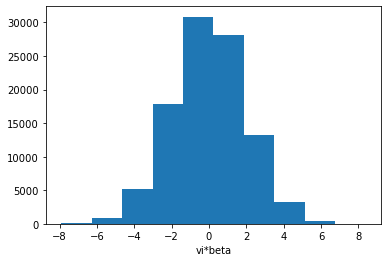

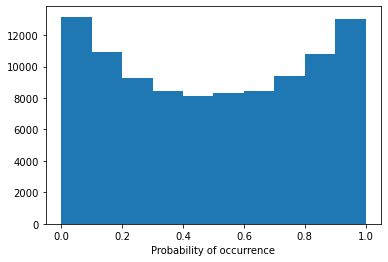

Config 1h3l:   0%|          | 0/30 [00:00<?, ?it/s]

Padded Training Data Shape: torch.Size([10, 21, 20])
Padded Testing Data Shape: torch.Size([20000, 21, 20])

Training Deep Ensemble models with 1 heads and 3 layers.

Training Model 1/30 for config 1h3l.


Config 1h3l:   3%|▎         | 1/30 [00:01<00:30,  1.04s/it]

Early stopping triggered.
Model 1/30, Test Accuracy: 0.4935

Training Model 2/30 for config 1h3l.


Config 1h3l:   7%|▋         | 2/30 [00:01<00:27,  1.02it/s]

Early stopping triggered.
Model 2/30, Test Accuracy: 0.5183

Training Model 3/30 for config 1h3l.


Config 1h3l:  10%|█         | 3/30 [00:02<00:26,  1.04it/s]

Early stopping triggered.
Model 3/30, Test Accuracy: 0.5645

Training Model 4/30 for config 1h3l.


Config 1h3l:  13%|█▎        | 4/30 [00:03<00:25,  1.00it/s]

Early stopping triggered.
Model 4/30, Test Accuracy: 0.5010

Training Model 5/30 for config 1h3l.


Config 1h3l:  17%|█▋        | 5/30 [00:04<00:24,  1.02it/s]

Early stopping triggered.
Model 5/30, Test Accuracy: 0.5230

Training Model 6/30 for config 1h3l.


Config 1h3l:  20%|██        | 6/30 [00:05<00:23,  1.03it/s]

Early stopping triggered.
Model 6/30, Test Accuracy: 0.5017

Training Model 7/30 for config 1h3l.


Config 1h3l:  23%|██▎       | 7/30 [00:06<00:22,  1.01it/s]

Early stopping triggered.
Model 7/30, Test Accuracy: 0.4944

Training Model 8/30 for config 1h3l.


Config 1h3l:  27%|██▋       | 8/30 [00:07<00:21,  1.02it/s]

Early stopping triggered.
Model 8/30, Test Accuracy: 0.4861

Training Model 9/30 for config 1h3l.


Config 1h3l:  30%|███       | 9/30 [00:08<00:20,  1.03it/s]

Early stopping triggered.
Model 9/30, Test Accuracy: 0.5633

Training Model 10/30 for config 1h3l.


Config 1h3l:  33%|███▎      | 10/30 [00:09<00:19,  1.01it/s]

Early stopping triggered.
Model 10/30, Test Accuracy: 0.4647

Training Model 11/30 for config 1h3l.


Config 1h3l:  37%|███▋      | 11/30 [00:10<00:18,  1.02it/s]

Early stopping triggered.
Model 11/30, Test Accuracy: 0.5284

Training Model 12/30 for config 1h3l.


Config 1h3l:  40%|████      | 12/30 [00:11<00:17,  1.02it/s]

Early stopping triggered.
Model 12/30, Test Accuracy: 0.4943

Training Model 13/30 for config 1h3l.


Config 1h3l:  43%|████▎     | 13/30 [00:12<00:17,  1.00s/it]

Early stopping triggered.
Model 13/30, Test Accuracy: 0.5337

Training Model 14/30 for config 1h3l.


Config 1h3l:  47%|████▋     | 14/30 [00:13<00:15,  1.01it/s]

Early stopping triggered.
Model 14/30, Test Accuracy: 0.5205

Training Model 15/30 for config 1h3l.


Config 1h3l:  50%|█████     | 15/30 [00:14<00:14,  1.03it/s]

Early stopping triggered.
Model 15/30, Test Accuracy: 0.4081

Training Model 16/30 for config 1h3l.


Config 1h3l:  53%|█████▎    | 16/30 [00:15<00:14,  1.00s/it]

Early stopping triggered.
Model 16/30, Test Accuracy: 0.5036

Training Model 17/30 for config 1h3l.


Config 1h3l:  57%|█████▋    | 17/30 [00:16<00:12,  1.02it/s]

Early stopping triggered.
Model 17/30, Test Accuracy: 0.4518

Training Model 18/30 for config 1h3l.


Config 1h3l:  60%|██████    | 18/30 [00:17<00:11,  1.03it/s]

Early stopping triggered.
Model 18/30, Test Accuracy: 0.5187

Training Model 19/30 for config 1h3l.


Config 1h3l:  63%|██████▎   | 19/30 [00:18<00:10,  1.01it/s]

Early stopping triggered.
Model 19/30, Test Accuracy: 0.5520

Training Model 20/30 for config 1h3l.


Config 1h3l:  67%|██████▋   | 20/30 [00:19<00:09,  1.02it/s]

Early stopping triggered.
Model 20/30, Test Accuracy: 0.5651

Training Model 21/30 for config 1h3l.


Config 1h3l:  70%|███████   | 21/30 [00:20<00:08,  1.03it/s]

Early stopping triggered.
Model 21/30, Test Accuracy: 0.4966

Training Model 22/30 for config 1h3l.


Config 1h3l:  73%|███████▎  | 22/30 [00:21<00:07,  1.01it/s]

Early stopping triggered.
Model 22/30, Test Accuracy: 0.5082

Training Model 23/30 for config 1h3l.


Config 1h3l:  77%|███████▋  | 23/30 [00:22<00:06,  1.02it/s]

Early stopping triggered.
Model 23/30, Test Accuracy: 0.5461

Training Model 24/30 for config 1h3l.


Config 1h3l:  80%|████████  | 24/30 [00:23<00:05,  1.04it/s]

Early stopping triggered.
Model 24/30, Test Accuracy: 0.5147

Training Model 25/30 for config 1h3l.


Config 1h3l:  83%|████████▎ | 25/30 [00:24<00:04,  1.02it/s]

Early stopping triggered.
Model 25/30, Test Accuracy: 0.4354

Training Model 26/30 for config 1h3l.


Config 1h3l:  87%|████████▋ | 26/30 [00:25<00:03,  1.02it/s]

Early stopping triggered.
Model 26/30, Test Accuracy: 0.5133

Training Model 27/30 for config 1h3l.


Config 1h3l:  90%|█████████ | 27/30 [00:26<00:02,  1.03it/s]

Early stopping triggered.
Model 27/30, Test Accuracy: 0.5451

Training Model 28/30 for config 1h3l.


Config 1h3l:  93%|█████████▎| 28/30 [00:27<00:01,  1.02it/s]

Early stopping triggered.
Model 28/30, Test Accuracy: 0.4706

Training Model 29/30 for config 1h3l.


Config 1h3l:  97%|█████████▋| 29/30 [00:28<00:00,  1.02it/s]

Early stopping triggered.
Model 29/30, Test Accuracy: 0.5143

Training Model 30/30 for config 1h3l.


Config 1h3l: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]

Early stopping triggered.
Model 30/30, Test Accuracy: 0.5209
Predictions saved to epi_model_tsf/tsf_mean_ss10_sq20_var0.25_beta_var0.4.pkl
Deep Ensemble Result: None


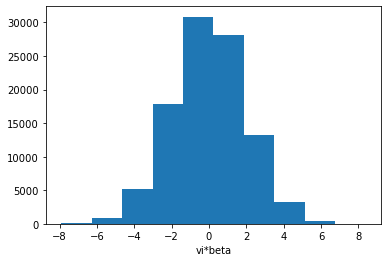

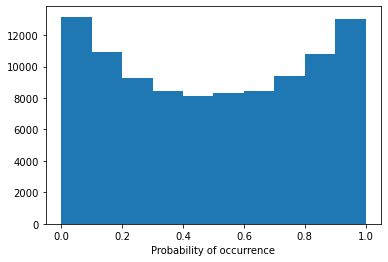

Config 1h3l:   0%|          | 0/30 [00:00<?, ?it/s]

Padded Training Data Shape: torch.Size([100, 21, 20])
Padded Testing Data Shape: torch.Size([20000, 21, 20])

Training Deep Ensemble models with 1 heads and 3 layers.

Training Model 1/30 for config 1h3l.


Config 1h3l:   3%|▎         | 1/30 [00:02<01:09,  2.40s/it]

Model 1/30, Test Accuracy: 0.6208

Training Model 2/30 for config 1h3l.


Config 1h3l:   7%|▋         | 2/30 [00:04<00:55,  1.99s/it]

Model 2/30, Test Accuracy: 0.6965

Training Model 3/30 for config 1h3l.


In [ ]:
seq_lengths=[1, 2, 3, 4, 5, 10, 20]
combo_seql_ss=[([20],[10,100,1000,10000,30000,50000,70000,100000]),
              ([1,3,5,7,10,15,20],[100000])]
poolings=["mean","cls"]
for pooling in poolings:
    for var_e in [0.25,0.5,1,2,3,4,7]:
        for seqls,sample_sizes in combo_seql_ss:
            for max_seq_length in seqls:
                for num_data in sample_sizes:
                    file_path = f"epi_model_tsf/epi_{pooling}_ss{num_data}_sq{max_seq_length}.pkl"
                    if os.path.exists(file_path):
                        print(f"Skipping training for model with sample size {num_data} and sequence length {max_seq_length}, file already exists.")
                        continue        
                    vi_dim = 20  
                    v = 0  
                    seed = 42 
                    deep_ensemble_learning_rate = 0.001  
                    epochs = 10  # Number of training epochs
                    n_training = 30  # Number of models per ensemble

                    # Define ensemble configurations (heads, layers)
                    deep_ensemble_configs = [
                        (1, 3),
                    ]

                    # Call the function
                    deep_ensemble_result = deep_ensemble(
                        num_data=num_data,
                        vi_dim=vi_dim,
                        max_seq_length=max_seq_length,
                        v=v,
                        seed=seed,
                        pooling=pooling,
                        deep_ensemble_learning_rate=deep_ensemble_learning_rate,
                        epochs=epochs,
                        n_training=n_training,
                        deep_ensemble_configs=deep_ensemble_configs,
                        var_e=var_e,
                        beta_var=0.4
                    )

                    # Print the output
                    print("Deep Ensemble Result:", deep_ensemble_result)


# LR

test

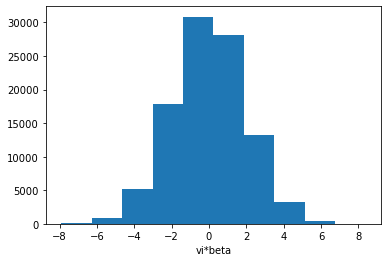

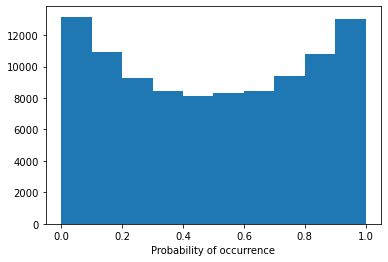

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:21<04:07,  8.84s/it]

Model 1/30, Test Accuracy: 0.4582

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4248

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:21<01:27,  3.36s/it]

Model 3/30, Test Accuracy: 0.4250

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5236

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5152

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:21<00:24,  1.12s/it]

Model 6/30, Test Accuracy: 0.5961

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5056

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5251

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:14,  1.34it/s]

Model 9/30, Test Accuracy: 0.5152

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5572

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4749

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:22<00:05,  2.74it/s]

Model 12/30, Test Accuracy: 0.5452

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5334

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.4916

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5722

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:22<00:02,  4.99it/s]

Model 16/30, Test Accuracy: 0.4476

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4108

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.3902

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5673

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:22<00:01,  7.99it/s]

Model 20/30, Test Accuracy: 0.4445

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5946

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4225

Training Model 23/30 with dropout seed 0.
Model 23/30, Test Accuracy: 0.4731

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:23<00:00, 11.16it/s]

Model 24/30, Test Accuracy: 0.5792

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4833

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4616

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4447

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s]

Model 28/30, Test Accuracy: 0.4826

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4969

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4812


Predictions saved to epi_model_limitation/epi_mean_ss10_sq20_var0.25_beta_var0.4.pkl


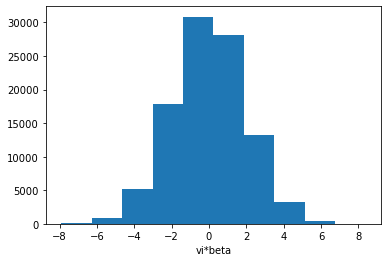

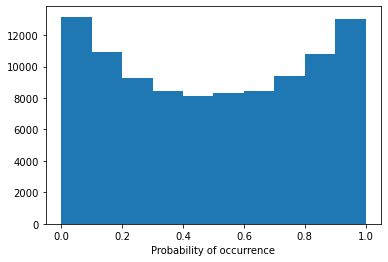

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:02, 12.58it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4610

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4275

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:01, 15.22it/s]

Model 3/30, Test Accuracy: 0.4382

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5286

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5206

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.6130

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 15.34it/s]

Model 7/30, Test Accuracy: 0.5150

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5409

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5287

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5705

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:00<00:01, 15.83it/s]

Model 11/30, Test Accuracy: 0.4819

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5574

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5319

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.5011

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:01<00:01, 13.02it/s]

Model 15/30, Test Accuracy: 0.5853

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4611

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:01<00:00, 14.86it/s]

Model 17/30, Test Accuracy: 0.4213

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.3986

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5789

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4521

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:01<00:00, 15.71it/s]

Model 21/30, Test Accuracy: 0.6053

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4226

Training Model 23/30 with dropout seed 0.
Model 23/30, Test Accuracy: 0.4759

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5961

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:01<00:00, 16.96it/s]

Model 25/30, Test Accuracy: 0.4860

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4675

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4454

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4966

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:01<00:00, 15.48it/s]


Model 29/30, Test Accuracy: 0.4969

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4874
Predictions saved to epi_model_limitation/epi_mean_ss100_sq20_var0.25_beta_var0.4.pkl


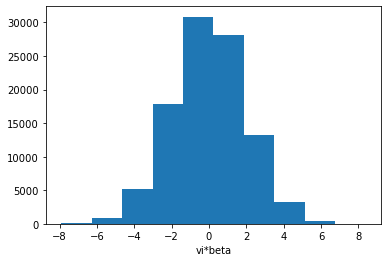

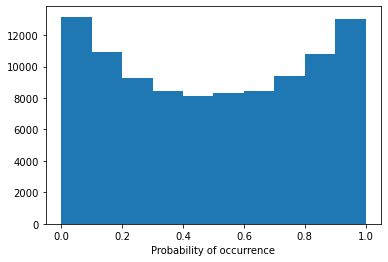

Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:04,  6.67it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4681

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:00<00:02,  9.97it/s]

Model 2/30, Test Accuracy: 0.4353

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4410

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5339

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:00<00:01, 11.82it/s]

Model 5/30, Test Accuracy: 0.5234

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.6188

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5165

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:00<00:01, 11.50it/s]

Model 8/30, Test Accuracy: 0.5456

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5297

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5766

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:01<00:01, 11.95it/s]

Model 11/30, Test Accuracy: 0.4860

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5621

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5420

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:01<00:01, 10.45it/s]

Model 14/30, Test Accuracy: 0.5044

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5884

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4692

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:01<00:00, 11.15it/s]

Model 17/30, Test Accuracy: 0.4278

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.3997

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5812

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:01<00:00, 11.72it/s]

Model 20/30, Test Accuracy: 0.4605

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.6182

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4270

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:02<00:00, 12.24it/s]

Model 23/30, Test Accuracy: 0.4790

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.6008

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4907

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:02<00:00, 12.36it/s]

Model 26/30, Test Accuracy: 0.4736

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4495

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4973

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 11.73it/s]

Model 29/30, Test Accuracy: 0.5045

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4958
Predictions saved to epi_model_limitation/epi_mean_ss1000_sq20_var0.25_beta_var0.4.pkl


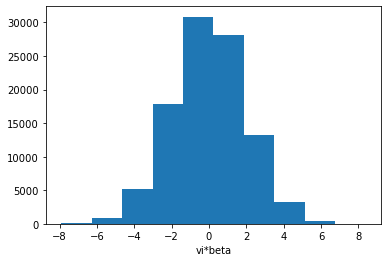

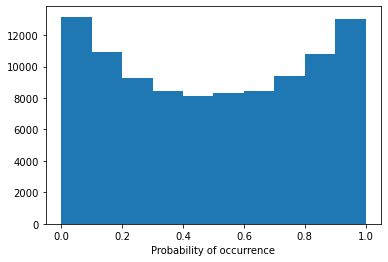

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:12,  2.34it/s]

Model 1/30, Test Accuracy: 0.5453

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:09,  2.84it/s]

Model 2/30, Test Accuracy: 0.5396

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:01<00:08,  3.00it/s]

Model 3/30, Test Accuracy: 0.5441

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:01<00:08,  3.11it/s]

Model 4/30, Test Accuracy: 0.5988

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:01<00:07,  3.13it/s]

Model 5/30, Test Accuracy: 0.5827

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:02<00:08,  2.98it/s]

Model 6/30, Test Accuracy: 0.6971

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:02<00:07,  3.02it/s]

Model 7/30, Test Accuracy: 0.6024

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:02<00:07,  3.11it/s]

Model 8/30, Test Accuracy: 0.6271

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:03<00:07,  2.93it/s]

Model 9/30, Test Accuracy: 0.5984

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:03<00:06,  3.02it/s]

Model 10/30, Test Accuracy: 0.6480

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:03<00:06,  3.10it/s]

Model 11/30, Test Accuracy: 0.5573

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:03<00:05,  3.18it/s]

Model 12/30, Test Accuracy: 0.6320

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:04<00:05,  3.19it/s]

Model 13/30, Test Accuracy: 0.6510

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:04<00:04,  3.28it/s]

Model 14/30, Test Accuracy: 0.5694

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:04<00:04,  3.03it/s]

Model 15/30, Test Accuracy: 0.6518

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:05<00:04,  3.13it/s]

Model 16/30, Test Accuracy: 0.5652

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:05<00:04,  3.10it/s]

Model 17/30, Test Accuracy: 0.5185

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:05<00:04,  2.79it/s]

Model 18/30, Test Accuracy: 0.4623

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:06<00:03,  2.91it/s]

Model 19/30, Test Accuracy: 0.6551

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:06<00:03,  2.99it/s]

Model 20/30, Test Accuracy: 0.5161

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:06<00:02,  3.05it/s]

Model 21/30, Test Accuracy: 0.6985

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:07<00:02,  3.13it/s]

Model 22/30, Test Accuracy: 0.5081

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:07<00:02,  2.92it/s]

Model 23/30, Test Accuracy: 0.5266

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:07<00:01,  3.05it/s]

Model 24/30, Test Accuracy: 0.6913

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:08<00:01,  3.12it/s]

Model 25/30, Test Accuracy: 0.5727

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:08<00:01,  2.95it/s]

Model 26/30, Test Accuracy: 0.5488

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:08<00:00,  3.03it/s]

Model 27/30, Test Accuracy: 0.4942

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:09<00:00,  3.14it/s]

Model 28/30, Test Accuracy: 0.5875

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:09<00:00,  3.21it/s]

Model 29/30, Test Accuracy: 0.5917

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:09<00:00,  3.06it/s]

Model 30/30, Test Accuracy: 0.5746
Predictions saved to epi_model_limitation/epi_mean_ss10000_sq20_var0.25_beta_var0.4.pkl


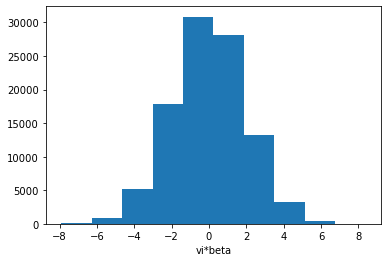

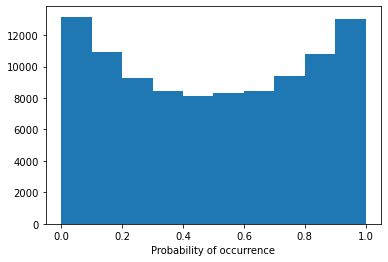

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:26,  1.09it/s]

Model 1/30, Test Accuracy: 0.6929

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:01<00:24,  1.16it/s]

Model 2/30, Test Accuracy: 0.7239

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:02<00:23,  1.16it/s]

Model 3/30, Test Accuracy: 0.7287

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:03<00:22,  1.15it/s]

Model 4/30, Test Accuracy: 0.7229

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:04<00:21,  1.17it/s]

Model 5/30, Test Accuracy: 0.7039

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:05<00:20,  1.15it/s]

Model 6/30, Test Accuracy: 0.7650

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:06<00:20,  1.14it/s]

Model 7/30, Test Accuracy: 0.7361

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:06<00:18,  1.17it/s]

Model 8/30, Test Accuracy: 0.7389

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:07<00:18,  1.16it/s]

Model 9/30, Test Accuracy: 0.7195

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:08<00:17,  1.15it/s]

Model 10/30, Test Accuracy: 0.7471

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:09<00:16,  1.18it/s]

Model 11/30, Test Accuracy: 0.6871

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:10<00:15,  1.16it/s]

Model 12/30, Test Accuracy: 0.7339

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:11<00:14,  1.14it/s]

Model 13/30, Test Accuracy: 0.7624

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:12<00:13,  1.15it/s]

Model 14/30, Test Accuracy: 0.7027

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:13<00:13,  1.14it/s]

Model 15/30, Test Accuracy: 0.7439

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:13<00:12,  1.12it/s]

Model 16/30, Test Accuracy: 0.7116

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:14<00:12,  1.07it/s]

Model 17/30, Test Accuracy: 0.6938

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:15<00:11,  1.07it/s]

Model 18/30, Test Accuracy: 0.6835

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:16<00:10,  1.08it/s]

Model 19/30, Test Accuracy: 0.7506

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:17<00:08,  1.12it/s]

Model 20/30, Test Accuracy: 0.6622

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:18<00:08,  1.11it/s]

Model 21/30, Test Accuracy: 0.7580

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:19<00:07,  1.13it/s]

Model 22/30, Test Accuracy: 0.7016

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:20<00:06,  1.11it/s]

Model 23/30, Test Accuracy: 0.6691

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:21<00:05,  1.14it/s]

Model 24/30, Test Accuracy: 0.7644

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:22<00:04,  1.11it/s]

Model 25/30, Test Accuracy: 0.7001

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:23<00:03,  1.10it/s]

Model 26/30, Test Accuracy: 0.7006

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:23<00:02,  1.12it/s]

Model 27/30, Test Accuracy: 0.6345

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:24<00:01,  1.10it/s]

Model 28/30, Test Accuracy: 0.7234

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:25<00:00,  1.09it/s]

Model 29/30, Test Accuracy: 0.7236

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:26<00:00,  1.13it/s]

Model 30/30, Test Accuracy: 0.7198
Predictions saved to epi_model_limitation/epi_mean_ss30000_sq20_var0.25_beta_var0.4.pkl


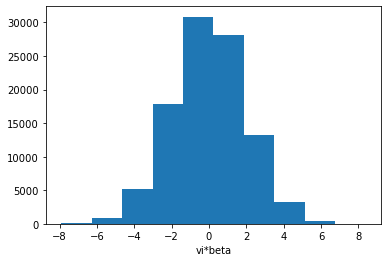

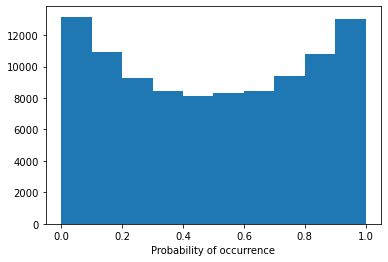

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:42,  1.46s/it]

Model 1/30, Test Accuracy: 0.7459

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:03<00:42,  1.52s/it]

Model 2/30, Test Accuracy: 0.7645

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:04<00:39,  1.46s/it]

Model 3/30, Test Accuracy: 0.7685

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:05<00:38,  1.49s/it]

Model 4/30, Test Accuracy: 0.7602

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:07<00:37,  1.48s/it]

Model 5/30, Test Accuracy: 0.7573

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:09<00:37,  1.55s/it]

Model 6/30, Test Accuracy: 0.7764

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:10<00:34,  1.51s/it]

Model 7/30, Test Accuracy: 0.7721

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:12<00:34,  1.55s/it]

Model 8/30, Test Accuracy: 0.7640

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:13<00:31,  1.50s/it]

Model 9/30, Test Accuracy: 0.7638

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:15<00:30,  1.52s/it]

Model 10/30, Test Accuracy: 0.7716

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:16<00:27,  1.47s/it]

Model 11/30, Test Accuracy: 0.7400

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:18<00:26,  1.50s/it]

Model 12/30, Test Accuracy: 0.7642

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:19<00:25,  1.50s/it]

Model 13/30, Test Accuracy: 0.7748

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:21<00:24,  1.50s/it]

Model 14/30, Test Accuracy: 0.7540

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:22<00:22,  1.51s/it]

Model 15/30, Test Accuracy: 0.7689

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:24<00:21,  1.51s/it]

Model 16/30, Test Accuracy: 0.7556

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:25<00:19,  1.51s/it]

Model 17/30, Test Accuracy: 0.7557

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:27<00:18,  1.50s/it]

Model 18/30, Test Accuracy: 0.7571

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:28<00:16,  1.51s/it]

Model 19/30, Test Accuracy: 0.7704

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:30<00:14,  1.50s/it]

Model 20/30, Test Accuracy: 0.7391

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:31<00:13,  1.50s/it]

Model 21/30, Test Accuracy: 0.7712

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:33<00:11,  1.49s/it]

Model 22/30, Test Accuracy: 0.7601

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:34<00:10,  1.50s/it]

Model 23/30, Test Accuracy: 0.7457

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:36<00:08,  1.49s/it]

Model 24/30, Test Accuracy: 0.7750

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:37<00:07,  1.49s/it]

Model 25/30, Test Accuracy: 0.7512

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:38<00:05,  1.48s/it]

Model 26/30, Test Accuracy: 0.7516

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:40<00:04,  1.48s/it]

Model 27/30, Test Accuracy: 0.7217

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:41<00:02,  1.48s/it]

Model 28/30, Test Accuracy: 0.7625

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:43<00:01,  1.47s/it]

Model 29/30, Test Accuracy: 0.7607

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:44<00:00,  1.49s/it]

Model 30/30, Test Accuracy: 0.7603
Predictions saved to epi_model_limitation/epi_mean_ss50000_sq20_var0.25_beta_var0.4.pkl


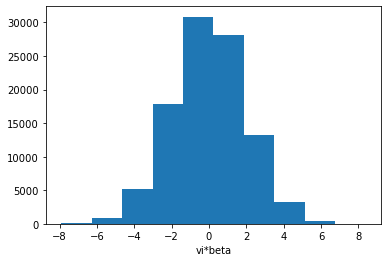

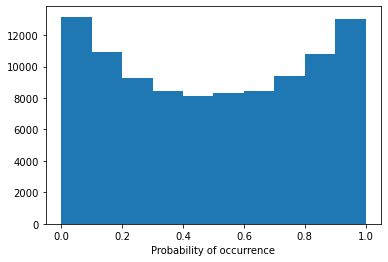

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:57,  1.99s/it]

Model 1/30, Test Accuracy: 0.7662

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:56,  2.02s/it]

Model 2/30, Test Accuracy: 0.7720

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:05<00:53,  1.98s/it]

Model 3/30, Test Accuracy: 0.7766

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:07<00:49,  1.91s/it]

Model 4/30, Test Accuracy: 0.7714

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:09<00:47,  1.88s/it]

Model 5/30, Test Accuracy: 0.7735

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:11<00:45,  1.91s/it]

Model 6/30, Test Accuracy: 0.7783

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:13<00:43,  1.89s/it]

Model 7/30, Test Accuracy: 0.7769

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:15<00:41,  1.90s/it]

Model 8/30, Test Accuracy: 0.7709

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:17<00:39,  1.88s/it]

Model 9/30, Test Accuracy: 0.7739

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:19<00:37,  1.89s/it]

Model 10/30, Test Accuracy: 0.7762

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:20<00:35,  1.88s/it]

Model 11/30, Test Accuracy: 0.7671

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:22<00:33,  1.87s/it]

Model 12/30, Test Accuracy: 0.7750

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:24<00:32,  1.88s/it]

Model 13/30, Test Accuracy: 0.7781

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:26<00:29,  1.86s/it]

Model 14/30, Test Accuracy: 0.7716

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:28<00:28,  1.88s/it]

Model 15/30, Test Accuracy: 0.7768

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:30<00:26,  1.87s/it]

Model 16/30, Test Accuracy: 0.7692

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:32<00:24,  1.87s/it]

Model 17/30, Test Accuracy: 0.7723

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:34<00:22,  1.87s/it]

Model 18/30, Test Accuracy: 0.7711

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:35<00:20,  1.86s/it]

Model 19/30, Test Accuracy: 0.7757

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:37<00:18,  1.88s/it]

Model 20/30, Test Accuracy: 0.7658

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:39<00:16,  1.87s/it]

Model 21/30, Test Accuracy: 0.7761

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:41<00:15,  1.91s/it]

Model 22/30, Test Accuracy: 0.7723

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:43<00:13,  1.90s/it]

Model 23/30, Test Accuracy: 0.7675

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:45<00:11,  1.93s/it]

Model 24/30, Test Accuracy: 0.7779

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:47<00:09,  1.91s/it]

Model 25/30, Test Accuracy: 0.7696

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:49<00:07,  1.90s/it]

Model 26/30, Test Accuracy: 0.7669

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:51<00:05,  1.91s/it]

Model 27/30, Test Accuracy: 0.7584

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:53<00:03,  1.89s/it]

Model 28/30, Test Accuracy: 0.7732

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:54<00:01,  1.89s/it]

Model 29/30, Test Accuracy: 0.7715

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:56<00:00,  1.89s/it]

Model 30/30, Test Accuracy: 0.7714
Predictions saved to epi_model_limitation/epi_mean_ss70000_sq20_var0.25_beta_var0.4.pkl


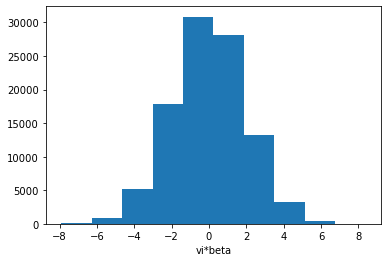

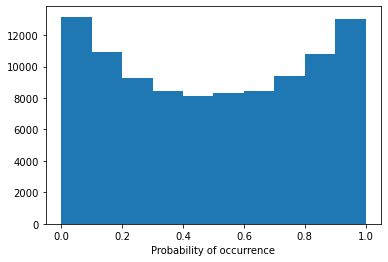

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:10,  2.43s/it]

Model 1/30, Test Accuracy: 0.7698

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:03,  2.26s/it]

Model 2/30, Test Accuracy: 0.7741

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:00,  2.23s/it]

Model 3/30, Test Accuracy: 0.7784

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:57,  2.23s/it]

Model 4/30, Test Accuracy: 0.7747

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:54,  2.19s/it]

Model 5/30, Test Accuracy: 0.7769

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:52,  2.18s/it]

Model 6/30, Test Accuracy: 0.7788

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:49,  2.15s/it]

Model 7/30, Test Accuracy: 0.7794

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:47,  2.16s/it]

Model 8/30, Test Accuracy: 0.7742

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:45,  2.17s/it]

Model 9/30, Test Accuracy: 0.7741

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:21<00:43,  2.19s/it]

Model 10/30, Test Accuracy: 0.7781

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:41,  2.16s/it]

Model 11/30, Test Accuracy: 0.7716

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:38,  2.16s/it]

Model 12/30, Test Accuracy: 0.7770

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:36,  2.13s/it]

Model 13/30, Test Accuracy: 0.7806

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:34,  2.14s/it]

Model 14/30, Test Accuracy: 0.7741

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:32<00:32,  2.15s/it]

Model 15/30, Test Accuracy: 0.7770

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:34<00:29,  2.12s/it]

Model 16/30, Test Accuracy: 0.7718

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:36<00:27,  2.13s/it]

Model 17/30, Test Accuracy: 0.7744

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:38<00:25,  2.13s/it]

Model 18/30, Test Accuracy: 0.7728

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:23,  2.17s/it]

Model 19/30, Test Accuracy: 0.7760

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:43<00:21,  2.18s/it]

Model 20/30, Test Accuracy: 0.7700

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:45<00:19,  2.17s/it]

Model 21/30, Test Accuracy: 0.7761

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:47<00:17,  2.16s/it]

Model 22/30, Test Accuracy: 0.7763

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:49<00:15,  2.15s/it]

Model 23/30, Test Accuracy: 0.7714

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:52<00:12,  2.16s/it]

Model 24/30, Test Accuracy: 0.7774

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:54<00:10,  2.17s/it]

Model 25/30, Test Accuracy: 0.7738

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:56<00:08,  2.17s/it]

Model 26/30, Test Accuracy: 0.7702

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:58<00:06,  2.14s/it]

Model 27/30, Test Accuracy: 0.7647

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:00<00:04,  2.14s/it]

Model 28/30, Test Accuracy: 0.7730

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:02<00:02,  2.14s/it]

Model 29/30, Test Accuracy: 0.7723

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:04<00:00,  2.16s/it]

Model 30/30, Test Accuracy: 0.7722
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq20_var0.25_beta_var0.4.pkl


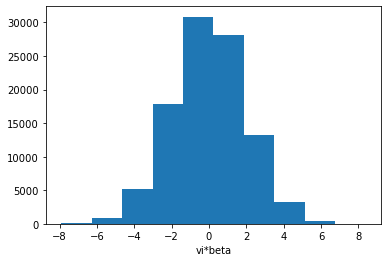

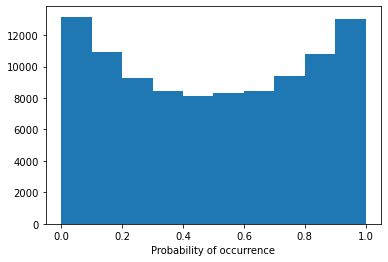

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:04,  2.21s/it]

Model 1/30, Test Accuracy: 0.7589

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:00,  2.16s/it]

Model 2/30, Test Accuracy: 0.7660

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:58,  2.17s/it]

Model 3/30, Test Accuracy: 0.7666

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:56,  2.18s/it]

Model 4/30, Test Accuracy: 0.7636

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:54,  2.18s/it]

Model 5/30, Test Accuracy: 0.7645

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:52,  2.20s/it]

Model 6/30, Test Accuracy: 0.7661

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:50,  2.19s/it]

Model 7/30, Test Accuracy: 0.7673

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:48,  2.19s/it]

Model 8/30, Test Accuracy: 0.7657

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:46,  2.20s/it]

Model 9/30, Test Accuracy: 0.7662

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:21<00:44,  2.22s/it]

Model 10/30, Test Accuracy: 0.7670

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:41,  2.21s/it]

Model 11/30, Test Accuracy: 0.7600

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:39,  2.20s/it]

Model 12/30, Test Accuracy: 0.7642

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:37,  2.21s/it]

Model 13/30, Test Accuracy: 0.7661

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:35,  2.22s/it]

Model 14/30, Test Accuracy: 0.7632

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:33,  2.22s/it]

Model 15/30, Test Accuracy: 0.7673

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:30,  2.20s/it]

Model 16/30, Test Accuracy: 0.7599

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:28,  2.22s/it]

Model 17/30, Test Accuracy: 0.7631

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:26,  2.21s/it]

Model 18/30, Test Accuracy: 0.7655

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:24,  2.23s/it]

Model 19/30, Test Accuracy: 0.7668

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:44<00:22,  2.25s/it]

Model 20/30, Test Accuracy: 0.7597

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:46<00:20,  2.24s/it]

Model 21/30, Test Accuracy: 0.7666

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:18,  2.25s/it]

Model 22/30, Test Accuracy: 0.7654

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:50<00:15,  2.23s/it]

Model 23/30, Test Accuracy: 0.7601

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:53<00:13,  2.24s/it]

Model 24/30, Test Accuracy: 0.7675

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:55<00:11,  2.27s/it]

Model 25/30, Test Accuracy: 0.7625

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:57<00:09,  2.34s/it]

Model 26/30, Test Accuracy: 0.7602

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:00<00:06,  2.31s/it]

Model 27/30, Test Accuracy: 0.7559

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:02<00:04,  2.28s/it]

Model 28/30, Test Accuracy: 0.7644

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:04<00:02,  2.26s/it]

Model 29/30, Test Accuracy: 0.7640

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.23s/it]

Model 30/30, Test Accuracy: 0.7640
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq1_var0.25_beta_var0.4.pkl


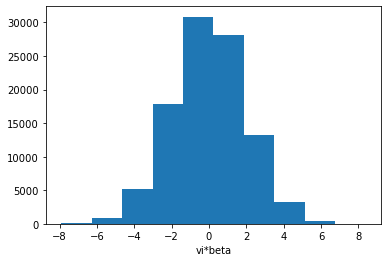

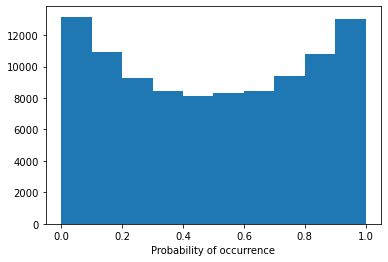

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:04,  2.22s/it]

Model 1/30, Test Accuracy: 0.7670

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:00,  2.18s/it]

Model 2/30, Test Accuracy: 0.7731

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:00,  2.23s/it]

Model 3/30, Test Accuracy: 0.7752

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:59,  2.27s/it]

Model 4/30, Test Accuracy: 0.7723

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:56,  2.26s/it]

Model 5/30, Test Accuracy: 0.7716

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.28s/it]

Model 6/30, Test Accuracy: 0.7757

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:52,  2.26s/it]

Model 7/30, Test Accuracy: 0.7759

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:50,  2.28s/it]

Model 8/30, Test Accuracy: 0.7731

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:48,  2.30s/it]

Model 9/30, Test Accuracy: 0.7729

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:45,  2.30s/it]

Model 10/30, Test Accuracy: 0.7753

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:43,  2.27s/it]

Model 11/30, Test Accuracy: 0.7681

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:40,  2.26s/it]

Model 12/30, Test Accuracy: 0.7747

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:38,  2.27s/it]

Model 13/30, Test Accuracy: 0.7754

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:36,  2.29s/it]

Model 14/30, Test Accuracy: 0.7708

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:34,  2.28s/it]

Model 15/30, Test Accuracy: 0.7734

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:31,  2.25s/it]

Model 16/30, Test Accuracy: 0.7687

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:38<00:29,  2.26s/it]

Model 17/30, Test Accuracy: 0.7729

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:40<00:26,  2.23s/it]

Model 18/30, Test Accuracy: 0.7722

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:42<00:24,  2.24s/it]

Model 19/30, Test Accuracy: 0.7742

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:45<00:22,  2.25s/it]

Model 20/30, Test Accuracy: 0.7681

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:47<00:20,  2.23s/it]

Model 21/30, Test Accuracy: 0.7755

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:49<00:17,  2.24s/it]

Model 22/30, Test Accuracy: 0.7739

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:51<00:15,  2.23s/it]

Model 23/30, Test Accuracy: 0.7687

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:54<00:13,  2.25s/it]

Model 24/30, Test Accuracy: 0.7764

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:56<00:11,  2.27s/it]

Model 25/30, Test Accuracy: 0.7701

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:58<00:09,  2.28s/it]

Model 26/30, Test Accuracy: 0.7678

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:00<00:06,  2.26s/it]

Model 27/30, Test Accuracy: 0.7627

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:03<00:04,  2.27s/it]

Model 28/30, Test Accuracy: 0.7705

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:05<00:02,  2.27s/it]

Model 29/30, Test Accuracy: 0.7702

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:07<00:00,  2.26s/it]

Model 30/30, Test Accuracy: 0.7719
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq3_var0.25_beta_var0.4.pkl


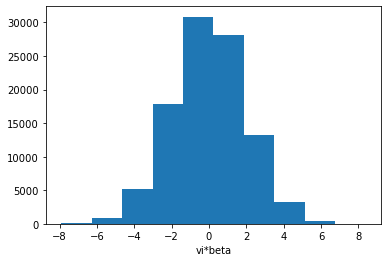

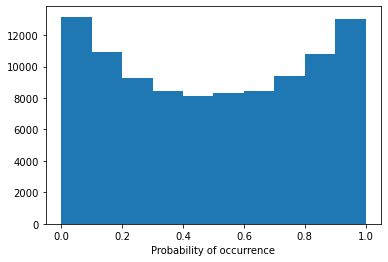

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:03,  2.18s/it]

Model 1/30, Test Accuracy: 0.7682

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:03,  2.26s/it]

Model 2/30, Test Accuracy: 0.7747

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:01,  2.29s/it]

Model 3/30, Test Accuracy: 0.7755

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<00:59,  2.30s/it]

Model 4/30, Test Accuracy: 0.7706

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:57,  2.29s/it]

Model 5/30, Test Accuracy: 0.7742

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:55,  2.31s/it]

Model 6/30, Test Accuracy: 0.7772

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:16<00:52,  2.30s/it]

Model 7/30, Test Accuracy: 0.7757

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:51,  2.33s/it]

Model 8/30, Test Accuracy: 0.7728

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:49,  2.34s/it]

Model 9/30, Test Accuracy: 0.7732

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:46,  2.32s/it]

Model 10/30, Test Accuracy: 0.7754

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:44,  2.34s/it]

Model 11/30, Test Accuracy: 0.7694

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.32s/it]

Model 12/30, Test Accuracy: 0.7752

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:39,  2.33s/it]

Model 13/30, Test Accuracy: 0.7782

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.35s/it]

Model 14/30, Test Accuracy: 0.7726

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:35,  2.35s/it]

Model 15/30, Test Accuracy: 0.7750

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:37<00:32,  2.34s/it]

Model 16/30, Test Accuracy: 0.7710

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:31,  2.41s/it]

Model 17/30, Test Accuracy: 0.7747

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:42<00:28,  2.38s/it]

Model 18/30, Test Accuracy: 0.7731

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:26,  2.38s/it]

Model 19/30, Test Accuracy: 0.7744

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.37s/it]

Model 20/30, Test Accuracy: 0.7687

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:49<00:21,  2.35s/it]

Model 21/30, Test Accuracy: 0.7735

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:51<00:18,  2.35s/it]

Model 22/30, Test Accuracy: 0.7750

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:53<00:16,  2.32s/it]

Model 23/30, Test Accuracy: 0.7694

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:56<00:14,  2.34s/it]

Model 24/30, Test Accuracy: 0.7765

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:58<00:11,  2.36s/it]

Model 25/30, Test Accuracy: 0.7709

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:00<00:09,  2.37s/it]

Model 26/30, Test Accuracy: 0.7671

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:03<00:07,  2.34s/it]

Model 27/30, Test Accuracy: 0.7643

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:05<00:04,  2.31s/it]

Model 28/30, Test Accuracy: 0.7717

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:07<00:02,  2.31s/it]

Model 29/30, Test Accuracy: 0.7722

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:09<00:00,  2.33s/it]

Model 30/30, Test Accuracy: 0.7713
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq5_var0.25_beta_var0.4.pkl


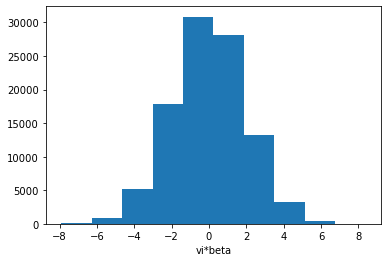

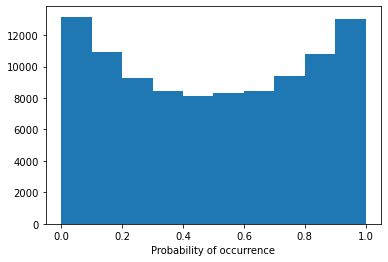

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:03,  2.17s/it]

Model 1/30, Test Accuracy: 0.7688

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:03,  2.25s/it]

Model 2/30, Test Accuracy: 0.7741

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:01,  2.29s/it]

Model 3/30, Test Accuracy: 0.7768

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<00:59,  2.30s/it]

Model 4/30, Test Accuracy: 0.7726

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:56,  2.27s/it]

Model 5/30, Test Accuracy: 0.7754

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.27s/it]

Model 6/30, Test Accuracy: 0.7784

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:51,  2.26s/it]

Model 7/30, Test Accuracy: 0.7782

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:50,  2.28s/it]

Model 8/30, Test Accuracy: 0.7734

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:48,  2.30s/it]

Model 9/30, Test Accuracy: 0.7736

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:45,  2.28s/it]

Model 10/30, Test Accuracy: 0.7761

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:44,  2.32s/it]

Model 11/30, Test Accuracy: 0.7701

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.31s/it]

Model 12/30, Test Accuracy: 0.7755

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:39,  2.32s/it]

Model 13/30, Test Accuracy: 0.7779

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.33s/it]

Model 14/30, Test Accuracy: 0.7736

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:35,  2.34s/it]

Model 15/30, Test Accuracy: 0.7760

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:32,  2.32s/it]

Model 16/30, Test Accuracy: 0.7715

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.33s/it]

Model 17/30, Test Accuracy: 0.7743

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:27,  2.31s/it]

Model 18/30, Test Accuracy: 0.7723

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:43<00:25,  2.34s/it]

Model 19/30, Test Accuracy: 0.7758

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.34s/it]

Model 20/30, Test Accuracy: 0.7691

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:48<00:20,  2.32s/it]

Model 21/30, Test Accuracy: 0.7753

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:50<00:18,  2.32s/it]

Model 22/30, Test Accuracy: 0.7755

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:53<00:16,  2.31s/it]

Model 23/30, Test Accuracy: 0.7696

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:55<00:13,  2.33s/it]

Model 24/30, Test Accuracy: 0.7773

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:57<00:11,  2.34s/it]

Model 25/30, Test Accuracy: 0.7723

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:00<00:09,  2.34s/it]

Model 26/30, Test Accuracy: 0.7689

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:02<00:07,  2.34s/it]

Model 27/30, Test Accuracy: 0.7653

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:04<00:04,  2.34s/it]

Model 28/30, Test Accuracy: 0.7721

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:07<00:02,  2.33s/it]

Model 29/30, Test Accuracy: 0.7721

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:09<00:00,  2.31s/it]

Model 30/30, Test Accuracy: 0.7731
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq7_var0.25_beta_var0.4.pkl


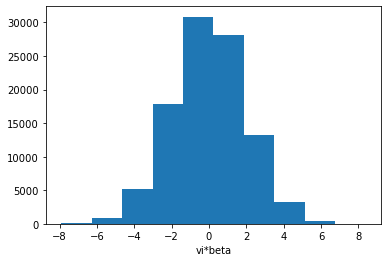

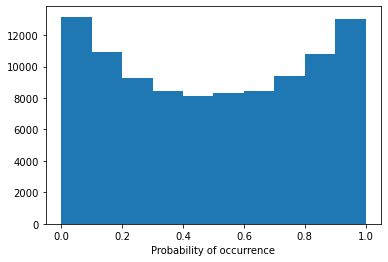

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:04,  2.21s/it]

Model 1/30, Test Accuracy: 0.7701

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:03,  2.27s/it]

Model 2/30, Test Accuracy: 0.7749

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:01,  2.29s/it]

Model 3/30, Test Accuracy: 0.7781

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<00:59,  2.29s/it]

Model 4/30, Test Accuracy: 0.7732

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:56,  2.25s/it]

Model 5/30, Test Accuracy: 0.7772

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.27s/it]

Model 6/30, Test Accuracy: 0.7785

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:51,  2.26s/it]

Model 7/30, Test Accuracy: 0.7785

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:51,  2.34s/it]

Model 8/30, Test Accuracy: 0.7741

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:49,  2.34s/it]

Model 9/30, Test Accuracy: 0.7734

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:46,  2.33s/it]

Model 10/30, Test Accuracy: 0.7778

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:44,  2.32s/it]

Model 11/30, Test Accuracy: 0.7718

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.29s/it]

Model 12/30, Test Accuracy: 0.7756

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:39,  2.31s/it]

Model 13/30, Test Accuracy: 0.7782

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.31s/it]

Model 14/30, Test Accuracy: 0.7746

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:34,  2.32s/it]

Model 15/30, Test Accuracy: 0.7770

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:32,  2.31s/it]

Model 16/30, Test Accuracy: 0.7719

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.32s/it]

Model 17/30, Test Accuracy: 0.7744

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:27,  2.30s/it]

Model 18/30, Test Accuracy: 0.7732

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:43<00:25,  2.31s/it]

Model 19/30, Test Accuracy: 0.7750

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.32s/it]

Model 20/30, Test Accuracy: 0.7688

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:48<00:20,  2.29s/it]

Model 21/30, Test Accuracy: 0.7758

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:50<00:18,  2.29s/it]

Model 22/30, Test Accuracy: 0.7762

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:52<00:15,  2.27s/it]

Model 23/30, Test Accuracy: 0.7703

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:55<00:13,  2.31s/it]

Model 24/30, Test Accuracy: 0.7782

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:57<00:11,  2.32s/it]

Model 25/30, Test Accuracy: 0.7727

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:59<00:09,  2.33s/it]

Model 26/30, Test Accuracy: 0.7708

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:02<00:06,  2.31s/it]

Model 27/30, Test Accuracy: 0.7649

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:04<00:04,  2.28s/it]

Model 28/30, Test Accuracy: 0.7738

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:06<00:02,  2.29s/it]

Model 29/30, Test Accuracy: 0.7731

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:09<00:00,  2.30s/it]

Model 30/30, Test Accuracy: 0.7737
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq10_var0.25_beta_var0.4.pkl


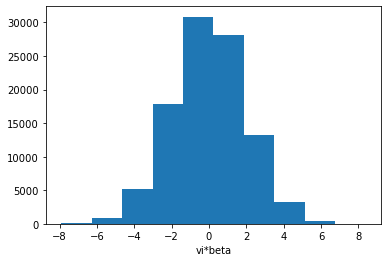

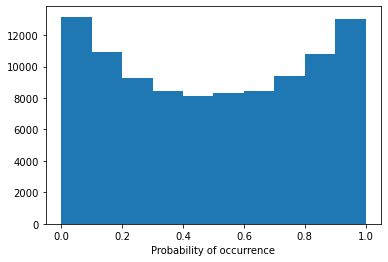

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:04,  2.22s/it]

Model 1/30, Test Accuracy: 0.7702

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:04,  2.29s/it]

Model 2/30, Test Accuracy: 0.7745

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:02,  2.33s/it]

Model 3/30, Test Accuracy: 0.7777

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:00,  2.31s/it]

Model 4/30, Test Accuracy: 0.7753

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:56,  2.28s/it]

Model 5/30, Test Accuracy: 0.7770

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.29s/it]

Model 6/30, Test Accuracy: 0.7786

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:52,  2.27s/it]

Model 7/30, Test Accuracy: 0.7790

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:50,  2.29s/it]

Model 8/30, Test Accuracy: 0.7749

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:48,  2.31s/it]

Model 9/30, Test Accuracy: 0.7748

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:46,  2.30s/it]

Model 10/30, Test Accuracy: 0.7777

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:44,  2.33s/it]

Model 11/30, Test Accuracy: 0.7721

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.31s/it]

Model 12/30, Test Accuracy: 0.7774

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:39,  2.32s/it]

Model 13/30, Test Accuracy: 0.7800

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.32s/it]

Model 14/30, Test Accuracy: 0.7751

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:34,  2.32s/it]

Model 15/30, Test Accuracy: 0.7773

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:32,  2.32s/it]

Model 16/30, Test Accuracy: 0.7718

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.32s/it]

Model 17/30, Test Accuracy: 0.7750

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:27,  2.29s/it]

Model 18/30, Test Accuracy: 0.7729

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:43<00:25,  2.31s/it]

Model 19/30, Test Accuracy: 0.7748

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:22,  2.30s/it]

Model 20/30, Test Accuracy: 0.7700

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:48<00:20,  2.29s/it]

Model 21/30, Test Accuracy: 0.7764

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:50<00:18,  2.29s/it]

Model 22/30, Test Accuracy: 0.7765

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:52<00:15,  2.28s/it]

Model 23/30, Test Accuracy: 0.7717

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:55<00:13,  2.29s/it]

Model 24/30, Test Accuracy: 0.7786

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:57<00:11,  2.30s/it]

Model 25/30, Test Accuracy: 0.7729

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:59<00:09,  2.31s/it]

Model 26/30, Test Accuracy: 0.7712

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:02<00:06,  2.29s/it]

Model 27/30, Test Accuracy: 0.7651

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:04<00:04,  2.29s/it]

Model 28/30, Test Accuracy: 0.7740

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:06<00:02,  2.32s/it]

Model 29/30, Test Accuracy: 0.7723

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:09<00:00,  2.31s/it]

Model 30/30, Test Accuracy: 0.7740
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq15_var0.25_beta_var0.4.pkl
Skipping training for epi_mean_ss100000_sq20_var0.25.pkl


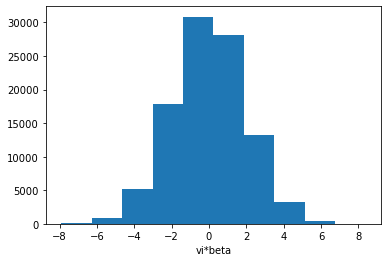

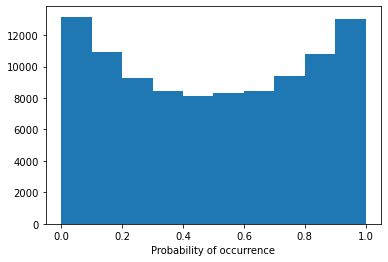

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 18.75it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4597

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4233

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4255

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:01, 17.74it/s]

Model 4/30, Test Accuracy: 0.5236

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5147

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.5965

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5042

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 14.06it/s]

Model 8/30, Test Accuracy: 0.5242

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5151

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5575

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:00<00:01, 15.65it/s]

Model 11/30, Test Accuracy: 0.4758

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5458

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5334

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.4907

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 16.56it/s]

Model 15/30, Test Accuracy: 0.5730

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4472

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4094

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.3899

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 17.39it/s]

Model 19/30, Test Accuracy: 0.5660

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4442

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5949

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4225

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:01<00:00, 17.77it/s]

Model 23/30, Test Accuracy: 0.4726

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5786

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4814

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4612

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:01<00:00, 16.95it/s]

Model 27/30, Test Accuracy: 0.4447

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4823

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4968

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4833
Predictions saved to epi_model_limitation/epi_mean_ss10_sq20_var0.5_beta_var0.4.pkl


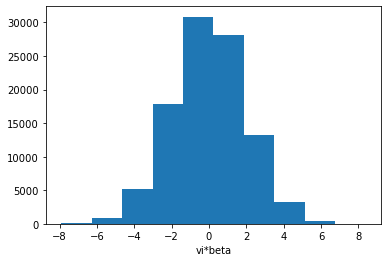

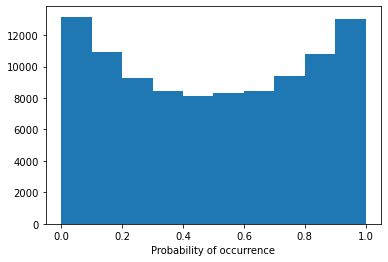

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 17.27it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4619

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4273

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4370

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:01, 13.76it/s]

Model 4/30, Test Accuracy: 0.5275

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5210

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.6133

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5158

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 15.69it/s]

Model 8/30, Test Accuracy: 0.5385

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5281

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5709

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4827

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:00<00:00, 16.70it/s]

Model 12/30, Test Accuracy: 0.5577

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5330

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.5004

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5876

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 17.18it/s]

Model 16/30, Test Accuracy: 0.4606

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4214

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4001

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5783

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 14.18it/s]

Model 20/30, Test Accuracy: 0.4527

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.6055

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4225

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:01<00:00, 15.68it/s]

Model 23/30, Test Accuracy: 0.4748

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5956

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4855

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4686

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:01<00:00, 15.76it/s]

Model 27/30, Test Accuracy: 0.4437

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4980

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4978

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4874
Predictions saved to epi_model_limitation/epi_mean_ss100_sq20_var0.5_beta_var0.4.pkl


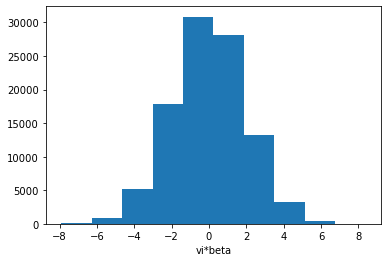

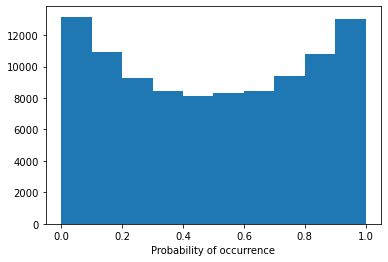

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:02, 12.40it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4669

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4350

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:00<00:02, 12.63it/s]

Model 3/30, Test Accuracy: 0.4404

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5313

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5234

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:00<00:01, 13.04it/s]

Model 6/30, Test Accuracy: 0.6191

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5155

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5455

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 13.10it/s]

Model 9/30, Test Accuracy: 0.5299

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5761

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4847

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:00<00:01, 13.12it/s]

Model 12/30, Test Accuracy: 0.5633

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5417

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:01<00:01, 11.58it/s]

Model 14/30, Test Accuracy: 0.5042

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5895

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4693

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:01, 11.93it/s]

Model 17/30, Test Accuracy: 0.4282

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.3996

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5808

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 12.37it/s]

Model 20/30, Test Accuracy: 0.4610

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.6183

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4278

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:01<00:00, 12.45it/s]

Model 23/30, Test Accuracy: 0.4789

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.6010

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4904

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:02<00:00, 11.54it/s]

Model 26/30, Test Accuracy: 0.4738

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4492

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4976

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 12.06it/s]


Model 29/30, Test Accuracy: 0.5056

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4956
Predictions saved to epi_model_limitation/epi_mean_ss1000_sq20_var0.5_beta_var0.4.pkl


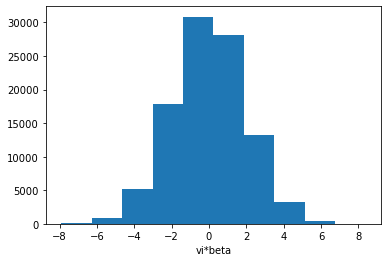

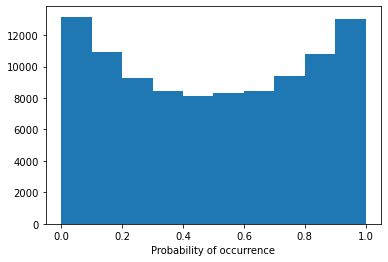

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:08,  3.27it/s]

Model 1/30, Test Accuracy: 0.5482

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:10,  2.75it/s]

Model 2/30, Test Accuracy: 0.5391

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:01<00:09,  2.90it/s]

Model 3/30, Test Accuracy: 0.5437

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:01<00:08,  3.03it/s]

Model 4/30, Test Accuracy: 0.5976

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:01<00:08,  3.12it/s]

Model 5/30, Test Accuracy: 0.5806

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:01<00:07,  3.14it/s]

Model 6/30, Test Accuracy: 0.6974

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:02<00:07,  3.18it/s]

Model 7/30, Test Accuracy: 0.6017

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:02<00:07,  2.99it/s]

Model 8/30, Test Accuracy: 0.6266

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:02<00:06,  3.07it/s]

Model 9/30, Test Accuracy: 0.5986

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:03<00:06,  3.13it/s]

Model 10/30, Test Accuracy: 0.6464

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:03<00:06,  2.96it/s]

Model 11/30, Test Accuracy: 0.5569

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:03<00:05,  3.03it/s]

Model 12/30, Test Accuracy: 0.6310

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:04<00:05,  3.00it/s]

Model 13/30, Test Accuracy: 0.6492

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:04<00:05,  3.04it/s]

Model 14/30, Test Accuracy: 0.5675

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:04<00:04,  3.11it/s]

Model 15/30, Test Accuracy: 0.6514

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:05<00:04,  2.93it/s]

Model 16/30, Test Accuracy: 0.5657

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:05<00:04,  3.02it/s]

Model 17/30, Test Accuracy: 0.5171

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:05<00:03,  3.09it/s]

Model 18/30, Test Accuracy: 0.4620

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:06<00:03,  2.92it/s]

Model 19/30, Test Accuracy: 0.6542

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:06<00:03,  3.01it/s]

Model 20/30, Test Accuracy: 0.5153

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:06<00:02,  3.05it/s]

Model 21/30, Test Accuracy: 0.6966

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:07<00:02,  3.08it/s]

Model 22/30, Test Accuracy: 0.5068

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:07<00:02,  3.08it/s]

Model 23/30, Test Accuracy: 0.5243

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:07<00:01,  3.09it/s]

Model 24/30, Test Accuracy: 0.6916

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:08<00:01,  2.84it/s]

Model 25/30, Test Accuracy: 0.5726

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:08<00:01,  2.95it/s]

Model 26/30, Test Accuracy: 0.5489

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:09<00:01,  2.80it/s]

Model 27/30, Test Accuracy: 0.4930

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:09<00:00,  2.90it/s]

Model 28/30, Test Accuracy: 0.5868

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:09<00:00,  2.99it/s]

Model 29/30, Test Accuracy: 0.5918

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:09<00:00,  3.01it/s]

Model 30/30, Test Accuracy: 0.5736
Predictions saved to epi_model_limitation/epi_mean_ss10000_sq20_var0.5_beta_var0.4.pkl


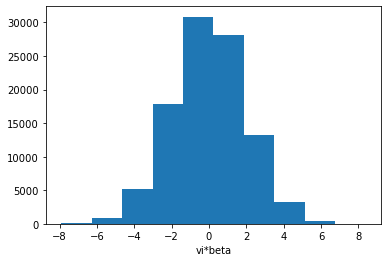

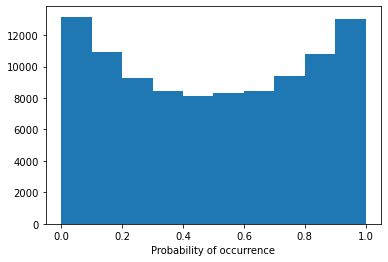

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:26,  1.11it/s]

Model 1/30, Test Accuracy: 0.6914

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:01<00:23,  1.18it/s]

Model 2/30, Test Accuracy: 0.7225

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:02<00:23,  1.15it/s]

Model 3/30, Test Accuracy: 0.7258

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:03<00:22,  1.13it/s]

Model 4/30, Test Accuracy: 0.7216

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:04<00:21,  1.16it/s]

Model 5/30, Test Accuracy: 0.7032

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:05<00:20,  1.15it/s]

Model 6/30, Test Accuracy: 0.7627

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:06<00:20,  1.14it/s]

Model 7/30, Test Accuracy: 0.7356

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:06<00:18,  1.17it/s]

Model 8/30, Test Accuracy: 0.7370

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:07<00:18,  1.15it/s]

Model 9/30, Test Accuracy: 0.7171

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:08<00:17,  1.14it/s]

Model 10/30, Test Accuracy: 0.7451

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:09<00:16,  1.16it/s]

Model 11/30, Test Accuracy: 0.6854

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:10<00:15,  1.15it/s]

Model 12/30, Test Accuracy: 0.7321

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:11<00:15,  1.12it/s]

Model 13/30, Test Accuracy: 0.7591

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:12<00:13,  1.14it/s]

Model 14/30, Test Accuracy: 0.7023

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:13<00:12,  1.17it/s]

Model 15/30, Test Accuracy: 0.7426

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:13<00:12,  1.13it/s]

Model 16/30, Test Accuracy: 0.7105

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:14<00:11,  1.12it/s]

Model 17/30, Test Accuracy: 0.6932

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:15<00:10,  1.15it/s]

Model 18/30, Test Accuracy: 0.6817

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:16<00:09,  1.14it/s]

Model 19/30, Test Accuracy: 0.7467

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:17<00:08,  1.14it/s]

Model 20/30, Test Accuracy: 0.6614

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:18<00:07,  1.16it/s]

Model 21/30, Test Accuracy: 0.7574

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:19<00:07,  1.14it/s]

Model 22/30, Test Accuracy: 0.7013

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:20<00:06,  1.13it/s]

Model 23/30, Test Accuracy: 0.6679

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:20<00:05,  1.15it/s]

Model 24/30, Test Accuracy: 0.7617

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:21<00:04,  1.13it/s]

Model 25/30, Test Accuracy: 0.6986

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:22<00:03,  1.13it/s]

Model 26/30, Test Accuracy: 0.6980

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:23<00:02,  1.15it/s]

Model 27/30, Test Accuracy: 0.6340

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:24<00:01,  1.14it/s]

Model 28/30, Test Accuracy: 0.7227

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:25<00:00,  1.13it/s]

Model 29/30, Test Accuracy: 0.7225

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]

Model 30/30, Test Accuracy: 0.7166
Predictions saved to epi_model_limitation/epi_mean_ss30000_sq20_var0.5_beta_var0.4.pkl


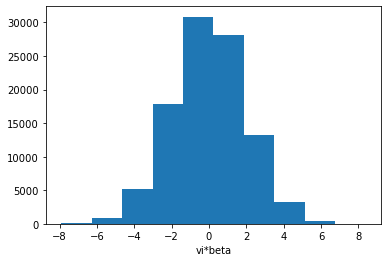

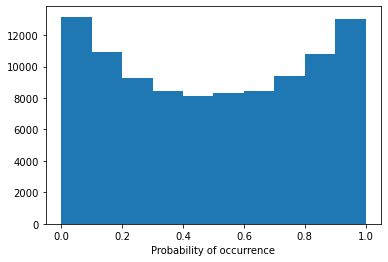

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:43,  1.49s/it]

Model 1/30, Test Accuracy: 0.7443

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:02<00:41,  1.49s/it]

Model 2/30, Test Accuracy: 0.7632

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:04<00:40,  1.49s/it]

Model 3/30, Test Accuracy: 0.7680

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:05<00:39,  1.50s/it]

Model 4/30, Test Accuracy: 0.7574

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:07<00:37,  1.49s/it]

Model 5/30, Test Accuracy: 0.7549

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:09<00:36,  1.51s/it]

Model 6/30, Test Accuracy: 0.7751

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:10<00:33,  1.47s/it]

Model 7/30, Test Accuracy: 0.7692

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:11<00:32,  1.50s/it]

Model 8/30, Test Accuracy: 0.7640

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:13<00:30,  1.46s/it]

Model 9/30, Test Accuracy: 0.7629

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:14<00:29,  1.48s/it]

Model 10/30, Test Accuracy: 0.7690

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:16<00:27,  1.45s/it]

Model 11/30, Test Accuracy: 0.7393

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:17<00:26,  1.47s/it]

Model 12/30, Test Accuracy: 0.7623

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:19<00:24,  1.44s/it]

Model 13/30, Test Accuracy: 0.7745

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:20<00:23,  1.46s/it]

Model 14/30, Test Accuracy: 0.7522

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:22<00:21,  1.45s/it]

Model 15/30, Test Accuracy: 0.7678

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:23<00:20,  1.46s/it]

Model 16/30, Test Accuracy: 0.7543

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:24<00:18,  1.45s/it]

Model 17/30, Test Accuracy: 0.7534

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:26<00:17,  1.46s/it]

Model 18/30, Test Accuracy: 0.7565

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:27<00:15,  1.45s/it]

Model 19/30, Test Accuracy: 0.7700

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:29<00:14,  1.45s/it]

Model 20/30, Test Accuracy: 0.7391

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:30<00:13,  1.45s/it]

Model 21/30, Test Accuracy: 0.7699

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:32<00:11,  1.45s/it]

Model 22/30, Test Accuracy: 0.7581

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:33<00:10,  1.45s/it]

Model 23/30, Test Accuracy: 0.7459

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:35<00:08,  1.46s/it]

Model 24/30, Test Accuracy: 0.7728

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:36<00:07,  1.46s/it]

Model 25/30, Test Accuracy: 0.7489

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:38<00:05,  1.45s/it]

Model 26/30, Test Accuracy: 0.7498

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:39<00:04,  1.45s/it]

Model 27/30, Test Accuracy: 0.7202

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:40<00:02,  1.45s/it]

Model 28/30, Test Accuracy: 0.7608

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:42<00:01,  1.46s/it]

Model 29/30, Test Accuracy: 0.7580

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:43<00:00,  1.46s/it]

Model 30/30, Test Accuracy: 0.7591
Predictions saved to epi_model_limitation/epi_mean_ss50000_sq20_var0.5_beta_var0.4.pkl


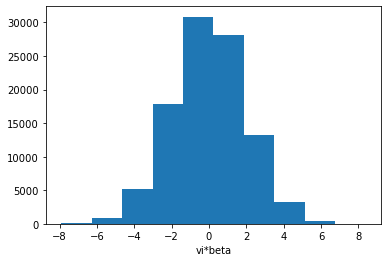

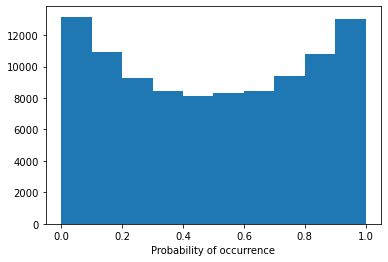

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:56,  1.96s/it]

Model 1/30, Test Accuracy: 0.7651

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:03<00:55,  1.99s/it]

Model 2/30, Test Accuracy: 0.7720

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:54,  2.01s/it]

Model 3/30, Test Accuracy: 0.7744

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:07<00:51,  1.96s/it]

Model 4/30, Test Accuracy: 0.7687

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:09<00:48,  1.94s/it]

Model 5/30, Test Accuracy: 0.7736

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:11<00:46,  1.95s/it]

Model 6/30, Test Accuracy: 0.7782

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:13<00:44,  1.94s/it]

Model 7/30, Test Accuracy: 0.7756

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:15<00:42,  1.93s/it]

Model 8/30, Test Accuracy: 0.7703

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:17<00:40,  1.94s/it]

Model 9/30, Test Accuracy: 0.7712

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:19<00:39,  1.96s/it]

Model 10/30, Test Accuracy: 0.7745

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:21<00:37,  1.98s/it]

Model 11/30, Test Accuracy: 0.7634

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:23<00:35,  1.98s/it]

Model 12/30, Test Accuracy: 0.7725

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:25<00:33,  1.99s/it]

Model 13/30, Test Accuracy: 0.7783

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:27<00:33,  2.07s/it]

Model 14/30, Test Accuracy: 0.7713

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:29<00:30,  2.04s/it]

Model 15/30, Test Accuracy: 0.7742

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:31<00:28,  2.04s/it]

Model 16/30, Test Accuracy: 0.7671

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:33<00:26,  2.05s/it]

Model 17/30, Test Accuracy: 0.7703

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:35<00:24,  2.01s/it]

Model 18/30, Test Accuracy: 0.7692

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:37<00:22,  2.00s/it]

Model 19/30, Test Accuracy: 0.7742

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:39<00:20,  2.02s/it]

Model 20/30, Test Accuracy: 0.7659

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:41<00:18,  2.02s/it]

Model 21/30, Test Accuracy: 0.7732

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:43<00:16,  2.01s/it]

Model 22/30, Test Accuracy: 0.7727

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:45<00:14,  2.03s/it]

Model 23/30, Test Accuracy: 0.7665

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:48<00:12,  2.04s/it]

Model 24/30, Test Accuracy: 0.7762

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:49<00:10,  2.02s/it]

Model 25/30, Test Accuracy: 0.7695

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:51<00:07,  1.99s/it]

Model 26/30, Test Accuracy: 0.7652

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:53<00:06,  2.02s/it]

Model 27/30, Test Accuracy: 0.7569

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:55<00:04,  2.01s/it]

Model 28/30, Test Accuracy: 0.7711

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:58<00:02,  2.04s/it]

Model 29/30, Test Accuracy: 0.7707

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:00<00:00,  2.00s/it]

Model 30/30, Test Accuracy: 0.7689
Predictions saved to epi_model_limitation/epi_mean_ss70000_sq20_var0.5_beta_var0.4.pkl


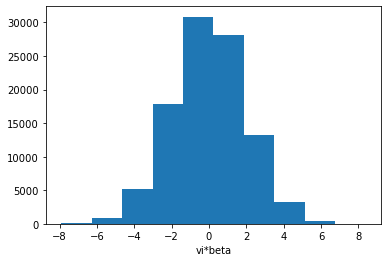

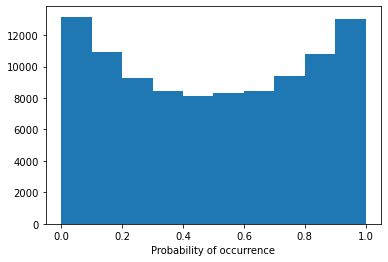

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:08,  2.35s/it]

Model 1/30, Test Accuracy: 0.7668

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:04,  2.29s/it]

Model 2/30, Test Accuracy: 0.7733

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:01,  2.29s/it]

Model 3/30, Test Accuracy: 0.7763

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<00:59,  2.28s/it]

Model 4/30, Test Accuracy: 0.7730

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:55,  2.24s/it]

Model 5/30, Test Accuracy: 0.7736

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.25s/it]

Model 6/30, Test Accuracy: 0.7767

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:51,  2.23s/it]

Model 7/30, Test Accuracy: 0.7765

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:49,  2.26s/it]

Model 8/30, Test Accuracy: 0.7730

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:47,  2.29s/it]

Model 9/30, Test Accuracy: 0.7722

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:45,  2.28s/it]

Model 10/30, Test Accuracy: 0.7759

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:43,  2.26s/it]

Model 11/30, Test Accuracy: 0.7682

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.29s/it]

Model 12/30, Test Accuracy: 0.7742

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:38,  2.28s/it]

Model 13/30, Test Accuracy: 0.7779

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:36,  2.30s/it]

Model 14/30, Test Accuracy: 0.7723

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:34,  2.31s/it]

Model 15/30, Test Accuracy: 0.7763

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:32,  2.30s/it]

Model 16/30, Test Accuracy: 0.7695

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:31,  2.43s/it]

Model 17/30, Test Accuracy: 0.7722

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:28,  2.38s/it]

Model 18/30, Test Accuracy: 0.7722

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:43<00:26,  2.37s/it]

Model 19/30, Test Accuracy: 0.7752

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.36s/it]

Model 20/30, Test Accuracy: 0.7681

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:48<00:21,  2.35s/it]

Model 21/30, Test Accuracy: 0.7744

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:50<00:18,  2.32s/it]

Model 22/30, Test Accuracy: 0.7735

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:52<00:16,  2.30s/it]

Model 23/30, Test Accuracy: 0.7702

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:55<00:13,  2.32s/it]

Model 24/30, Test Accuracy: 0.7763

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:57<00:11,  2.33s/it]

Model 25/30, Test Accuracy: 0.7710

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:00<00:09,  2.34s/it]

Model 26/30, Test Accuracy: 0.7681

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:02<00:06,  2.30s/it]

Model 27/30, Test Accuracy: 0.7637

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:04<00:04,  2.30s/it]

Model 28/30, Test Accuracy: 0.7728

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:06<00:02,  2.29s/it]

Model 29/30, Test Accuracy: 0.7710

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:09<00:00,  2.31s/it]

Model 30/30, Test Accuracy: 0.7712
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq20_var0.5_beta_var0.4.pkl


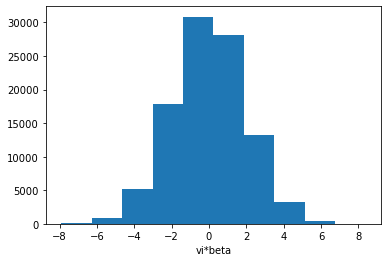

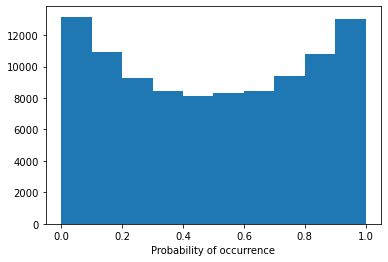

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:08,  2.36s/it]

Model 1/30, Test Accuracy: 0.7331

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:04,  2.32s/it]

Model 2/30, Test Accuracy: 0.7376

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:02,  2.32s/it]

Model 3/30, Test Accuracy: 0.7389

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:00,  2.34s/it]

Model 4/30, Test Accuracy: 0.7363

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:57,  2.30s/it]

Model 5/30, Test Accuracy: 0.7389

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:55,  2.31s/it]

Model 6/30, Test Accuracy: 0.7389

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:16<00:55,  2.40s/it]

Model 7/30, Test Accuracy: 0.7393

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:52,  2.38s/it]

Model 8/30, Test Accuracy: 0.7356

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:21<00:49,  2.36s/it]

Model 9/30, Test Accuracy: 0.7387

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:46,  2.33s/it]

Model 10/30, Test Accuracy: 0.7383

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:43,  2.29s/it]

Model 11/30, Test Accuracy: 0.7345

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.31s/it]

Model 12/30, Test Accuracy: 0.7385

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:39,  2.35s/it]

Model 13/30, Test Accuracy: 0.7389

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.37s/it]

Model 14/30, Test Accuracy: 0.7351

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:35<00:35,  2.36s/it]

Model 15/30, Test Accuracy: 0.7387

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:37<00:32,  2.33s/it]

Model 16/30, Test Accuracy: 0.7344

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.33s/it]

Model 17/30, Test Accuracy: 0.7354

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:42<00:27,  2.31s/it]

Model 18/30, Test Accuracy: 0.7356

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:25,  2.33s/it]

Model 19/30, Test Accuracy: 0.7387

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.36s/it]

Model 20/30, Test Accuracy: 0.7358

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:49<00:21,  2.36s/it]

Model 21/30, Test Accuracy: 0.7373

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:51<00:18,  2.37s/it]

Model 22/30, Test Accuracy: 0.7369

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:53<00:16,  2.35s/it]

Model 23/30, Test Accuracy: 0.7347

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:56<00:14,  2.37s/it]

Model 24/30, Test Accuracy: 0.7392

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:58<00:11,  2.38s/it]

Model 25/30, Test Accuracy: 0.7362

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:01<00:09,  2.38s/it]

Model 26/30, Test Accuracy: 0.7338

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:03<00:07,  2.37s/it]

Model 27/30, Test Accuracy: 0.7333

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:05<00:04,  2.38s/it]

Model 28/30, Test Accuracy: 0.7379

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:08<00:02,  2.37s/it]

Model 29/30, Test Accuracy: 0.7345

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:10<00:00,  2.35s/it]

Model 30/30, Test Accuracy: 0.7366
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq1_var0.5_beta_var0.4.pkl


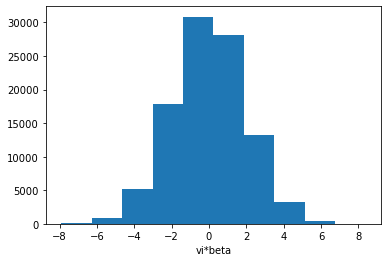

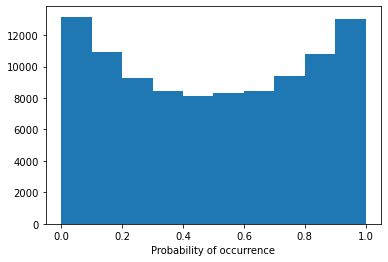

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:08,  2.37s/it]

Model 1/30, Test Accuracy: 0.7561

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:04,  2.32s/it]

Model 2/30, Test Accuracy: 0.7601

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:02,  2.32s/it]

Model 3/30, Test Accuracy: 0.7621

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:00,  2.34s/it]

Model 4/30, Test Accuracy: 0.7603

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:57,  2.32s/it]

Model 5/30, Test Accuracy: 0.7618

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:55,  2.32s/it]

Model 6/30, Test Accuracy: 0.7628

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:16<00:53,  2.33s/it]

Model 7/30, Test Accuracy: 0.7618

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:52,  2.37s/it]

Model 8/30, Test Accuracy: 0.7612

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:21<00:49,  2.37s/it]

Model 9/30, Test Accuracy: 0.7609

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:46,  2.34s/it]

Model 10/30, Test Accuracy: 0.7619

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:44,  2.36s/it]

Model 11/30, Test Accuracy: 0.7570

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:28<00:42,  2.34s/it]

Model 12/30, Test Accuracy: 0.7609

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:39,  2.34s/it]

Model 13/30, Test Accuracy: 0.7639

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.35s/it]

Model 14/30, Test Accuracy: 0.7574

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:35<00:35,  2.37s/it]

Model 15/30, Test Accuracy: 0.7617

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:37<00:32,  2.34s/it]

Model 16/30, Test Accuracy: 0.7581

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.35s/it]

Model 17/30, Test Accuracy: 0.7608

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:42<00:28,  2.34s/it]

Model 18/30, Test Accuracy: 0.7606

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:25,  2.36s/it]

Model 19/30, Test Accuracy: 0.7618

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.37s/it]

Model 20/30, Test Accuracy: 0.7557

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:49<00:21,  2.34s/it]

Model 21/30, Test Accuracy: 0.7609

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:51<00:18,  2.35s/it]

Model 22/30, Test Accuracy: 0.7609

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:53<00:16,  2.34s/it]

Model 23/30, Test Accuracy: 0.7600

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:56<00:14,  2.38s/it]

Model 24/30, Test Accuracy: 0.7622

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:58<00:11,  2.38s/it]

Model 25/30, Test Accuracy: 0.7590

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:01<00:09,  2.39s/it]

Model 26/30, Test Accuracy: 0.7571

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:03<00:07,  2.42s/it]

Model 27/30, Test Accuracy: 0.7544

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:06<00:04,  2.48s/it]

Model 28/30, Test Accuracy: 0.7585

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:08<00:02,  2.43s/it]

Model 29/30, Test Accuracy: 0.7613

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:11<00:00,  2.37s/it]

Model 30/30, Test Accuracy: 0.7597
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq3_var0.5_beta_var0.4.pkl


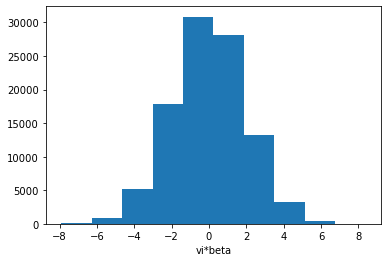

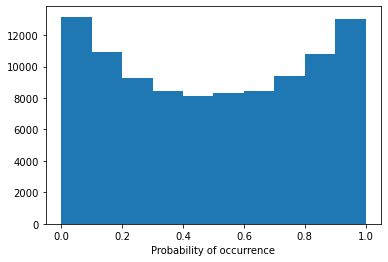

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:06,  2.30s/it]

Model 1/30, Test Accuracy: 0.7623

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:06,  2.36s/it]

Model 2/30, Test Accuracy: 0.7647

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:03,  2.36s/it]

Model 3/30, Test Accuracy: 0.7683

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:01,  2.37s/it]

Model 4/30, Test Accuracy: 0.7649

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:58,  2.33s/it]

Model 5/30, Test Accuracy: 0.7660

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:14<00:56,  2.34s/it]

Model 6/30, Test Accuracy: 0.7689

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:16<00:53,  2.31s/it]

Model 7/30, Test Accuracy: 0.7682

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:51,  2.34s/it]

Model 8/30, Test Accuracy: 0.7659

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:21<00:49,  2.34s/it]

Model 9/30, Test Accuracy: 0.7664

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:46,  2.34s/it]

Model 10/30, Test Accuracy: 0.7685

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:44,  2.35s/it]

Model 11/30, Test Accuracy: 0.7604

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:28<00:42,  2.34s/it]

Model 12/30, Test Accuracy: 0.7680

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:40,  2.36s/it]

Model 13/30, Test Accuracy: 0.7688

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.37s/it]

Model 14/30, Test Accuracy: 0.7666

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:35<00:35,  2.36s/it]

Model 15/30, Test Accuracy: 0.7672

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:37<00:32,  2.34s/it]

Model 16/30, Test Accuracy: 0.7636

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.34s/it]

Model 17/30, Test Accuracy: 0.7662

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:42<00:28,  2.34s/it]

Model 18/30, Test Accuracy: 0.7646

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:25,  2.36s/it]

Model 19/30, Test Accuracy: 0.7668

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.36s/it]

Model 20/30, Test Accuracy: 0.7628

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:49<00:20,  2.33s/it]

Model 21/30, Test Accuracy: 0.7661

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:51<00:18,  2.33s/it]

Model 22/30, Test Accuracy: 0.7678

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:53<00:16,  2.32s/it]

Model 23/30, Test Accuracy: 0.7632

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:56<00:13,  2.33s/it]

Model 24/30, Test Accuracy: 0.7683

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:58<00:11,  2.33s/it]

Model 25/30, Test Accuracy: 0.7633

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:00<00:09,  2.35s/it]

Model 26/30, Test Accuracy: 0.7624

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:03<00:07,  2.34s/it]

Model 27/30, Test Accuracy: 0.7599

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:05<00:04,  2.33s/it]

Model 28/30, Test Accuracy: 0.7647

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:07<00:02,  2.35s/it]

Model 29/30, Test Accuracy: 0.7650

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:10<00:00,  2.34s/it]

Model 30/30, Test Accuracy: 0.7660
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq5_var0.5_beta_var0.4.pkl


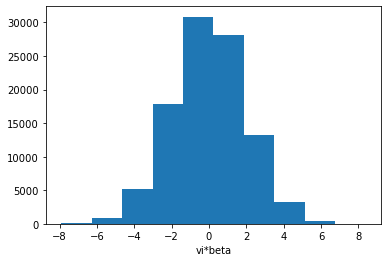

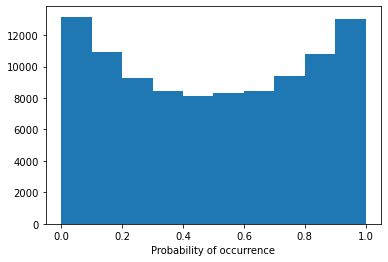

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:07,  2.32s/it]

Model 1/30, Test Accuracy: 0.7634

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:06,  2.37s/it]

Model 2/30, Test Accuracy: 0.7687

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:04,  2.38s/it]

Model 3/30, Test Accuracy: 0.7730

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:02,  2.40s/it]

Model 4/30, Test Accuracy: 0.7687

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:59,  2.38s/it]

Model 5/30, Test Accuracy: 0.7709

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:14<00:56,  2.37s/it]

Model 6/30, Test Accuracy: 0.7723

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:16<00:53,  2.34s/it]

Model 7/30, Test Accuracy: 0.7730

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:51,  2.35s/it]

Model 8/30, Test Accuracy: 0.7691

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:21<00:49,  2.34s/it]

Model 9/30, Test Accuracy: 0.7709

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:46,  2.31s/it]

Model 10/30, Test Accuracy: 0.7711

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:43,  2.31s/it]

Model 11/30, Test Accuracy: 0.7658

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.28s/it]

Model 12/30, Test Accuracy: 0.7708

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:39,  2.30s/it]

Model 13/30, Test Accuracy: 0.7727

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.31s/it]

Model 14/30, Test Accuracy: 0.7688

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:35<00:34,  2.32s/it]

Model 15/30, Test Accuracy: 0.7708

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:37<00:32,  2.30s/it]

Model 16/30, Test Accuracy: 0.7668

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.32s/it]

Model 17/30, Test Accuracy: 0.7700

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:42<00:29,  2.45s/it]

Model 18/30, Test Accuracy: 0.7675

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:26,  2.42s/it]

Model 19/30, Test Accuracy: 0.7706

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:47<00:24,  2.40s/it]

Model 20/30, Test Accuracy: 0.7647

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:49<00:21,  2.36s/it]

Model 21/30, Test Accuracy: 0.7705

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:51<00:18,  2.36s/it]

Model 22/30, Test Accuracy: 0.7711

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:53<00:16,  2.33s/it]

Model 23/30, Test Accuracy: 0.7666

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:56<00:14,  2.34s/it]

Model 24/30, Test Accuracy: 0.7712

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:58<00:11,  2.34s/it]

Model 25/30, Test Accuracy: 0.7684

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:01<00:09,  2.34s/it]

Model 26/30, Test Accuracy: 0.7645

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:03<00:06,  2.31s/it]

Model 27/30, Test Accuracy: 0.7605

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:05<00:04,  2.28s/it]

Model 28/30, Test Accuracy: 0.7692

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:07<00:02,  2.29s/it]

Model 29/30, Test Accuracy: 0.7674

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:10<00:00,  2.34s/it]

Model 30/30, Test Accuracy: 0.7683
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq7_var0.5_beta_var0.4.pkl


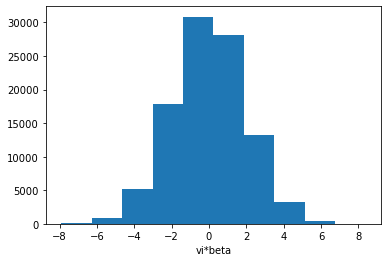

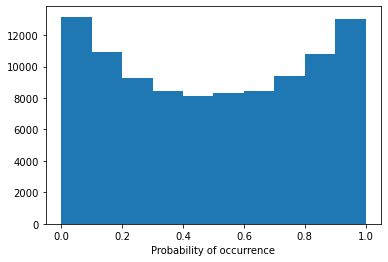

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:12,  2.52s/it]

Model 1/30, Test Accuracy: 0.7677

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:05<01:11,  2.54s/it]

Model 2/30, Test Accuracy: 0.7699

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:07,  2.51s/it]

Model 3/30, Test Accuracy: 0.7731

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:10<01:05,  2.53s/it]

Model 4/30, Test Accuracy: 0.7699

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:12<01:02,  2.51s/it]

Model 5/30, Test Accuracy: 0.7726

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:15<01:00,  2.50s/it]

Model 6/30, Test Accuracy: 0.7772

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:17<00:57,  2.50s/it]

Model 7/30, Test Accuracy: 0.7750

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:20<00:54,  2.48s/it]

Model 8/30, Test Accuracy: 0.7715

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:22<00:51,  2.43s/it]

Model 9/30, Test Accuracy: 0.7711

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:24<00:47,  2.37s/it]

Model 10/30, Test Accuracy: 0.7743

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:26<00:44,  2.37s/it]

Model 11/30, Test Accuracy: 0.7665

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:29<00:42,  2.34s/it]

Model 12/30, Test Accuracy: 0.7714

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:31<00:39,  2.35s/it]

Model 13/30, Test Accuracy: 0.7746

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:33<00:37,  2.36s/it]

Model 14/30, Test Accuracy: 0.7712

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:36<00:35,  2.36s/it]

Model 15/30, Test Accuracy: 0.7734

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:38<00:32,  2.33s/it]

Model 16/30, Test Accuracy: 0.7687

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:40<00:30,  2.34s/it]

Model 17/30, Test Accuracy: 0.7706

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:43<00:27,  2.32s/it]

Model 18/30, Test Accuracy: 0.7703

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:45<00:25,  2.32s/it]

Model 19/30, Test Accuracy: 0.7719

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:47<00:23,  2.32s/it]

Model 20/30, Test Accuracy: 0.7663

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:50<00:20,  2.30s/it]

Model 21/30, Test Accuracy: 0.7721

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:52<00:18,  2.34s/it]

Model 22/30, Test Accuracy: 0.7731

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:54<00:16,  2.32s/it]

Model 23/30, Test Accuracy: 0.7673

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:57<00:14,  2.33s/it]

Model 24/30, Test Accuracy: 0.7749

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:59<00:11,  2.36s/it]

Model 25/30, Test Accuracy: 0.7697

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:01<00:09,  2.37s/it]

Model 26/30, Test Accuracy: 0.7664

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:04<00:07,  2.36s/it]

Model 27/30, Test Accuracy: 0.7644

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:06<00:04,  2.36s/it]

Model 28/30, Test Accuracy: 0.7705

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:09<00:02,  2.37s/it]

Model 29/30, Test Accuracy: 0.7700

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:11<00:00,  2.38s/it]

Model 30/30, Test Accuracy: 0.7702
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq10_var0.5_beta_var0.4.pkl


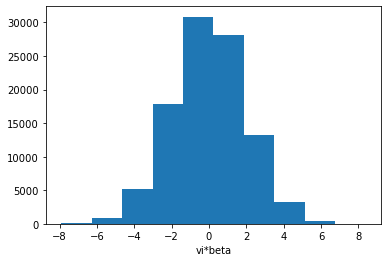

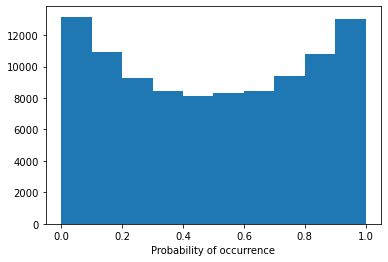

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:05,  2.27s/it]

Model 1/30, Test Accuracy: 0.7667

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:04,  2.31s/it]

Model 2/30, Test Accuracy: 0.7729

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:02,  2.30s/it]

Model 3/30, Test Accuracy: 0.7763

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<00:59,  2.30s/it]

Model 4/30, Test Accuracy: 0.7719

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:56,  2.28s/it]

Model 5/30, Test Accuracy: 0.7738

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.28s/it]

Model 6/30, Test Accuracy: 0.7771

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:51,  2.25s/it]

Model 7/30, Test Accuracy: 0.7759

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:53,  2.42s/it]

Model 8/30, Test Accuracy: 0.7738

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:21<00:50,  2.40s/it]

Model 9/30, Test Accuracy: 0.7722

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:46,  2.34s/it]

Model 10/30, Test Accuracy: 0.7749

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:44,  2.35s/it]

Model 11/30, Test Accuracy: 0.7693

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.32s/it]

Model 12/30, Test Accuracy: 0.7744

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:39,  2.34s/it]

Model 13/30, Test Accuracy: 0.7784

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.33s/it]

Model 14/30, Test Accuracy: 0.7721

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:34,  2.32s/it]

Model 15/30, Test Accuracy: 0.7745

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:37<00:32,  2.31s/it]

Model 16/30, Test Accuracy: 0.7688

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.38s/it]

Model 17/30, Test Accuracy: 0.7723

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:28,  2.34s/it]

Model 18/30, Test Accuracy: 0.7722

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:26,  2.41s/it]

Model 19/30, Test Accuracy: 0.7736

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:47<00:24,  2.47s/it]

Model 20/30, Test Accuracy: 0.7682

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:49<00:22,  2.51s/it]

Model 21/30, Test Accuracy: 0.7738

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:52<00:20,  2.54s/it]

Model 22/30, Test Accuracy: 0.7739

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:54<00:17,  2.48s/it]

Model 23/30, Test Accuracy: 0.7691

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:57<00:14,  2.48s/it]

Model 24/30, Test Accuracy: 0.7776

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:59<00:12,  2.54s/it]

Model 25/30, Test Accuracy: 0.7701

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:02<00:10,  2.57s/it]

Model 26/30, Test Accuracy: 0.7681

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:05<00:07,  2.61s/it]

Model 27/30, Test Accuracy: 0.7641

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:07<00:05,  2.57s/it]

Model 28/30, Test Accuracy: 0.7718

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:10<00:02,  2.63s/it]

Model 29/30, Test Accuracy: 0.7699

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:13<00:00,  2.44s/it]

Model 30/30, Test Accuracy: 0.7720
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq15_var0.5_beta_var0.4.pkl
Skipping training for epi_mean_ss100000_sq20_var0.5.pkl


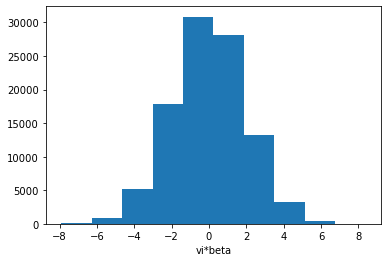

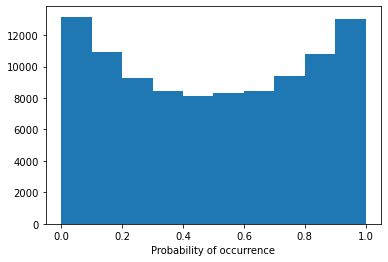

Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:03,  8.74it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4588

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:00<00:02,  9.84it/s]

Model 2/30, Test Accuracy: 0.4250

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4255

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:02,  9.90it/s]

Model 4/30, Test Accuracy: 0.5232

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5149

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.5931

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:00<00:02, 10.08it/s]

Model 7/30, Test Accuracy: 0.5051

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5223

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:01<00:02,  8.33it/s]

Model 9/30, Test Accuracy: 0.5136

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5569

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:01<00:01,  9.81it/s]

Model 11/30, Test Accuracy: 0.4777

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5451

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5339

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:01<00:01, 12.49it/s]

Model 14/30, Test Accuracy: 0.4897

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5726

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4499

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4086

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:01<00:00, 13.05it/s]

Model 18/30, Test Accuracy: 0.3902

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5647

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4453

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:02<00:00, 13.91it/s]

Model 21/30, Test Accuracy: 0.5910

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4250

Training Model 23/30 with dropout seed 0.
Model 23/30, Test Accuracy: 0.4734

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5743

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:02<00:00, 14.17it/s]

Model 25/30, Test Accuracy: 0.4834

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4616

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 11.41it/s]

Model 27/30, Test Accuracy: 0.4446

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4811

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4951

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4828


Predictions saved to epi_model_limitation/epi_mean_ss10_sq20_var1_beta_var0.4.pkl


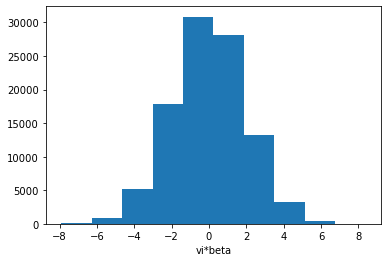

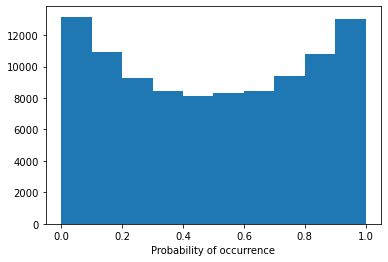

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:02, 13.57it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4611

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4301

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:00<00:01, 13.88it/s]

Model 3/30, Test Accuracy: 0.4390

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5275

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5193

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:00<00:01, 13.90it/s]

Model 6/30, Test Accuracy: 0.6126

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5135

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5359

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 13.99it/s]

Model 9/30, Test Accuracy: 0.5284

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5710

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4848

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:00<00:01, 13.92it/s]

Model 12/30, Test Accuracy: 0.5559

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5339

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:01<00:01, 13.01it/s]

Model 14/30, Test Accuracy: 0.5002

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5850

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4634

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4216

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:01<00:00, 14.22it/s]

Model 18/30, Test Accuracy: 0.4009

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5762

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4526

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 14.11it/s]

Model 21/30, Test Accuracy: 0.6048

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4239

Training Model 23/30 with dropout seed 0.
Model 23/30, Test Accuracy: 0.4762

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:01<00:00, 14.23it/s]

Model 24/30, Test Accuracy: 0.5927

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4857

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4687

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4429

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:02<00:00, 14.72it/s]

Model 28/30, Test Accuracy: 0.4971

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4974

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 13.41it/s]

Model 30/30, Test Accuracy: 0.4876
Predictions saved to epi_model_limitation/epi_mean_ss100_sq20_var1_beta_var0.4.pkl


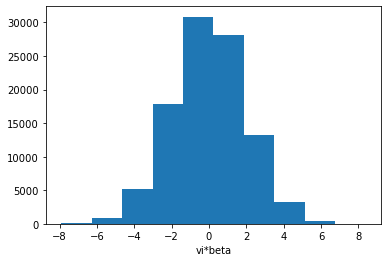

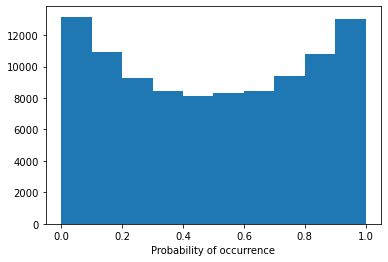

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4654

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:00<00:02, 10.60it/s]

Model 2/30, Test Accuracy: 0.4355

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4417

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5296

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:02, 11.27it/s]

Model 5/30, Test Accuracy: 0.5211

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.6151

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5131

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 11.20it/s]

Model 8/30, Test Accuracy: 0.5444

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5276

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5746

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:01<00:01, 11.00it/s]

Model 11/30, Test Accuracy: 0.4843

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5641

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5429

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:01<00:01, 10.57it/s]

Model 14/30, Test Accuracy: 0.5050

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5870

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4708

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:01, 10.74it/s]

Model 17/30, Test Accuracy: 0.4283

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4034

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:01<00:01,  9.21it/s]

Model 19/30, Test Accuracy: 0.5797

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4641

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.6167

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:02<00:00,  9.69it/s]

Model 22/30, Test Accuracy: 0.4261

Training Model 23/30 with dropout seed 0.
Model 23/30, Test Accuracy: 0.4817

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5971

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:02<00:00,  9.82it/s]

Model 25/30, Test Accuracy: 0.4896

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4740

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4505

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 10.22it/s]

Model 28/30, Test Accuracy: 0.4976

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.5048

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4963


Predictions saved to epi_model_limitation/epi_mean_ss1000_sq20_var1_beta_var0.4.pkl


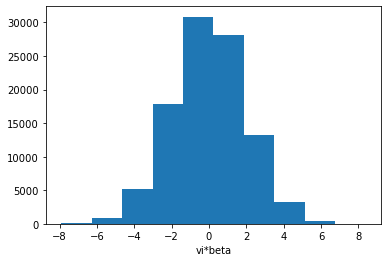

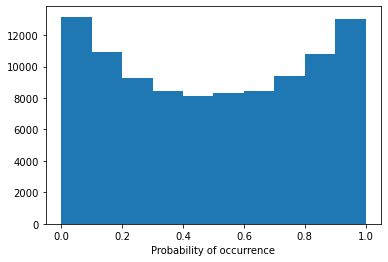

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:11,  2.43it/s]

Model 1/30, Test Accuracy: 0.5473

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:10,  2.73it/s]

Model 2/30, Test Accuracy: 0.5407

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:01<00:09,  2.73it/s]

Model 3/30, Test Accuracy: 0.5429

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:01<00:09,  2.75it/s]

Model 4/30, Test Accuracy: 0.5918

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:01<00:08,  2.92it/s]

Model 5/30, Test Accuracy: 0.5788

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:02<00:08,  2.67it/s]

Model 6/30, Test Accuracy: 0.6921

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:02<00:08,  2.71it/s]

Model 7/30, Test Accuracy: 0.5969

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:02<00:08,  2.75it/s]

Model 8/30, Test Accuracy: 0.6230

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:03<00:08,  2.54it/s]

Model 9/30, Test Accuracy: 0.5949

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:03<00:07,  2.63it/s]

Model 10/30, Test Accuracy: 0.6440

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:04<00:06,  2.82it/s]

Model 11/30, Test Accuracy: 0.5572

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:04<00:06,  2.84it/s]

Model 12/30, Test Accuracy: 0.6280

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:04<00:05,  2.87it/s]

Model 13/30, Test Accuracy: 0.6455

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:05<00:06,  2.64it/s]

Model 14/30, Test Accuracy: 0.5646

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:05<00:05,  2.67it/s]

Model 15/30, Test Accuracy: 0.6508

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:05<00:05,  2.68it/s]

Model 16/30, Test Accuracy: 0.5632

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:06<00:05,  2.53it/s]

Model 17/30, Test Accuracy: 0.5171

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:06<00:04,  2.59it/s]

Model 18/30, Test Accuracy: 0.4642

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:07<00:03,  2.77it/s]

Model 19/30, Test Accuracy: 0.6494

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:07<00:03,  2.83it/s]

Model 20/30, Test Accuracy: 0.5131

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:07<00:03,  2.89it/s]

Model 21/30, Test Accuracy: 0.6945

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:08<00:02,  2.88it/s]

Model 22/30, Test Accuracy: 0.5042

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:08<00:02,  2.74it/s]

Model 23/30, Test Accuracy: 0.5213

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:08<00:02,  2.72it/s]

Model 24/30, Test Accuracy: 0.6854

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:09<00:01,  2.56it/s]

Model 25/30, Test Accuracy: 0.5697

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:09<00:01,  2.64it/s]

Model 26/30, Test Accuracy: 0.5485

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:09<00:01,  2.67it/s]

Model 27/30, Test Accuracy: 0.4916

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:10<00:00,  2.69it/s]

Model 28/30, Test Accuracy: 0.5844

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:10<00:00,  2.77it/s]

Model 29/30, Test Accuracy: 0.5902

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:11<00:00,  2.72it/s]

Model 30/30, Test Accuracy: 0.5714
Predictions saved to epi_model_limitation/epi_mean_ss10000_sq20_var1_beta_var0.4.pkl


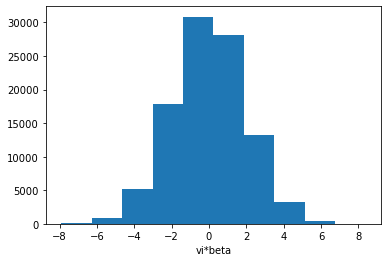

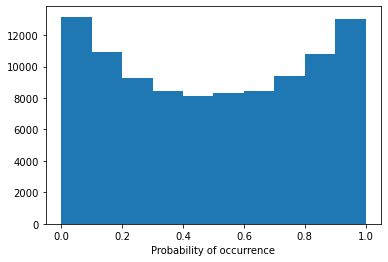

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:30,  1.04s/it]

Model 1/30, Test Accuracy: 0.6878

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:01<00:26,  1.04it/s]

Model 2/30, Test Accuracy: 0.7186

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:02<00:25,  1.04it/s]

Model 3/30, Test Accuracy: 0.7207

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:03<00:25,  1.01it/s]

Model 4/30, Test Accuracy: 0.7160

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:04<00:24,  1.02it/s]

Model 5/30, Test Accuracy: 0.6990

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:05<00:23,  1.02it/s]

Model 6/30, Test Accuracy: 0.7568

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:06<00:22,  1.01it/s]

Model 7/30, Test Accuracy: 0.7319

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:07<00:21,  1.02it/s]

Model 8/30, Test Accuracy: 0.7315

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:08<00:20,  1.02it/s]

Model 9/30, Test Accuracy: 0.7127

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:09<00:20,  1.01s/it]

Model 10/30, Test Accuracy: 0.7369

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:10<00:18,  1.02it/s]

Model 11/30, Test Accuracy: 0.6797

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:11<00:18,  1.00s/it]

Model 12/30, Test Accuracy: 0.7268

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:12<00:16,  1.00it/s]

Model 13/30, Test Accuracy: 0.7526

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:13<00:15,  1.02it/s]

Model 14/30, Test Accuracy: 0.6960

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:14<00:14,  1.01it/s]

Model 15/30, Test Accuracy: 0.7362

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:15<00:14,  1.00s/it]

Model 16/30, Test Accuracy: 0.7054

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:16<00:12,  1.01it/s]

Model 17/30, Test Accuracy: 0.6877

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:17<00:12,  1.00s/it]

Model 18/30, Test Accuracy: 0.6793

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:18<00:11,  1.01s/it]

Model 19/30, Test Accuracy: 0.7389

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:19<00:09,  1.01it/s]

Model 20/30, Test Accuracy: 0.6564

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:20<00:09,  1.02s/it]

Model 21/30, Test Accuracy: 0.7500

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:21<00:08,  1.01s/it]

Model 22/30, Test Accuracy: 0.6952

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:22<00:06,  1.00it/s]

Model 23/30, Test Accuracy: 0.6662

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:23<00:06,  1.00s/it]

Model 24/30, Test Accuracy: 0.7547

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:24<00:05,  1.02s/it]

Model 25/30, Test Accuracy: 0.6940

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:25<00:04,  1.02s/it]

Model 26/30, Test Accuracy: 0.6915

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:26<00:03,  1.00s/it]

Model 27/30, Test Accuracy: 0.6303

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:27<00:02,  1.02s/it]

Model 28/30, Test Accuracy: 0.7183

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:29<00:01,  1.03s/it]

Model 29/30, Test Accuracy: 0.7161

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:29<00:00,  1.00it/s]

Model 30/30, Test Accuracy: 0.7114
Predictions saved to epi_model_limitation/epi_mean_ss30000_sq20_var1_beta_var0.4.pkl


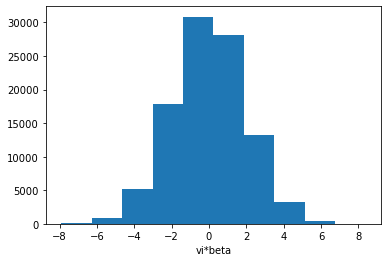

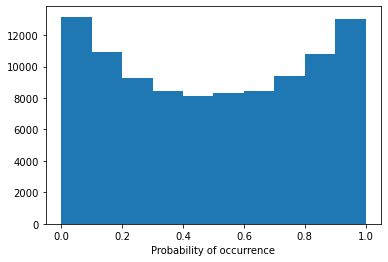

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:46,  1.62s/it]

Model 1/30, Test Accuracy: 0.7408

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:03<00:44,  1.59s/it]

Model 2/30, Test Accuracy: 0.7547

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:04<00:42,  1.57s/it]

Model 3/30, Test Accuracy: 0.7596

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:06<00:42,  1.63s/it]

Model 4/30, Test Accuracy: 0.7529

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:08<00:40,  1.63s/it]

Model 5/30, Test Accuracy: 0.7512

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:09<00:39,  1.65s/it]

Model 6/30, Test Accuracy: 0.7675

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:11<00:37,  1.64s/it]

Model 7/30, Test Accuracy: 0.7622

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:13<00:38,  1.73s/it]

Model 8/30, Test Accuracy: 0.7579

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:14<00:34,  1.66s/it]

Model 9/30, Test Accuracy: 0.7607

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:16<00:33,  1.67s/it]

Model 10/30, Test Accuracy: 0.7643

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:18<00:31,  1.65s/it]

Model 11/30, Test Accuracy: 0.7344

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:19<00:30,  1.67s/it]

Model 12/30, Test Accuracy: 0.7574

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:21<00:28,  1.66s/it]

Model 13/30, Test Accuracy: 0.7689

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:23<00:26,  1.66s/it]

Model 14/30, Test Accuracy: 0.7482

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:24<00:24,  1.64s/it]

Model 15/30, Test Accuracy: 0.7598

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:26<00:22,  1.61s/it]

Model 16/30, Test Accuracy: 0.7459

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:27<00:20,  1.60s/it]

Model 17/30, Test Accuracy: 0.7468

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:29<00:19,  1.62s/it]

Model 18/30, Test Accuracy: 0.7517

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:31<00:17,  1.63s/it]

Model 19/30, Test Accuracy: 0.7633

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:32<00:16,  1.62s/it]

Model 20/30, Test Accuracy: 0.7328

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:34<00:14,  1.64s/it]

Model 21/30, Test Accuracy: 0.7647

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:36<00:13,  1.64s/it]

Model 22/30, Test Accuracy: 0.7508

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:37<00:11,  1.65s/it]

Model 23/30, Test Accuracy: 0.7409

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:39<00:09,  1.66s/it]

Model 24/30, Test Accuracy: 0.7670

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:41<00:08,  1.65s/it]

Model 25/30, Test Accuracy: 0.7415

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:42<00:06,  1.64s/it]

Model 26/30, Test Accuracy: 0.7442

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:44<00:04,  1.65s/it]

Model 27/30, Test Accuracy: 0.7154

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:45<00:03,  1.64s/it]

Model 28/30, Test Accuracy: 0.7540

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:47<00:01,  1.63s/it]

Model 29/30, Test Accuracy: 0.7529

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:49<00:00,  1.64s/it]

Model 30/30, Test Accuracy: 0.7540
Predictions saved to epi_model_limitation/epi_mean_ss50000_sq20_var1_beta_var0.4.pkl


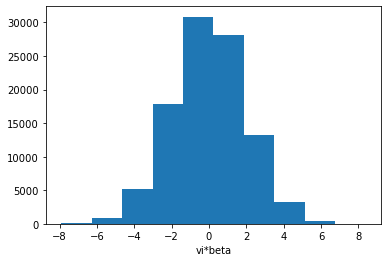

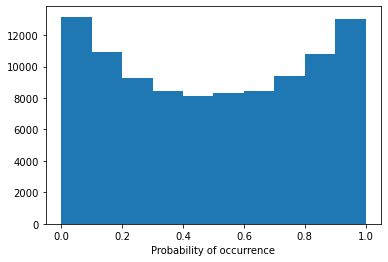

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:04,  2.21s/it]

Model 1/30, Test Accuracy: 0.7581

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:02,  2.25s/it]

Model 2/30, Test Accuracy: 0.7670

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:02,  2.32s/it]

Model 3/30, Test Accuracy: 0.7691

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:00,  2.31s/it]

Model 4/30, Test Accuracy: 0.7620

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:57,  2.31s/it]

Model 5/30, Test Accuracy: 0.7675

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:55,  2.31s/it]

Model 6/30, Test Accuracy: 0.7697

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:16<00:53,  2.31s/it]

Model 7/30, Test Accuracy: 0.7679

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:51,  2.33s/it]

Model 8/30, Test Accuracy: 0.7645

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:48,  2.32s/it]

Model 9/30, Test Accuracy: 0.7649

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:47,  2.36s/it]

Model 10/30, Test Accuracy: 0.7678

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:43,  2.29s/it]

Model 11/30, Test Accuracy: 0.7546

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.31s/it]

Model 12/30, Test Accuracy: 0.7661

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:39,  2.31s/it]

Model 13/30, Test Accuracy: 0.7700

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:36,  2.25s/it]

Model 14/30, Test Accuracy: 0.7648

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:34,  2.29s/it]

Model 15/30, Test Accuracy: 0.7664

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:31,  2.25s/it]

Model 16/30, Test Accuracy: 0.7612

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:38<00:28,  2.23s/it]

Model 17/30, Test Accuracy: 0.7655

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:27,  2.26s/it]

Model 18/30, Test Accuracy: 0.7636

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:43<00:24,  2.25s/it]

Model 19/30, Test Accuracy: 0.7665

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:45<00:22,  2.28s/it]

Model 20/30, Test Accuracy: 0.7582

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:47<00:20,  2.26s/it]

Model 21/30, Test Accuracy: 0.7669

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:50<00:18,  2.31s/it]

Model 22/30, Test Accuracy: 0.7655

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:52<00:16,  2.33s/it]

Model 23/30, Test Accuracy: 0.7621

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:55<00:14,  2.33s/it]

Model 24/30, Test Accuracy: 0.7702

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:57<00:11,  2.32s/it]

Model 25/30, Test Accuracy: 0.7641

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:59<00:09,  2.33s/it]

Model 26/30, Test Accuracy: 0.7580

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:02<00:07,  2.36s/it]

Model 27/30, Test Accuracy: 0.7527

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:04<00:04,  2.36s/it]

Model 28/30, Test Accuracy: 0.7644

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:06<00:02,  2.38s/it]

Model 29/30, Test Accuracy: 0.7655

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:09<00:00,  2.31s/it]

Model 30/30, Test Accuracy: 0.7634
Predictions saved to epi_model_limitation/epi_mean_ss70000_sq20_var1_beta_var0.4.pkl


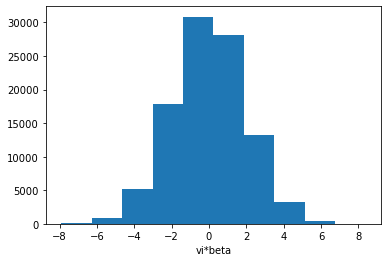

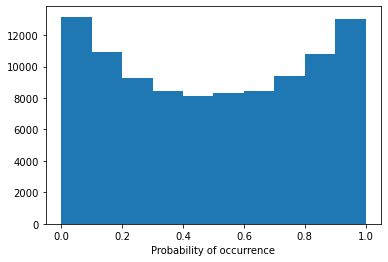

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:17,  2.69s/it]

Model 1/30, Test Accuracy: 0.7607

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:05<01:13,  2.62s/it]

Model 2/30, Test Accuracy: 0.7653

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:10,  2.61s/it]

Model 3/30, Test Accuracy: 0.7691

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:10<01:08,  2.64s/it]

Model 4/30, Test Accuracy: 0.7656

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:13<01:09,  2.79s/it]

Model 5/30, Test Accuracy: 0.7658

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:16<01:07,  2.81s/it]

Model 6/30, Test Accuracy: 0.7685

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:19<01:02,  2.74s/it]

Model 7/30, Test Accuracy: 0.7673

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:21<00:59,  2.72s/it]

Model 8/30, Test Accuracy: 0.7643

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:24<00:59,  2.84s/it]

Model 9/30, Test Accuracy: 0.7661

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:27<00:55,  2.80s/it]

Model 10/30, Test Accuracy: 0.7685

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:30<00:52,  2.76s/it]

Model 11/30, Test Accuracy: 0.7597

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:33<00:50,  2.79s/it]

Model 12/30, Test Accuracy: 0.7656

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:35<00:46,  2.73s/it]

Model 13/30, Test Accuracy: 0.7689

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:38<00:43,  2.69s/it]

Model 14/30, Test Accuracy: 0.7636

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:41<00:42,  2.84s/it]

Model 15/30, Test Accuracy: 0.7669

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:43<00:38,  2.76s/it]

Model 16/30, Test Accuracy: 0.7611

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:46<00:35,  2.76s/it]

Model 17/30, Test Accuracy: 0.7647

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:49<00:32,  2.69s/it]

Model 18/30, Test Accuracy: 0.7671

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:52<00:29,  2.70s/it]

Model 19/30, Test Accuracy: 0.7674

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:54<00:27,  2.71s/it]

Model 20/30, Test Accuracy: 0.7614

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:57<00:24,  2.73s/it]

Model 21/30, Test Accuracy: 0.7672

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [01:00<00:21,  2.67s/it]

Model 22/30, Test Accuracy: 0.7667

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [01:02<00:18,  2.65s/it]

Model 23/30, Test Accuracy: 0.7614

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [01:05<00:15,  2.65s/it]

Model 24/30, Test Accuracy: 0.7690

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [01:08<00:13,  2.68s/it]

Model 25/30, Test Accuracy: 0.7649

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:10<00:10,  2.68s/it]

Model 26/30, Test Accuracy: 0.7609

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:13<00:08,  2.67s/it]

Model 27/30, Test Accuracy: 0.7565

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:16<00:05,  2.69s/it]

Model 28/30, Test Accuracy: 0.7635

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:18<00:02,  2.68s/it]

Model 29/30, Test Accuracy: 0.7650

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:21<00:00,  2.71s/it]

Model 30/30, Test Accuracy: 0.7647
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq20_var1_beta_var0.4.pkl


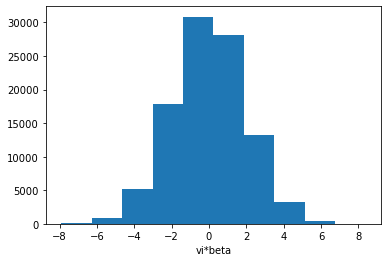

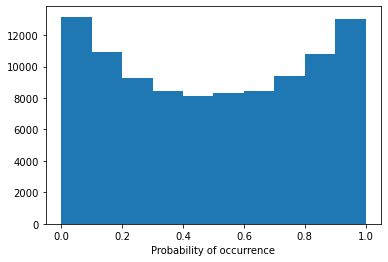

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:16,  2.64s/it]

Model 1/30, Test Accuracy: 0.6823

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:05<01:12,  2.59s/it]

Model 2/30, Test Accuracy: 0.6826

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:10,  2.62s/it]

Model 3/30, Test Accuracy: 0.6824

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:10<01:08,  2.65s/it]

Model 4/30, Test Accuracy: 0.6825

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:13<01:05,  2.63s/it]

Model 5/30, Test Accuracy: 0.6831

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:15<01:03,  2.66s/it]

Model 6/30, Test Accuracy: 0.6834

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:18<01:00,  2.61s/it]

Model 7/30, Test Accuracy: 0.6826

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:21<00:58,  2.65s/it]

Model 8/30, Test Accuracy: 0.6823

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:23<00:55,  2.66s/it]

Model 9/30, Test Accuracy: 0.6836

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:26<00:52,  2.64s/it]

Model 10/30, Test Accuracy: 0.6832

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:29<00:50,  2.65s/it]

Model 11/30, Test Accuracy: 0.6788

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:31<00:47,  2.64s/it]

Model 12/30, Test Accuracy: 0.6830

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:34<00:45,  2.68s/it]

Model 13/30, Test Accuracy: 0.6834

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:37<00:42,  2.68s/it]

Model 14/30, Test Accuracy: 0.6810

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:39<00:40,  2.69s/it]

Model 15/30, Test Accuracy: 0.6829

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:42<00:37,  2.66s/it]

Model 16/30, Test Accuracy: 0.6806

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:45<00:34,  2.68s/it]

Model 17/30, Test Accuracy: 0.6820

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:47<00:31,  2.66s/it]

Model 18/30, Test Accuracy: 0.6812

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:50<00:30,  2.75s/it]

Model 19/30, Test Accuracy: 0.6829

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:53<00:27,  2.73s/it]

Model 20/30, Test Accuracy: 0.6825

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:55<00:24,  2.67s/it]

Model 21/30, Test Accuracy: 0.6842

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:58<00:21,  2.66s/it]

Model 22/30, Test Accuracy: 0.6813

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [01:01<00:18,  2.64s/it]

Model 23/30, Test Accuracy: 0.6833

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [01:03<00:16,  2.67s/it]

Model 24/30, Test Accuracy: 0.6842

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [01:06<00:13,  2.64s/it]

Model 25/30, Test Accuracy: 0.6821

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:09<00:10,  2.67s/it]

Model 26/30, Test Accuracy: 0.6812

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:11<00:07,  2.64s/it]

Model 27/30, Test Accuracy: 0.6824

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:14<00:05,  2.66s/it]

Model 28/30, Test Accuracy: 0.6823

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:17<00:02,  2.64s/it]

Model 29/30, Test Accuracy: 0.6829

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:19<00:00,  2.66s/it]

Model 30/30, Test Accuracy: 0.6812
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq1_var1_beta_var0.4.pkl


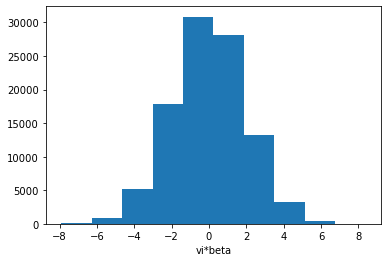

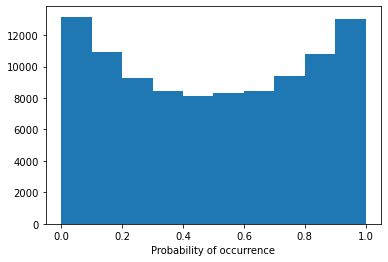

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:18,  2.71s/it]

Model 1/30, Test Accuracy: 0.7270

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:05<01:15,  2.71s/it]

Model 2/30, Test Accuracy: 0.7293

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:08<01:14,  2.78s/it]

Model 3/30, Test Accuracy: 0.7307

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:11<01:13,  2.82s/it]

Model 4/30, Test Accuracy: 0.7294

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:13<01:10,  2.82s/it]

Model 5/30, Test Accuracy: 0.7289

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:16<01:08,  2.83s/it]

Model 6/30, Test Accuracy: 0.7310

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:19<01:03,  2.77s/it]

Model 7/30, Test Accuracy: 0.7307

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:22<01:01,  2.78s/it]

Model 8/30, Test Accuracy: 0.7280

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:24<00:57,  2.74s/it]

Model 9/30, Test Accuracy: 0.7304

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:27<00:55,  2.77s/it]

Model 10/30, Test Accuracy: 0.7306

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:30<00:52,  2.75s/it]

Model 11/30, Test Accuracy: 0.7238

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:33<00:49,  2.74s/it]

Model 12/30, Test Accuracy: 0.7298

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:35<00:46,  2.75s/it]

Model 13/30, Test Accuracy: 0.7303

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:38<00:43,  2.74s/it]

Model 14/30, Test Accuracy: 0.7297

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:41<00:41,  2.74s/it]

Model 15/30, Test Accuracy: 0.7306

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:44<00:37,  2.71s/it]

Model 16/30, Test Accuracy: 0.7267

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:46<00:34,  2.65s/it]

Model 17/30, Test Accuracy: 0.7275

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:49<00:31,  2.65s/it]

Model 18/30, Test Accuracy: 0.7289

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:52<00:29,  2.69s/it]

Model 19/30, Test Accuracy: 0.7306

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:54<00:26,  2.67s/it]

Model 20/30, Test Accuracy: 0.7270

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:57<00:23,  2.65s/it]

Model 21/30, Test Accuracy: 0.7298

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [01:00<00:21,  2.69s/it]

Model 22/30, Test Accuracy: 0.7275

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [01:02<00:18,  2.68s/it]

Model 23/30, Test Accuracy: 0.7287

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [01:05<00:15,  2.64s/it]

Model 24/30, Test Accuracy: 0.7293

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [01:07<00:13,  2.62s/it]

Model 25/30, Test Accuracy: 0.7285

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:10<00:10,  2.65s/it]

Model 26/30, Test Accuracy: 0.7266

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:12<00:07,  2.59s/it]

Model 27/30, Test Accuracy: 0.7244

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:15<00:05,  2.62s/it]

Model 28/30, Test Accuracy: 0.7290

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:18<00:02,  2.58s/it]

Model 29/30, Test Accuracy: 0.7288

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:20<00:00,  2.70s/it]

Model 30/30, Test Accuracy: 0.7291
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq3_var1_beta_var0.4.pkl


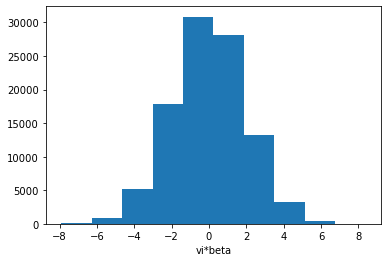

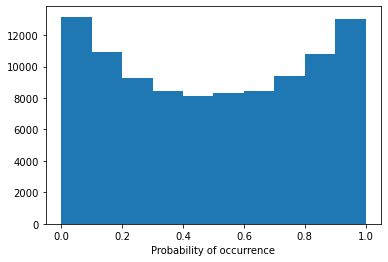

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Model 1/30, Test Accuracy: 0.7397

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:05<01:15,  2.71s/it]

Model 2/30, Test Accuracy: 0.7438

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:08<01:18,  2.90s/it]

Model 3/30, Test Accuracy: 0.7459

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:11<01:12,  2.80s/it]

Model 4/30, Test Accuracy: 0.7445

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:13<01:08,  2.74s/it]

Model 5/30, Test Accuracy: 0.7433

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:16<01:04,  2.70s/it]

Model 6/30, Test Accuracy: 0.7450

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:18<01:00,  2.62s/it]

Model 7/30, Test Accuracy: 0.7451

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:21<00:58,  2.64s/it]

Model 8/30, Test Accuracy: 0.7431

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:24<00:56,  2.67s/it]

Model 9/30, Test Accuracy: 0.7444

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:26<00:52,  2.64s/it]

Model 10/30, Test Accuracy: 0.7446

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:29<00:50,  2.65s/it]

Model 11/30, Test Accuracy: 0.7383

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:32<00:48,  2.67s/it]

Model 12/30, Test Accuracy: 0.7454

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:35<00:45,  2.70s/it]

Model 13/30, Test Accuracy: 0.7460

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:37<00:43,  2.70s/it]

Model 14/30, Test Accuracy: 0.7445

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:40<00:40,  2.72s/it]

Model 15/30, Test Accuracy: 0.7450

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:43<00:37,  2.69s/it]

Model 16/30, Test Accuracy: 0.7417

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:45<00:35,  2.71s/it]

Model 17/30, Test Accuracy: 0.7427

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:48<00:32,  2.72s/it]

Model 18/30, Test Accuracy: 0.7408

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:51<00:29,  2.71s/it]

Model 19/30, Test Accuracy: 0.7429

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:54<00:27,  2.70s/it]

Model 20/30, Test Accuracy: 0.7411

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:56<00:24,  2.69s/it]

Model 21/30, Test Accuracy: 0.7442

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:59<00:21,  2.65s/it]

Model 22/30, Test Accuracy: 0.7425

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [01:01<00:18,  2.66s/it]

Model 23/30, Test Accuracy: 0.7427

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [01:04<00:15,  2.66s/it]

Model 24/30, Test Accuracy: 0.7435

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [01:07<00:13,  2.66s/it]

Model 25/30, Test Accuracy: 0.7398

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:09<00:10,  2.68s/it]

Model 26/30, Test Accuracy: 0.7395

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:12<00:08,  2.68s/it]

Model 27/30, Test Accuracy: 0.7387

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:15<00:05,  2.69s/it]

Model 28/30, Test Accuracy: 0.7421

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:18<00:02,  2.72s/it]

Model 29/30, Test Accuracy: 0.7410

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:21<00:00,  2.71s/it]

Model 30/30, Test Accuracy: 0.7429
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq5_var1_beta_var0.4.pkl


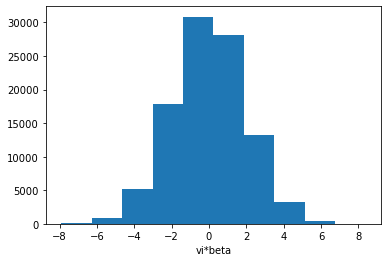

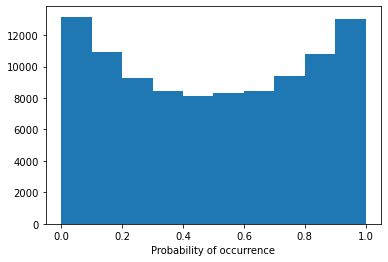

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:15,  2.60s/it]

Model 1/30, Test Accuracy: 0.7498

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:05<01:14,  2.67s/it]

Model 2/30, Test Accuracy: 0.7521

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:11,  2.65s/it]

Model 3/30, Test Accuracy: 0.7538

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:10<01:08,  2.64s/it]

Model 4/30, Test Accuracy: 0.7523

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:13<01:05,  2.61s/it]

Model 5/30, Test Accuracy: 0.7540

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:15<01:02,  2.61s/it]

Model 6/30, Test Accuracy: 0.7545

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:18<00:59,  2.59s/it]

Model 7/30, Test Accuracy: 0.7530

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:20<00:57,  2.60s/it]

Model 8/30, Test Accuracy: 0.7520

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:24<00:59,  2.83s/it]

Model 9/30, Test Accuracy: 0.7531

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:27<00:58,  2.91s/it]

Model 10/30, Test Accuracy: 0.7537

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:30<00:56,  2.97s/it]

Model 11/30, Test Accuracy: 0.7479

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:33<00:52,  2.93s/it]

Model 12/30, Test Accuracy: 0.7534

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:36<00:49,  2.94s/it]

Model 13/30, Test Accuracy: 0.7546

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:39<00:48,  3.01s/it]

Model 14/30, Test Accuracy: 0.7503

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:42<00:46,  3.13s/it]

Model 15/30, Test Accuracy: 0.7544

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:46<00:44,  3.18s/it]

Model 16/30, Test Accuracy: 0.7504

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:48<00:40,  3.08s/it]

Model 17/30, Test Accuracy: 0.7513

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:51<00:36,  3.02s/it]

Model 18/30, Test Accuracy: 0.7513

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:54<00:32,  2.96s/it]

Model 19/30, Test Accuracy: 0.7552

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:57<00:29,  2.93s/it]

Model 20/30, Test Accuracy: 0.7489

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [01:00<00:25,  2.87s/it]

Model 21/30, Test Accuracy: 0.7536

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [01:03<00:22,  2.86s/it]

Model 22/30, Test Accuracy: 0.7547

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [01:05<00:19,  2.82s/it]

Model 23/30, Test Accuracy: 0.7495

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [01:08<00:16,  2.82s/it]

Model 24/30, Test Accuracy: 0.7550

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [01:11<00:14,  2.83s/it]

Model 25/30, Test Accuracy: 0.7502

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:14<00:11,  2.82s/it]

Model 26/30, Test Accuracy: 0.7502

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:17<00:08,  2.80s/it]

Model 27/30, Test Accuracy: 0.7460

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:19<00:05,  2.79s/it]

Model 28/30, Test Accuracy: 0.7539

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:22<00:02,  2.79s/it]

Model 29/30, Test Accuracy: 0.7522

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:25<00:00,  2.85s/it]

Model 30/30, Test Accuracy: 0.7520
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq7_var1_beta_var0.4.pkl


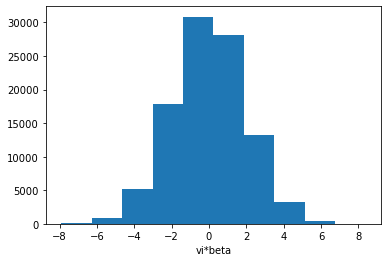

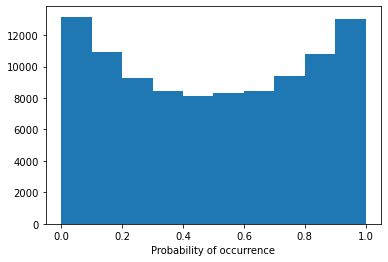

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:03<01:35,  3.30s/it]

Model 1/30, Test Accuracy: 0.7565

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:06<01:23,  2.98s/it]

Model 2/30, Test Accuracy: 0.7591

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:08<01:18,  2.92s/it]

Model 3/30, Test Accuracy: 0.7596

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:11<01:14,  2.88s/it]

Model 4/30, Test Accuracy: 0.7578

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:14<01:10,  2.80s/it]

Model 5/30, Test Accuracy: 0.7617

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:17<01:08,  2.84s/it]

Model 6/30, Test Accuracy: 0.7617

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:19<01:04,  2.78s/it]

Model 7/30, Test Accuracy: 0.7609

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:22<01:01,  2.79s/it]

Model 8/30, Test Accuracy: 0.7581

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:25<00:59,  2.82s/it]

Model 9/30, Test Accuracy: 0.7607

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:28<00:55,  2.79s/it]

Model 10/30, Test Accuracy: 0.7599

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:31<00:53,  2.80s/it]

Model 11/30, Test Accuracy: 0.7530

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:33<00:49,  2.75s/it]

Model 12/30, Test Accuracy: 0.7602

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:36<00:46,  2.75s/it]

Model 13/30, Test Accuracy: 0.7611

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:39<00:44,  2.75s/it]

Model 14/30, Test Accuracy: 0.7571

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:42<00:41,  2.77s/it]

Model 15/30, Test Accuracy: 0.7611

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:44<00:38,  2.73s/it]

Model 16/30, Test Accuracy: 0.7564

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:47<00:35,  2.75s/it]

Model 17/30, Test Accuracy: 0.7573

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:50<00:33,  2.76s/it]

Model 18/30, Test Accuracy: 0.7583

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:53<00:30,  2.74s/it]

Model 19/30, Test Accuracy: 0.7604

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:55<00:27,  2.79s/it]

Model 20/30, Test Accuracy: 0.7554

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:58<00:25,  2.78s/it]

Model 21/30, Test Accuracy: 0.7601

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [01:01<00:22,  2.76s/it]

Model 22/30, Test Accuracy: 0.7592

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [01:04<00:19,  2.72s/it]

Model 23/30, Test Accuracy: 0.7571

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [01:06<00:16,  2.70s/it]

Model 24/30, Test Accuracy: 0.7629

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [01:09<00:13,  2.69s/it]

Model 25/30, Test Accuracy: 0.7589

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:12<00:10,  2.68s/it]

Model 26/30, Test Accuracy: 0.7537

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:14<00:07,  2.64s/it]

Model 27/30, Test Accuracy: 0.7497

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:17<00:05,  2.63s/it]

Model 28/30, Test Accuracy: 0.7575

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:20<00:02,  2.76s/it]

Model 29/30, Test Accuracy: 0.7588

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:22<00:00,  2.75s/it]

Model 30/30, Test Accuracy: 0.7567
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq10_var1_beta_var0.4.pkl


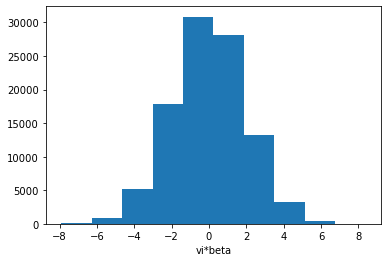

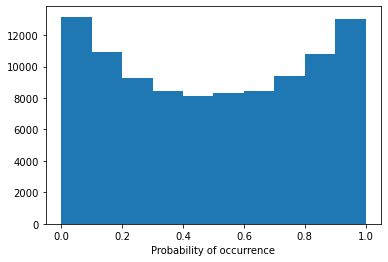

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:13,  2.53s/it]

Model 1/30, Test Accuracy: 0.7608

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:05<01:10,  2.53s/it]

Model 2/30, Test Accuracy: 0.7629

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:04,  2.39s/it]

Model 3/30, Test Accuracy: 0.7644

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<00:59,  2.31s/it]

Model 4/30, Test Accuracy: 0.7640

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:55,  2.23s/it]

Model 5/30, Test Accuracy: 0.7654

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:52,  2.20s/it]

Model 6/30, Test Accuracy: 0.7663

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:49,  2.15s/it]

Model 7/30, Test Accuracy: 0.7643

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:47,  2.15s/it]

Model 8/30, Test Accuracy: 0.7635

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:50,  2.40s/it]

Model 9/30, Test Accuracy: 0.7644

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:46,  2.31s/it]

Model 10/30, Test Accuracy: 0.7664

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:42,  2.26s/it]

Model 11/30, Test Accuracy: 0.7598

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:39,  2.19s/it]

Model 12/30, Test Accuracy: 0.7648

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:36,  2.16s/it]

Model 13/30, Test Accuracy: 0.7673

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:34,  2.16s/it]

Model 14/30, Test Accuracy: 0.7631

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:32,  2.15s/it]

Model 15/30, Test Accuracy: 0.7657

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:29,  2.11s/it]

Model 16/30, Test Accuracy: 0.7614

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:27,  2.10s/it]

Model 17/30, Test Accuracy: 0.7642

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:25,  2.09s/it]

Model 18/30, Test Accuracy: 0.7643

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:23,  2.10s/it]

Model 19/30, Test Accuracy: 0.7673

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:43<00:21,  2.11s/it]

Model 20/30, Test Accuracy: 0.7606

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:45<00:18,  2.09s/it]

Model 21/30, Test Accuracy: 0.7660

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:16,  2.11s/it]

Model 22/30, Test Accuracy: 0.7636

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:50<00:14,  2.11s/it]

Model 23/30, Test Accuracy: 0.7632

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:52<00:12,  2.15s/it]

Model 24/30, Test Accuracy: 0.7667

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:54<00:10,  2.14s/it]

Model 25/30, Test Accuracy: 0.7612

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:56<00:08,  2.14s/it]

Model 26/30, Test Accuracy: 0.7599

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:58<00:06,  2.12s/it]

Model 27/30, Test Accuracy: 0.7563

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:00<00:04,  2.10s/it]

Model 28/30, Test Accuracy: 0.7621

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:02<00:02,  2.11s/it]

Model 29/30, Test Accuracy: 0.7629

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:05<00:00,  2.17s/it]

Model 30/30, Test Accuracy: 0.7630
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq15_var1_beta_var0.4.pkl
Skipping training for epi_mean_ss100000_sq20_var1.pkl


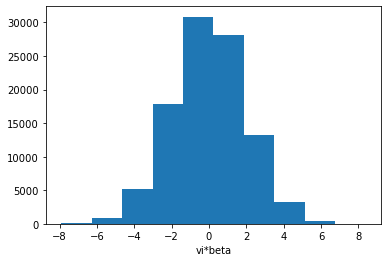

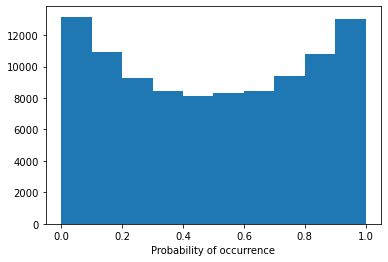

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 16.93it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4603

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4284

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4315

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:01, 18.52it/s]

Model 4/30, Test Accuracy: 0.5222

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5120

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.5863

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5020

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 14.86it/s]

Model 8/30, Test Accuracy: 0.5210

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5127

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5568

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:00<00:00, 16.66it/s]

Model 11/30, Test Accuracy: 0.4796

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5434

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5304

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.4888

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 17.09it/s]

Model 15/30, Test Accuracy: 0.5706

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4556

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4142

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.3982

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 17.47it/s]

Model 19/30, Test Accuracy: 0.5605

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4459

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5867

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4290

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:01<00:00, 17.55it/s]

Model 23/30, Test Accuracy: 0.4750

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5675

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4836

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4625

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:01<00:00, 17.16it/s]

Model 27/30, Test Accuracy: 0.4456

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4787

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4934

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4867
Predictions saved to epi_model_limitation/epi_mean_ss10_sq20_var2_beta_var0.4.pkl


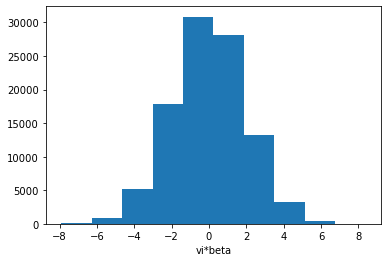

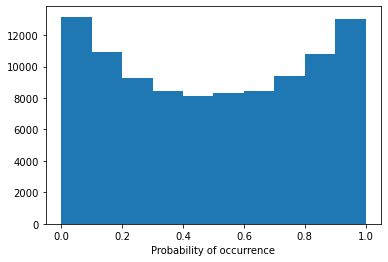

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 17.71it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4607

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4354

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4434

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:01, 14.01it/s]

Model 4/30, Test Accuracy: 0.5243

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5168

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.6032

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5091

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 15.72it/s]

Model 8/30, Test Accuracy: 0.5316

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5260

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5685

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4847

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:00<00:00, 16.54it/s]

Model 12/30, Test Accuracy: 0.5523

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5331

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.4995

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5800

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 16.63it/s]

Model 16/30, Test Accuracy: 0.4675

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4244

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4092

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5720

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:01<00:00, 16.88it/s]

Model 20/30, Test Accuracy: 0.4571

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5994

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:01<00:00, 14.55it/s]

Model 22/30, Test Accuracy: 0.4271

Training Model 23/30 with dropout seed 0.
Model 23/30, Test Accuracy: 0.4781

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5869

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4860

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:01<00:00, 15.19it/s]

Model 26/30, Test Accuracy: 0.4702

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4468

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4985

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4966

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:01<00:00, 15.38it/s]


Model 30/30, Test Accuracy: 0.4906
Predictions saved to epi_model_limitation/epi_mean_ss100_sq20_var2_beta_var0.4.pkl


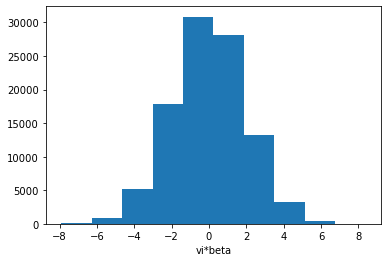

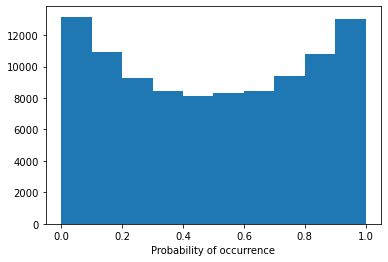

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:02, 13.44it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4676

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4411

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:00<00:01, 13.91it/s]

Model 3/30, Test Accuracy: 0.4410

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5252

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5210

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:00<00:01, 13.65it/s]

Model 6/30, Test Accuracy: 0.6061

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5105

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5384

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 13.56it/s]

Model 9/30, Test Accuracy: 0.5244

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5704

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4833

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:00<00:01, 13.80it/s]

Model 12/30, Test Accuracy: 0.5615

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5431

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:01<00:01, 12.47it/s]

Model 14/30, Test Accuracy: 0.5071

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5806

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4713

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 12.44it/s]

Model 17/30, Test Accuracy: 0.4305

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4091

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5733

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 12.72it/s]

Model 20/30, Test Accuracy: 0.4647

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.6115

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4280

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:01<00:00, 13.02it/s]

Model 23/30, Test Accuracy: 0.4803

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5905

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4864

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:02<00:00, 12.17it/s]

Model 26/30, Test Accuracy: 0.4743

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4537

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4961

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 12.71it/s]


Model 29/30, Test Accuracy: 0.5044

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4944
Predictions saved to epi_model_limitation/epi_mean_ss1000_sq20_var2_beta_var0.4.pkl


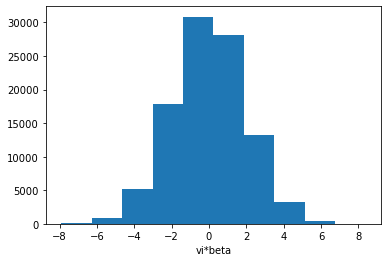

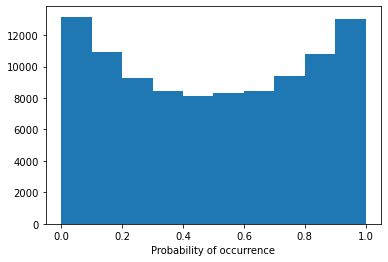

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:07,  3.66it/s]

Model 1/30, Test Accuracy: 0.5436

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:08,  3.12it/s]

Model 2/30, Test Accuracy: 0.5343

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:00<00:08,  3.30it/s]

Model 3/30, Test Accuracy: 0.5377

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:01<00:07,  3.35it/s]

Model 4/30, Test Accuracy: 0.5839

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:01<00:07,  3.35it/s]

Model 5/30, Test Accuracy: 0.5706

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:01<00:07,  3.38it/s]

Model 6/30, Test Accuracy: 0.6762

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:02<00:06,  3.44it/s]

Model 7/30, Test Accuracy: 0.5865

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:02<00:06,  3.15it/s]

Model 8/30, Test Accuracy: 0.6097

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:02<00:06,  3.24it/s]

Model 9/30, Test Accuracy: 0.5841

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:03<00:06,  3.32it/s]

Model 10/30, Test Accuracy: 0.6309

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:03<00:06,  3.13it/s]

Model 11/30, Test Accuracy: 0.5528

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:03<00:05,  3.22it/s]

Model 12/30, Test Accuracy: 0.6177

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:03<00:05,  3.30it/s]

Model 13/30, Test Accuracy: 0.6353

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:04<00:04,  3.35it/s]

Model 14/30, Test Accuracy: 0.5571

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:04<00:04,  3.37it/s]

Model 15/30, Test Accuracy: 0.6348

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:04<00:04,  3.16it/s]

Model 16/30, Test Accuracy: 0.5575

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:05<00:03,  3.25it/s]

Model 17/30, Test Accuracy: 0.5144

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:05<00:03,  3.30it/s]

Model 18/30, Test Accuracy: 0.4639

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:05<00:03,  3.10it/s]

Model 19/30, Test Accuracy: 0.6389

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:06<00:03,  3.10it/s]

Model 20/30, Test Accuracy: 0.5109

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:06<00:02,  3.19it/s]

Model 21/30, Test Accuracy: 0.6788

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:06<00:02,  3.24it/s]

Model 22/30, Test Accuracy: 0.5010

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:07<00:02,  3.30it/s]

Model 23/30, Test Accuracy: 0.5123

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:07<00:01,  3.33it/s]

Model 24/30, Test Accuracy: 0.6721

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:07<00:01,  3.16it/s]

Model 25/30, Test Accuracy: 0.5636

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:07<00:01,  3.28it/s]

Model 26/30, Test Accuracy: 0.5460

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:08<00:00,  3.14it/s]

Model 27/30, Test Accuracy: 0.4885

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:08<00:00,  3.21it/s]

Model 28/30, Test Accuracy: 0.5776

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:08<00:00,  3.26it/s]

Model 29/30, Test Accuracy: 0.5827

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:09<00:00,  3.26it/s]

Model 30/30, Test Accuracy: 0.5633
Predictions saved to epi_model_limitation/epi_mean_ss10000_sq20_var2_beta_var0.4.pkl


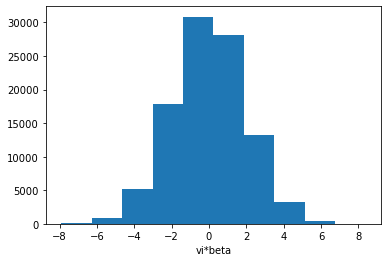

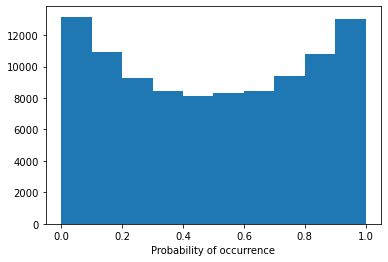

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:24,  1.20it/s]

Model 1/30, Test Accuracy: 0.6727

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:01<00:21,  1.28it/s]

Model 2/30, Test Accuracy: 0.7024

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:02<00:21,  1.24it/s]

Model 3/30, Test Accuracy: 0.7050

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:03<00:21,  1.23it/s]

Model 4/30, Test Accuracy: 0.6994

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:03<00:19,  1.26it/s]

Model 5/30, Test Accuracy: 0.6808

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:04<00:19,  1.24it/s]

Model 6/30, Test Accuracy: 0.7328

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:05<00:18,  1.22it/s]

Model 7/30, Test Accuracy: 0.7135

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

Model 8/30, Test Accuracy: 0.7135

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:07<00:17,  1.17it/s]

Model 9/30, Test Accuracy: 0.6979

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:08<00:17,  1.17it/s]

Model 10/30, Test Accuracy: 0.7199

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:09<00:15,  1.21it/s]

Model 11/30, Test Accuracy: 0.6646

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:09<00:14,  1.20it/s]

Model 12/30, Test Accuracy: 0.7111

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:10<00:14,  1.18it/s]

Model 13/30, Test Accuracy: 0.7331

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:11<00:13,  1.22it/s]

Model 14/30, Test Accuracy: 0.6799

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:12<00:12,  1.23it/s]

Model 15/30, Test Accuracy: 0.7167

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:13<00:11,  1.21it/s]

Model 16/30, Test Accuracy: 0.6877

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:13<00:10,  1.21it/s]

Model 17/30, Test Accuracy: 0.6738

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:14<00:09,  1.23it/s]

Model 18/30, Test Accuracy: 0.6638

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:15<00:09,  1.19it/s]

Model 19/30, Test Accuracy: 0.7181

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:16<00:08,  1.18it/s]

Model 20/30, Test Accuracy: 0.6413

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:17<00:07,  1.20it/s]

Model 21/30, Test Accuracy: 0.7306

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:18<00:06,  1.19it/s]

Model 22/30, Test Accuracy: 0.6770

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:19<00:05,  1.19it/s]

Model 23/30, Test Accuracy: 0.6511

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:19<00:04,  1.22it/s]

Model 24/30, Test Accuracy: 0.7325

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:20<00:04,  1.21it/s]

Model 25/30, Test Accuracy: 0.6760

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:21<00:03,  1.20it/s]

Model 26/30, Test Accuracy: 0.6763

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:22<00:02,  1.23it/s]

Model 27/30, Test Accuracy: 0.6169

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:23<00:01,  1.22it/s]

Model 28/30, Test Accuracy: 0.6984

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:23<00:00,  1.21it/s]

Model 29/30, Test Accuracy: 0.6992

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]

Model 30/30, Test Accuracy: 0.6953
Predictions saved to epi_model_limitation/epi_mean_ss30000_sq20_var2_beta_var0.4.pkl


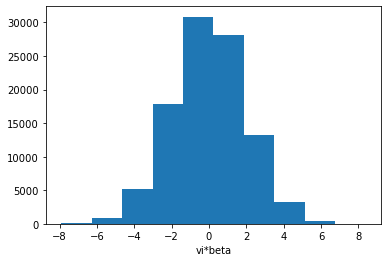

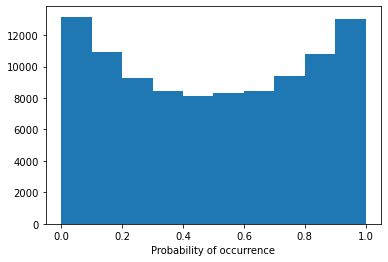

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:39,  1.38s/it]

Model 1/30, Test Accuracy: 0.7215

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:02<00:38,  1.39s/it]

Model 2/30, Test Accuracy: 0.7378

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:04<00:37,  1.38s/it]

Model 3/30, Test Accuracy: 0.7396

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:05<00:35,  1.36s/it]

Model 4/30, Test Accuracy: 0.7343

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:07<00:38,  1.54s/it]

Model 5/30, Test Accuracy: 0.7312

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:08<00:35,  1.50s/it]

Model 6/30, Test Accuracy: 0.7439

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:10<00:32,  1.42s/it]

Model 7/30, Test Accuracy: 0.7409

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:11<00:31,  1.41s/it]

Model 8/30, Test Accuracy: 0.7371

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:12<00:29,  1.39s/it]

Model 9/30, Test Accuracy: 0.7381

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:14<00:28,  1.42s/it]

Model 10/30, Test Accuracy: 0.7422

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:15<00:26,  1.37s/it]

Model 11/30, Test Accuracy: 0.7188

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:16<00:25,  1.40s/it]

Model 12/30, Test Accuracy: 0.7373

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:18<00:23,  1.36s/it]

Model 13/30, Test Accuracy: 0.7426

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:19<00:22,  1.39s/it]

Model 14/30, Test Accuracy: 0.7286

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:21<00:20,  1.37s/it]

Model 15/30, Test Accuracy: 0.7409

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:22<00:19,  1.36s/it]

Model 16/30, Test Accuracy: 0.7268

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:23<00:17,  1.35s/it]

Model 17/30, Test Accuracy: 0.7279

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:25<00:16,  1.36s/it]

Model 18/30, Test Accuracy: 0.7318

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:26<00:15,  1.37s/it]

Model 19/30, Test Accuracy: 0.7456

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:27<00:13,  1.37s/it]

Model 20/30, Test Accuracy: 0.7145

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:29<00:12,  1.36s/it]

Model 21/30, Test Accuracy: 0.7458

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:30<00:10,  1.37s/it]

Model 22/30, Test Accuracy: 0.7293

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:32<00:10,  1.49s/it]

Model 23/30, Test Accuracy: 0.7248

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:33<00:08,  1.45s/it]

Model 24/30, Test Accuracy: 0.7468

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:34<00:07,  1.41s/it]

Model 25/30, Test Accuracy: 0.7228

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:36<00:05,  1.39s/it]

Model 26/30, Test Accuracy: 0.7271

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:37<00:04,  1.39s/it]

Model 27/30, Test Accuracy: 0.6993

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:39<00:03,  1.52s/it]

Model 28/30, Test Accuracy: 0.7335

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:40<00:01,  1.48s/it]

Model 29/30, Test Accuracy: 0.7319

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:42<00:00,  1.43s/it]

Model 30/30, Test Accuracy: 0.7338
Predictions saved to epi_model_limitation/epi_mean_ss50000_sq20_var2_beta_var0.4.pkl


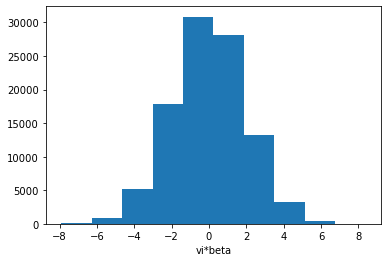

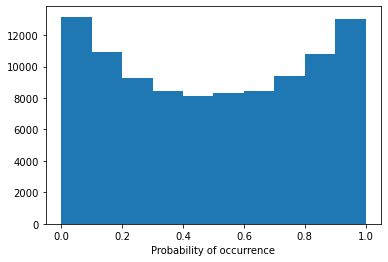

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:56,  1.95s/it]

Model 1/30, Test Accuracy: 0.7377

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:03<00:54,  1.96s/it]

Model 2/30, Test Accuracy: 0.7426

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:05<00:53,  1.97s/it]

Model 3/30, Test Accuracy: 0.7461

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:07<00:50,  1.93s/it]

Model 4/30, Test Accuracy: 0.7396

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:09<00:47,  1.91s/it]

Model 5/30, Test Accuracy: 0.7451

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:11<00:45,  1.92s/it]

Model 6/30, Test Accuracy: 0.7459

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:13<00:43,  1.89s/it]

Model 7/30, Test Accuracy: 0.7453

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:15<00:41,  1.88s/it]

Model 8/30, Test Accuracy: 0.7410

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:17<00:40,  1.93s/it]

Model 9/30, Test Accuracy: 0.7439

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:19<00:42,  2.11s/it]

Model 10/30, Test Accuracy: 0.7453

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:21<00:38,  2.05s/it]

Model 11/30, Test Accuracy: 0.7354

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:23<00:35,  2.00s/it]

Model 12/30, Test Accuracy: 0.7432

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:25<00:33,  1.99s/it]

Model 13/30, Test Accuracy: 0.7471

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:27<00:31,  1.96s/it]

Model 14/30, Test Accuracy: 0.7416

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:29<00:29,  1.94s/it]

Model 15/30, Test Accuracy: 0.7437

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:31<00:27,  1.96s/it]

Model 16/30, Test Accuracy: 0.7383

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:33<00:26,  2.02s/it]

Model 17/30, Test Accuracy: 0.7416

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:35<00:23,  2.00s/it]

Model 18/30, Test Accuracy: 0.7407

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:37<00:22,  2.02s/it]

Model 19/30, Test Accuracy: 0.7438

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:39<00:20,  2.05s/it]

Model 20/30, Test Accuracy: 0.7368

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:41<00:18,  2.02s/it]

Model 21/30, Test Accuracy: 0.7439

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:43<00:15,  2.00s/it]

Model 22/30, Test Accuracy: 0.7439

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:45<00:14,  2.00s/it]

Model 23/30, Test Accuracy: 0.7394

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:47<00:11,  2.00s/it]

Model 24/30, Test Accuracy: 0.7454

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:49<00:09,  1.96s/it]

Model 25/30, Test Accuracy: 0.7401

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:51<00:07,  1.94s/it]

Model 26/30, Test Accuracy: 0.7359

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:53<00:05,  1.95s/it]

Model 27/30, Test Accuracy: 0.7330

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:55<00:03,  1.95s/it]

Model 28/30, Test Accuracy: 0.7429

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:57<00:01,  1.96s/it]

Model 29/30, Test Accuracy: 0.7419

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it]

Model 30/30, Test Accuracy: 0.7411
Predictions saved to epi_model_limitation/epi_mean_ss70000_sq20_var2_beta_var0.4.pkl


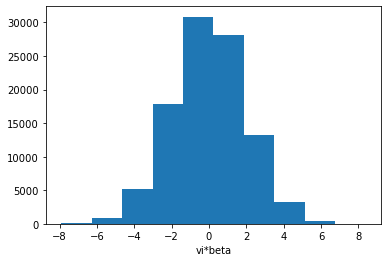

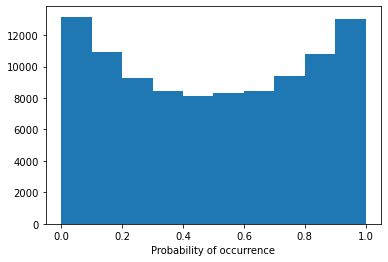

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:05,  2.28s/it]

Model 1/30, Test Accuracy: 0.7403

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:02,  2.25s/it]

Model 2/30, Test Accuracy: 0.7421

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:01,  2.28s/it]

Model 3/30, Test Accuracy: 0.7416

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<00:58,  2.26s/it]

Model 4/30, Test Accuracy: 0.7416

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:55,  2.23s/it]

Model 5/30, Test Accuracy: 0.7412

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.26s/it]

Model 6/30, Test Accuracy: 0.7428

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:51,  2.25s/it]

Model 7/30, Test Accuracy: 0.7430

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:49,  2.26s/it]

Model 8/30, Test Accuracy: 0.7419

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:48,  2.30s/it]

Model 9/30, Test Accuracy: 0.7439

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:50,  2.51s/it]

Model 10/30, Test Accuracy: 0.7432

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:47,  2.48s/it]

Model 11/30, Test Accuracy: 0.7383

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:28<00:43,  2.41s/it]

Model 12/30, Test Accuracy: 0.7430

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:39,  2.34s/it]

Model 13/30, Test Accuracy: 0.7429

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.32s/it]

Model 14/30, Test Accuracy: 0.7428

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:35<00:35,  2.40s/it]

Model 15/30, Test Accuracy: 0.7427

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:37<00:32,  2.35s/it]

Model 16/30, Test Accuracy: 0.7394

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.31s/it]

Model 17/30, Test Accuracy: 0.7408

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:27,  2.28s/it]

Model 18/30, Test Accuracy: 0.7417

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:25,  2.28s/it]

Model 19/30, Test Accuracy: 0.7439

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.35s/it]

Model 20/30, Test Accuracy: 0.7394

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:48<00:20,  2.32s/it]

Model 21/30, Test Accuracy: 0.7440

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:50<00:18,  2.27s/it]

Model 22/30, Test Accuracy: 0.7413

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:53<00:15,  2.25s/it]

Model 23/30, Test Accuracy: 0.7391

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:55<00:13,  2.31s/it]

Model 24/30, Test Accuracy: 0.7436

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:58<00:12,  2.49s/it]

Model 25/30, Test Accuracy: 0.7388

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:00<00:09,  2.42s/it]

Model 26/30, Test Accuracy: 0.7388

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:02<00:07,  2.35s/it]

Model 27/30, Test Accuracy: 0.7345

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:05<00:04,  2.32s/it]

Model 28/30, Test Accuracy: 0.7409

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:07<00:02,  2.31s/it]

Model 29/30, Test Accuracy: 0.7405

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:09<00:00,  2.33s/it]

Model 30/30, Test Accuracy: 0.7412
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq20_var2_beta_var0.4.pkl


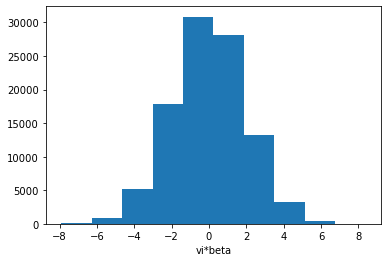

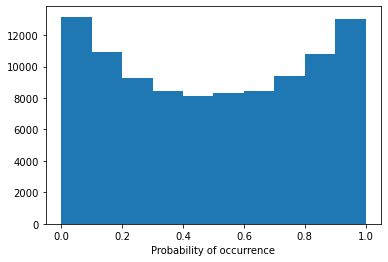

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:06,  2.28s/it]

Model 1/30, Test Accuracy: 0.6091

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:02,  2.25s/it]

Model 2/30, Test Accuracy: 0.6092

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:59,  2.22s/it]

Model 3/30, Test Accuracy: 0.6082

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<00:58,  2.26s/it]

Model 4/30, Test Accuracy: 0.6096

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:55,  2.22s/it]

Model 5/30, Test Accuracy: 0.6088

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:52,  2.21s/it]

Model 6/30, Test Accuracy: 0.6070

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:50,  2.20s/it]

Model 7/30, Test Accuracy: 0.6083

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:48,  2.22s/it]

Model 8/30, Test Accuracy: 0.6083

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:46,  2.23s/it]

Model 9/30, Test Accuracy: 0.6091

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:44,  2.22s/it]

Model 10/30, Test Accuracy: 0.6085

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:41,  2.20s/it]

Model 11/30, Test Accuracy: 0.6070

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:39,  2.19s/it]

Model 12/30, Test Accuracy: 0.6074

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:37,  2.20s/it]

Model 13/30, Test Accuracy: 0.6092

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:35,  2.19s/it]

Model 14/30, Test Accuracy: 0.6103

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:32,  2.19s/it]

Model 15/30, Test Accuracy: 0.6077

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:30,  2.17s/it]

Model 16/30, Test Accuracy: 0.6079

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:28,  2.16s/it]

Model 17/30, Test Accuracy: 0.6083

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:25,  2.13s/it]

Model 18/30, Test Accuracy: 0.6074

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:23,  2.15s/it]

Model 19/30, Test Accuracy: 0.6073

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:43<00:21,  2.18s/it]

Model 20/30, Test Accuracy: 0.6078

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:45<00:19,  2.14s/it]

Model 21/30, Test Accuracy: 0.6080

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:17,  2.14s/it]

Model 22/30, Test Accuracy: 0.6084

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:50<00:14,  2.13s/it]

Model 23/30, Test Accuracy: 0.6091

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:52<00:13,  2.19s/it]

Model 24/30, Test Accuracy: 0.6087

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:54<00:11,  2.23s/it]

Model 25/30, Test Accuracy: 0.6088

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:57<00:09,  2.35s/it]

Model 26/30, Test Accuracy: 0.6072

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:59<00:06,  2.33s/it]

Model 27/30, Test Accuracy: 0.6076

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:02<00:04,  2.33s/it]

Model 28/30, Test Accuracy: 0.6078

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:04<00:02,  2.34s/it]

Model 29/30, Test Accuracy: 0.6088

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.23s/it]

Model 30/30, Test Accuracy: 0.6079
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq1_var2_beta_var0.4.pkl


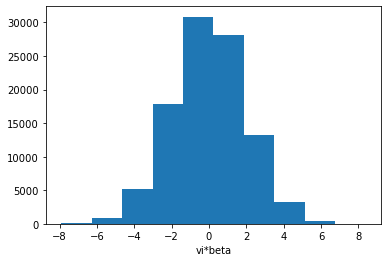

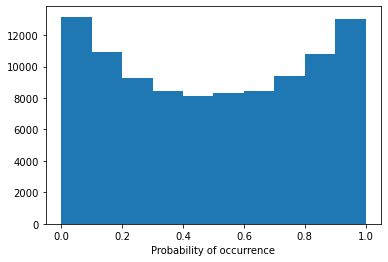

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:14,  2.58s/it]

Model 1/30, Test Accuracy: 0.6670

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:05<01:18,  2.80s/it]

Model 2/30, Test Accuracy: 0.6676

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:10,  2.61s/it]

Model 3/30, Test Accuracy: 0.6677

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:10<01:05,  2.53s/it]

Model 4/30, Test Accuracy: 0.6657

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:12<01:02,  2.49s/it]

Model 5/30, Test Accuracy: 0.6668

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:15<00:59,  2.48s/it]

Model 6/30, Test Accuracy: 0.6666

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:17<00:56,  2.45s/it]

Model 7/30, Test Accuracy: 0.6673

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:20<00:53,  2.44s/it]

Model 8/30, Test Accuracy: 0.6666

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:22<00:50,  2.42s/it]

Model 9/30, Test Accuracy: 0.6657

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:24<00:48,  2.41s/it]

Model 10/30, Test Accuracy: 0.6666

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:27<00:46,  2.43s/it]

Model 11/30, Test Accuracy: 0.6666

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:29<00:43,  2.40s/it]

Model 12/30, Test Accuracy: 0.6668

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:32<00:41,  2.42s/it]

Model 13/30, Test Accuracy: 0.6660

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:34<00:39,  2.44s/it]

Model 14/30, Test Accuracy: 0.6675

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:36<00:36,  2.45s/it]

Model 15/30, Test Accuracy: 0.6671

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:39<00:35,  2.52s/it]

Model 16/30, Test Accuracy: 0.6674

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:42<00:32,  2.49s/it]

Model 17/30, Test Accuracy: 0.6670

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:44<00:29,  2.44s/it]

Model 18/30, Test Accuracy: 0.6675

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:46<00:26,  2.42s/it]

Model 19/30, Test Accuracy: 0.6681

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:49<00:24,  2.42s/it]

Model 20/30, Test Accuracy: 0.6678

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:51<00:21,  2.38s/it]

Model 21/30, Test Accuracy: 0.6671

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:53<00:19,  2.39s/it]

Model 22/30, Test Accuracy: 0.6675

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:56<00:16,  2.39s/it]

Model 23/30, Test Accuracy: 0.6676

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:58<00:14,  2.41s/it]

Model 24/30, Test Accuracy: 0.6671

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [01:01<00:12,  2.43s/it]

Model 25/30, Test Accuracy: 0.6671

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:04<00:10,  2.62s/it]

Model 26/30, Test Accuracy: 0.6655

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:06<00:07,  2.53s/it]

Model 27/30, Test Accuracy: 0.6669

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:08<00:04,  2.47s/it]

Model 28/30, Test Accuracy: 0.6670

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:11<00:02,  2.45s/it]

Model 29/30, Test Accuracy: 0.6682

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:13<00:00,  2.46s/it]

Model 30/30, Test Accuracy: 0.6671
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq3_var2_beta_var0.4.pkl


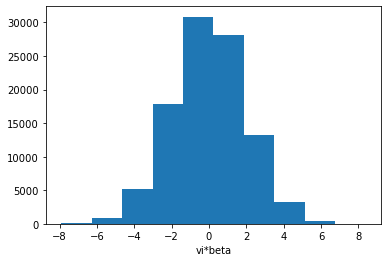

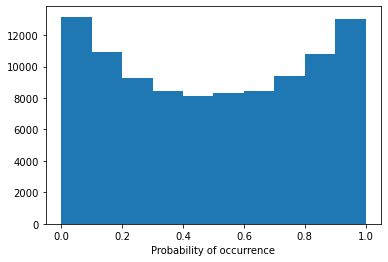

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:05,  2.25s/it]

Model 1/30, Test Accuracy: 0.6936

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:05,  2.33s/it]

Model 2/30, Test Accuracy: 0.6952

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:02,  2.32s/it]

Model 3/30, Test Accuracy: 0.6956

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:00,  2.32s/it]

Model 4/30, Test Accuracy: 0.6958

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:56,  2.28s/it]

Model 5/30, Test Accuracy: 0.6937

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.28s/it]

Model 6/30, Test Accuracy: 0.6956

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:51,  2.26s/it]

Model 7/30, Test Accuracy: 0.6956

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:50,  2.27s/it]

Model 8/30, Test Accuracy: 0.6963

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:48,  2.30s/it]

Model 9/30, Test Accuracy: 0.6951

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:45,  2.27s/it]

Model 10/30, Test Accuracy: 0.6958

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:43,  2.29s/it]

Model 11/30, Test Accuracy: 0.6919

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.30s/it]

Model 12/30, Test Accuracy: 0.6956

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:39,  2.31s/it]

Model 13/30, Test Accuracy: 0.6948

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:37,  2.32s/it]

Model 14/30, Test Accuracy: 0.6939

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:35,  2.34s/it]

Model 15/30, Test Accuracy: 0.6949

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:32,  2.31s/it]

Model 16/30, Test Accuracy: 0.6946

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.32s/it]

Model 17/30, Test Accuracy: 0.6935

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:29,  2.44s/it]

Model 18/30, Test Accuracy: 0.6935

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:26,  2.41s/it]

Model 19/30, Test Accuracy: 0.6950

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.38s/it]

Model 20/30, Test Accuracy: 0.6948

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:49<00:22,  2.47s/it]

Model 21/30, Test Accuracy: 0.6948

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:52<00:20,  2.61s/it]

Model 22/30, Test Accuracy: 0.6931

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:54<00:17,  2.50s/it]

Model 23/30, Test Accuracy: 0.6962

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:56<00:14,  2.45s/it]

Model 24/30, Test Accuracy: 0.6950

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:59<00:12,  2.51s/it]

Model 25/30, Test Accuracy: 0.6950

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:01<00:09,  2.43s/it]

Model 26/30, Test Accuracy: 0.6954

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:03<00:07,  2.35s/it]

Model 27/30, Test Accuracy: 0.6915

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:05<00:04,  2.29s/it]

Model 28/30, Test Accuracy: 0.6945

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:08<00:02,  2.26s/it]

Model 29/30, Test Accuracy: 0.6934

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:10<00:00,  2.34s/it]

Model 30/30, Test Accuracy: 0.6957
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq5_var2_beta_var0.4.pkl


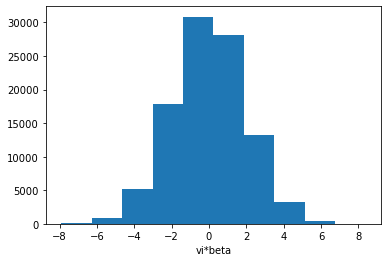

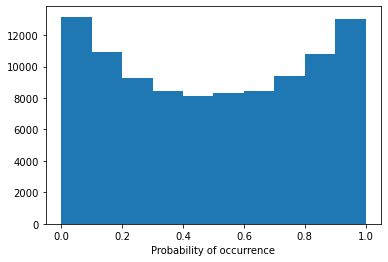

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:02,  2.16s/it]

Model 1/30, Test Accuracy: 0.7081

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:02,  2.24s/it]

Model 2/30, Test Accuracy: 0.7089

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:00,  2.24s/it]

Model 3/30, Test Accuracy: 0.7101

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:58,  2.24s/it]

Model 4/30, Test Accuracy: 0.7097

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:55,  2.21s/it]

Model 5/30, Test Accuracy: 0.7096

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:57,  2.38s/it]

Model 6/30, Test Accuracy: 0.7096

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:53,  2.32s/it]

Model 7/30, Test Accuracy: 0.7105

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:50,  2.30s/it]

Model 8/30, Test Accuracy: 0.7097

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:48,  2.29s/it]

Model 9/30, Test Accuracy: 0.7095

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:46,  2.34s/it]

Model 10/30, Test Accuracy: 0.7084

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:44,  2.33s/it]

Model 11/30, Test Accuracy: 0.7065

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:41,  2.29s/it]

Model 12/30, Test Accuracy: 0.7091

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:38,  2.28s/it]

Model 13/30, Test Accuracy: 0.7094

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:36,  2.28s/it]

Model 14/30, Test Accuracy: 0.7095

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:33,  2.26s/it]

Model 15/30, Test Accuracy: 0.7098

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:33,  2.40s/it]

Model 16/30, Test Accuracy: 0.7090

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.34s/it]

Model 17/30, Test Accuracy: 0.7099

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:27,  2.27s/it]

Model 18/30, Test Accuracy: 0.7107

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:43<00:24,  2.23s/it]

Model 19/30, Test Accuracy: 0.7100

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:45<00:22,  2.23s/it]

Model 20/30, Test Accuracy: 0.7097

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:47<00:20,  2.23s/it]

Model 21/30, Test Accuracy: 0.7103

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:50<00:17,  2.22s/it]

Model 22/30, Test Accuracy: 0.7095

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:52<00:15,  2.21s/it]

Model 23/30, Test Accuracy: 0.7084

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:54<00:13,  2.23s/it]

Model 24/30, Test Accuracy: 0.7088

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:56<00:11,  2.24s/it]

Model 25/30, Test Accuracy: 0.7110

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:59<00:08,  2.24s/it]

Model 26/30, Test Accuracy: 0.7069

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:01<00:06,  2.22s/it]

Model 27/30, Test Accuracy: 0.7070

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:03<00:04,  2.24s/it]

Model 28/30, Test Accuracy: 0.7060

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:05<00:02,  2.24s/it]

Model 29/30, Test Accuracy: 0.7091

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:08<00:00,  2.27s/it]

Model 30/30, Test Accuracy: 0.7089
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq7_var2_beta_var0.4.pkl


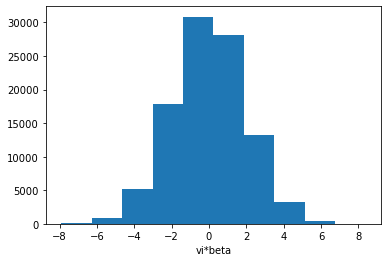

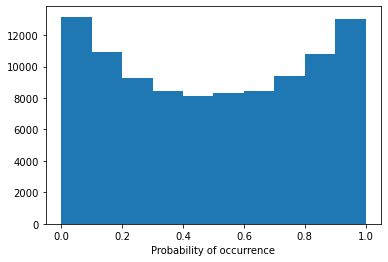

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:02,  2.14s/it]

Model 1/30, Test Accuracy: 0.7183

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:01,  2.19s/it]

Model 2/30, Test Accuracy: 0.7210

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:59,  2.21s/it]

Model 3/30, Test Accuracy: 0.7220

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:57,  2.21s/it]

Model 4/30, Test Accuracy: 0.7206

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:54,  2.18s/it]

Model 5/30, Test Accuracy: 0.7236

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:55,  2.30s/it]

Model 6/30, Test Accuracy: 0.7226

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:52,  2.27s/it]

Model 7/30, Test Accuracy: 0.7222

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:49,  2.27s/it]

Model 8/30, Test Accuracy: 0.7215

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:51,  2.43s/it]

Model 9/30, Test Accuracy: 0.7225

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:46,  2.34s/it]

Model 10/30, Test Accuracy: 0.7225

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:43,  2.31s/it]

Model 11/30, Test Accuracy: 0.7190

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:27<00:43,  2.41s/it]

Model 12/30, Test Accuracy: 0.7207

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:44,  2.61s/it]

Model 13/30, Test Accuracy: 0.7224

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:33<00:40,  2.51s/it]

Model 14/30, Test Accuracy: 0.7230

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:35<00:36,  2.43s/it]

Model 15/30, Test Accuracy: 0.7227

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:37<00:33,  2.36s/it]

Model 16/30, Test Accuracy: 0.7188

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:30,  2.33s/it]

Model 17/30, Test Accuracy: 0.7209

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:27,  2.27s/it]

Model 18/30, Test Accuracy: 0.7198

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:25,  2.33s/it]

Model 19/30, Test Accuracy: 0.7218

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:46<00:23,  2.31s/it]

Model 20/30, Test Accuracy: 0.7185

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:48<00:20,  2.28s/it]

Model 21/30, Test Accuracy: 0.7216

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:51<00:18,  2.27s/it]

Model 22/30, Test Accuracy: 0.7218

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:53<00:15,  2.26s/it]

Model 23/30, Test Accuracy: 0.7203

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:55<00:13,  2.25s/it]

Model 24/30, Test Accuracy: 0.7224

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:57<00:11,  2.28s/it]

Model 25/30, Test Accuracy: 0.7215

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:00<00:09,  2.27s/it]

Model 26/30, Test Accuracy: 0.7184

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:02<00:06,  2.25s/it]

Model 27/30, Test Accuracy: 0.7158

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:05<00:04,  2.40s/it]

Model 28/30, Test Accuracy: 0.7203

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:07<00:02,  2.36s/it]

Model 29/30, Test Accuracy: 0.7222

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:09<00:00,  2.33s/it]

Model 30/30, Test Accuracy: 0.7196
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq10_var2_beta_var0.4.pkl


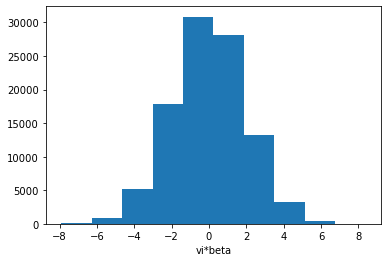

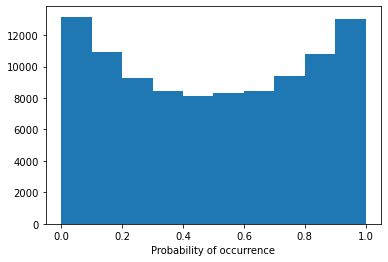

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:16,  2.63s/it]

Model 1/30, Test Accuracy: 0.7336

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:08,  2.46s/it]

Model 2/30, Test Accuracy: 0.7350

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:03,  2.36s/it]

Model 3/30, Test Accuracy: 0.7351

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:01,  2.38s/it]

Model 4/30, Test Accuracy: 0.7338

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:59,  2.36s/it]

Model 5/30, Test Accuracy: 0.7363

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:14<00:56,  2.35s/it]

Model 6/30, Test Accuracy: 0.7361

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:16<00:56,  2.44s/it]

Model 7/30, Test Accuracy: 0.7352

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:19<00:52,  2.41s/it]

Model 8/30, Test Accuracy: 0.7339

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:21<00:50,  2.39s/it]

Model 9/30, Test Accuracy: 0.7353

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:47,  2.35s/it]

Model 10/30, Test Accuracy: 0.7346

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:26<00:44,  2.37s/it]

Model 11/30, Test Accuracy: 0.7302

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:28<00:41,  2.32s/it]

Model 12/30, Test Accuracy: 0.7341

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:39,  2.33s/it]

Model 13/30, Test Accuracy: 0.7357

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:33<00:37,  2.34s/it]

Model 14/30, Test Accuracy: 0.7353

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:35<00:34,  2.33s/it]

Model 15/30, Test Accuracy: 0.7355

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:37<00:32,  2.30s/it]

Model 16/30, Test Accuracy: 0.7324

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:40<00:30,  2.31s/it]

Model 17/30, Test Accuracy: 0.7334

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:42<00:27,  2.30s/it]

Model 18/30, Test Accuracy: 0.7356

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:44<00:25,  2.34s/it]

Model 19/30, Test Accuracy: 0.7370

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:47<00:23,  2.35s/it]

Model 20/30, Test Accuracy: 0.7333

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:49<00:20,  2.33s/it]

Model 21/30, Test Accuracy: 0.7350

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:51<00:18,  2.34s/it]

Model 22/30, Test Accuracy: 0.7345

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:54<00:16,  2.32s/it]

Model 23/30, Test Accuracy: 0.7335

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:56<00:13,  2.33s/it]

Model 24/30, Test Accuracy: 0.7360

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:58<00:11,  2.33s/it]

Model 25/30, Test Accuracy: 0.7346

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [01:01<00:09,  2.33s/it]

Model 26/30, Test Accuracy: 0.7305

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:03<00:07,  2.40s/it]

Model 27/30, Test Accuracy: 0.7287

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:06<00:04,  2.40s/it]

Model 28/30, Test Accuracy: 0.7337

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:08<00:02,  2.39s/it]

Model 29/30, Test Accuracy: 0.7352

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:10<00:00,  2.37s/it]

Model 30/30, Test Accuracy: 0.7348
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq15_var2_beta_var0.4.pkl
Skipping training for epi_mean_ss100000_sq20_var2.pkl


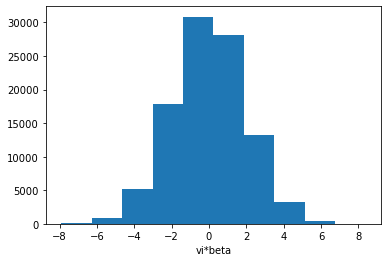

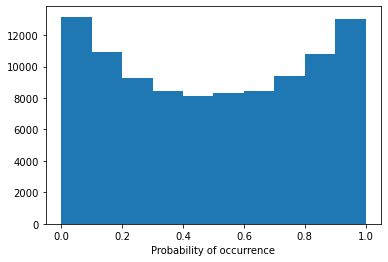

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 17.07it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4612

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4334

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4347

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:01, 17.72it/s]

Model 4/30, Test Accuracy: 0.5216

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5101

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.5804

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5032

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 14.31it/s]

Model 8/30, Test Accuracy: 0.5195

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5093

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5521

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:00<00:00, 16.19it/s]

Model 11/30, Test Accuracy: 0.4835

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5397

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5286

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.4894

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 16.71it/s]

Model 15/30, Test Accuracy: 0.5647

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4601

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4209

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4073

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 17.42it/s]

Model 19/30, Test Accuracy: 0.5543

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4506

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5802

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4371

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:01<00:00, 17.65it/s]

Model 23/30, Test Accuracy: 0.4775

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5614

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4867

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4649

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:01<00:00, 17.11it/s]

Model 27/30, Test Accuracy: 0.4496

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4796

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4906

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4835
Predictions saved to epi_model_limitation/epi_mean_ss10_sq20_var3_beta_var0.4.pkl


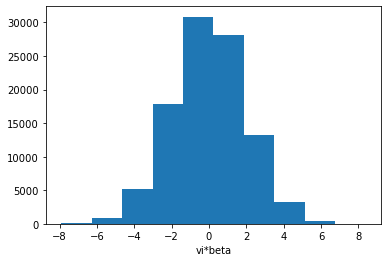

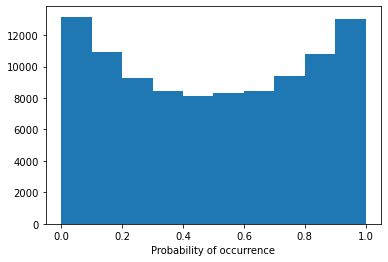

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 17.60it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4634

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4390

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4482

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:00<00:02, 12.42it/s]

Model 4/30, Test Accuracy: 0.5259

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5128

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:00<00:02,  8.37it/s]

Model 6/30, Test Accuracy: 0.5928

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5067

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5308

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5233

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:01<00:01, 12.03it/s]

Model 10/30, Test Accuracy: 0.5613

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4859

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5483

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5329

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:01<00:00, 14.62it/s]

Model 14/30, Test Accuracy: 0.4986

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5729

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4701

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4264

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:01<00:00, 16.25it/s]

Model 18/30, Test Accuracy: 0.4179

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5666

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4617

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:01<00:00, 14.91it/s]

Model 21/30, Test Accuracy: 0.5905

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4359

Training Model 23/30 with dropout seed 0.
Model 23/30, Test Accuracy: 0.4803

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5793

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:02<00:00, 15.65it/s]

Model 25/30, Test Accuracy: 0.4885

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4739

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4502

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4969

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 13.20it/s]


Model 29/30, Test Accuracy: 0.4945

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4903
Predictions saved to epi_model_limitation/epi_mean_ss100_sq20_var3_beta_var0.4.pkl


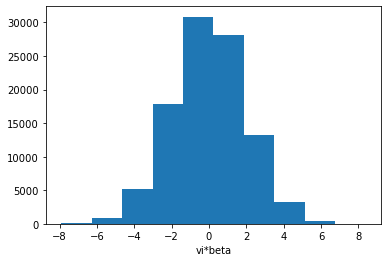

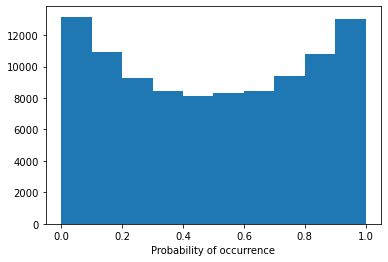

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:02, 12.92it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4671

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4469

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:00<00:02, 12.88it/s]

Model 3/30, Test Accuracy: 0.4419

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5216

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5187

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:00<00:01, 13.04it/s]

Model 6/30, Test Accuracy: 0.5934

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5112

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5356

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 13.11it/s]

Model 9/30, Test Accuracy: 0.5178

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5625

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4855

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:00<00:01, 12.90it/s]

Model 12/30, Test Accuracy: 0.5543

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5416

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:01<00:01, 11.63it/s]

Model 14/30, Test Accuracy: 0.5060

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5742

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4737

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 12.11it/s]

Model 17/30, Test Accuracy: 0.4333

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4162

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5648

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 12.71it/s]

Model 20/30, Test Accuracy: 0.4671

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.6011

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4314

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:01<00:00, 12.27it/s]

Model 23/30, Test Accuracy: 0.4785

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5834

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4873

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:02<00:00, 10.02it/s]

Model 26/30, Test Accuracy: 0.4770

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4547

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:02<00:00,  8.65it/s]

Model 28/30, Test Accuracy: 0.4947

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.5009

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 10.79it/s]


Model 30/30, Test Accuracy: 0.4949
Predictions saved to epi_model_limitation/epi_mean_ss1000_sq20_var3_beta_var0.4.pkl


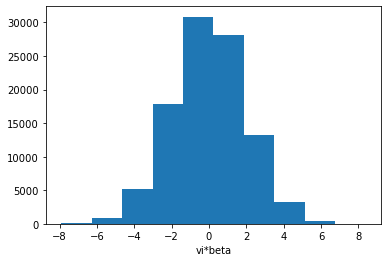

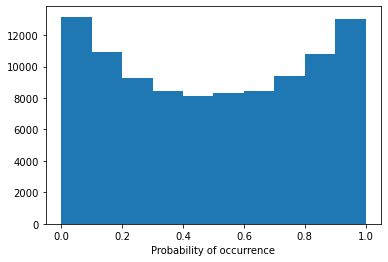

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:14,  2.04it/s]

Model 1/30, Test Accuracy: 0.5363

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:11,  2.35it/s]

Model 2/30, Test Accuracy: 0.5268

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:01<00:10,  2.70it/s]

Model 3/30, Test Accuracy: 0.5281

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:01<00:08,  2.94it/s]

Model 4/30, Test Accuracy: 0.5744

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:01<00:08,  3.09it/s]

Model 5/30, Test Accuracy: 0.5589

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:02<00:07,  3.15it/s]

Model 6/30, Test Accuracy: 0.6572

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:02<00:07,  3.15it/s]

Model 7/30, Test Accuracy: 0.5724

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:02<00:07,  2.97it/s]

Model 8/30, Test Accuracy: 0.5945

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:03<00:06,  3.08it/s]

Model 9/30, Test Accuracy: 0.5703

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:03<00:06,  3.15it/s]

Model 10/30, Test Accuracy: 0.6149

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:03<00:06,  2.91it/s]

Model 11/30, Test Accuracy: 0.5446

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:04<00:05,  3.04it/s]

Model 12/30, Test Accuracy: 0.6010

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:04<00:05,  3.12it/s]

Model 13/30, Test Accuracy: 0.6233

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:04<00:04,  3.22it/s]

Model 14/30, Test Accuracy: 0.5506

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:04<00:04,  3.29it/s]

Model 15/30, Test Accuracy: 0.6140

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:05<00:04,  3.04it/s]

Model 16/30, Test Accuracy: 0.5464

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:05<00:04,  3.11it/s]

Model 17/30, Test Accuracy: 0.5085

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:05<00:03,  3.20it/s]

Model 18/30, Test Accuracy: 0.4649

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:06<00:03,  3.02it/s]

Model 19/30, Test Accuracy: 0.6263

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:06<00:03,  3.12it/s]

Model 20/30, Test Accuracy: 0.5030

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:06<00:02,  3.23it/s]

Model 21/30, Test Accuracy: 0.6597

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:07<00:02,  3.28it/s]

Model 22/30, Test Accuracy: 0.4974

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:07<00:02,  3.34it/s]

Model 23/30, Test Accuracy: 0.5065

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:07<00:01,  3.34it/s]

Model 24/30, Test Accuracy: 0.6526

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:08<00:01,  3.09it/s]

Model 25/30, Test Accuracy: 0.5542

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:08<00:01,  3.15it/s]

Model 26/30, Test Accuracy: 0.5391

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:08<00:01,  2.91it/s]

Model 27/30, Test Accuracy: 0.4869

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:09<00:00,  3.02it/s]

Model 28/30, Test Accuracy: 0.5611

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:09<00:00,  3.12it/s]

Model 29/30, Test Accuracy: 0.5729

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:09<00:00,  3.08it/s]

Model 30/30, Test Accuracy: 0.5561
Predictions saved to epi_model_limitation/epi_mean_ss10000_sq20_var3_beta_var0.4.pkl


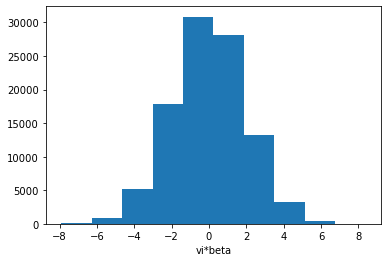

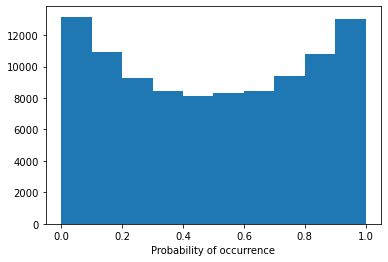

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

Model 1/30, Test Accuracy: 0.6532

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:01<00:23,  1.21it/s]

Model 2/30, Test Accuracy: 0.6816

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:02<00:23,  1.15it/s]

Model 3/30, Test Accuracy: 0.6835

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:03<00:22,  1.15it/s]

Model 4/30, Test Accuracy: 0.6819

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:04<00:21,  1.16it/s]

Model 5/30, Test Accuracy: 0.6623

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:05<00:20,  1.16it/s]

Model 6/30, Test Accuracy: 0.7081

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:06<00:19,  1.15it/s]

Model 7/30, Test Accuracy: 0.6909

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:06<00:18,  1.18it/s]

Model 8/30, Test Accuracy: 0.6908

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:07<00:18,  1.16it/s]

Model 9/30, Test Accuracy: 0.6775

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:08<00:17,  1.15it/s]

Model 10/30, Test Accuracy: 0.6971

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:09<00:16,  1.19it/s]

Model 11/30, Test Accuracy: 0.6438

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:10<00:15,  1.16it/s]

Model 12/30, Test Accuracy: 0.6902

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:11<00:14,  1.16it/s]

Model 13/30, Test Accuracy: 0.7105

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:12<00:13,  1.16it/s]

Model 14/30, Test Accuracy: 0.6575

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:12<00:12,  1.18it/s]

Model 15/30, Test Accuracy: 0.6947

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:13<00:12,  1.16it/s]

Model 16/30, Test Accuracy: 0.6690

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:14<00:11,  1.17it/s]

Model 17/30, Test Accuracy: 0.6549

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:15<00:10,  1.20it/s]

Model 18/30, Test Accuracy: 0.6440

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:16<00:09,  1.18it/s]

Model 19/30, Test Accuracy: 0.6955

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:17<00:08,  1.17it/s]

Model 20/30, Test Accuracy: 0.6204

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:17<00:07,  1.19it/s]

Model 21/30, Test Accuracy: 0.7073

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:18<00:06,  1.17it/s]

Model 22/30, Test Accuracy: 0.6559

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:19<00:06,  1.16it/s]

Model 23/30, Test Accuracy: 0.6357

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:20<00:05,  1.19it/s]

Model 24/30, Test Accuracy: 0.7081

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:21<00:04,  1.02it/s]

Model 25/30, Test Accuracy: 0.6495

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:22<00:04,  1.01s/it]

Model 26/30, Test Accuracy: 0.6567

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:23<00:02,  1.05it/s]

Model 27/30, Test Accuracy: 0.5994

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:24<00:01,  1.08it/s]

Model 28/30, Test Accuracy: 0.6769

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:25<00:00,  1.10it/s]

Model 29/30, Test Accuracy: 0.6771

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]

Model 30/30, Test Accuracy: 0.6770
Predictions saved to epi_model_limitation/epi_mean_ss30000_sq20_var3_beta_var0.4.pkl


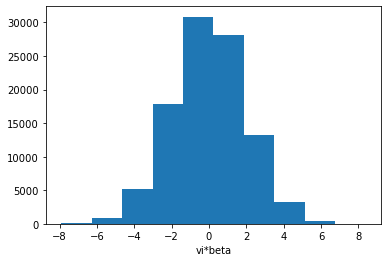

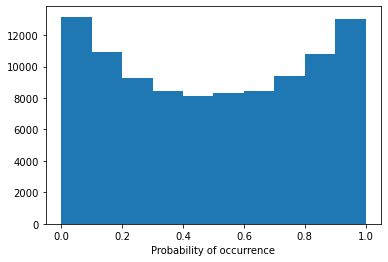

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:40,  1.41s/it]

Model 1/30, Test Accuracy: 0.6987

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:02<00:39,  1.41s/it]

Model 2/30, Test Accuracy: 0.7124

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:04<00:41,  1.53s/it]

Model 3/30, Test Accuracy: 0.7129

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:05<00:39,  1.50s/it]

Model 4/30, Test Accuracy: 0.7100

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:07<00:37,  1.50s/it]

Model 5/30, Test Accuracy: 0.7097

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:08<00:36,  1.50s/it]

Model 6/30, Test Accuracy: 0.7166

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:10<00:33,  1.45s/it]

Model 7/30, Test Accuracy: 0.7128

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:11<00:33,  1.52s/it]

Model 8/30, Test Accuracy: 0.7119

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:13<00:30,  1.46s/it]

Model 9/30, Test Accuracy: 0.7143

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:14<00:29,  1.46s/it]

Model 10/30, Test Accuracy: 0.7155

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:16<00:27,  1.42s/it]

Model 11/30, Test Accuracy: 0.6962

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:18<00:29,  1.61s/it]

Model 12/30, Test Accuracy: 0.7136

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:19<00:25,  1.52s/it]

Model 13/30, Test Accuracy: 0.7155

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:20<00:24,  1.52s/it]

Model 14/30, Test Accuracy: 0.7013

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:22<00:22,  1.49s/it]

Model 15/30, Test Accuracy: 0.7120

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:23<00:20,  1.48s/it]

Model 16/30, Test Accuracy: 0.7014

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:25<00:19,  1.48s/it]

Model 17/30, Test Accuracy: 0.7044

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:26<00:17,  1.47s/it]

Model 18/30, Test Accuracy: 0.7067

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:28<00:15,  1.45s/it]

Model 19/30, Test Accuracy: 0.7176

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:29<00:14,  1.45s/it]

Model 20/30, Test Accuracy: 0.6951

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:31<00:13,  1.45s/it]

Model 21/30, Test Accuracy: 0.7158

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:32<00:11,  1.44s/it]

Model 22/30, Test Accuracy: 0.7049

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:34<00:10,  1.48s/it]

Model 23/30, Test Accuracy: 0.7023

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:35<00:08,  1.47s/it]

Model 24/30, Test Accuracy: 0.7174

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:36<00:07,  1.46s/it]

Model 25/30, Test Accuracy: 0.6983

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:38<00:05,  1.46s/it]

Model 26/30, Test Accuracy: 0.6993

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:39<00:04,  1.45s/it]

Model 27/30, Test Accuracy: 0.6798

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:41<00:02,  1.44s/it]

Model 28/30, Test Accuracy: 0.7087

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:42<00:01,  1.43s/it]

Model 29/30, Test Accuracy: 0.7055

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:44<00:00,  1.47s/it]

Model 30/30, Test Accuracy: 0.7084
Predictions saved to epi_model_limitation/epi_mean_ss50000_sq20_var3_beta_var0.4.pkl


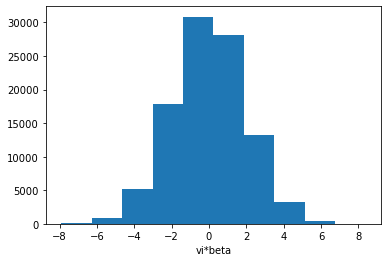

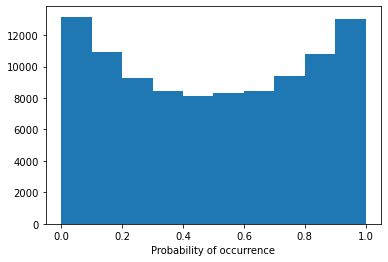

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:56,  1.96s/it]

Model 1/30, Test Accuracy: 0.7147

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:56,  2.01s/it]

Model 2/30, Test Accuracy: 0.7167

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:54,  2.02s/it]

Model 3/30, Test Accuracy: 0.7187

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:07<00:51,  1.99s/it]

Model 4/30, Test Accuracy: 0.7144

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:09<00:49,  1.99s/it]

Model 5/30, Test Accuracy: 0.7176

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:11<00:48,  2.00s/it]

Model 6/30, Test Accuracy: 0.7183

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:13<00:45,  1.98s/it]

Model 7/30, Test Accuracy: 0.7174

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:15<00:42,  1.95s/it]

Model 8/30, Test Accuracy: 0.7167

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:17<00:41,  1.98s/it]

Model 9/30, Test Accuracy: 0.7178

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:20<00:45,  2.28s/it]

Model 10/30, Test Accuracy: 0.7172

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:22<00:42,  2.21s/it]

Model 11/30, Test Accuracy: 0.7133

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:24<00:38,  2.12s/it]

Model 12/30, Test Accuracy: 0.7158

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:26<00:35,  2.10s/it]

Model 13/30, Test Accuracy: 0.7178

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:28<00:32,  2.05s/it]

Model 14/30, Test Accuracy: 0.7165

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:31<00:32,  2.14s/it]

Model 15/30, Test Accuracy: 0.7175

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:33<00:31,  2.24s/it]

Model 16/30, Test Accuracy: 0.7129

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:35<00:28,  2.16s/it]

Model 17/30, Test Accuracy: 0.7166

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:37<00:25,  2.10s/it]

Model 18/30, Test Accuracy: 0.7155

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:39<00:24,  2.21s/it]

Model 19/30, Test Accuracy: 0.7183

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:41<00:21,  2.15s/it]

Model 20/30, Test Accuracy: 0.7137

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:43<00:18,  2.07s/it]

Model 21/30, Test Accuracy: 0.7175

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:45<00:16,  2.02s/it]

Model 22/30, Test Accuracy: 0.7149

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:47<00:14,  2.02s/it]

Model 23/30, Test Accuracy: 0.7150

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:50<00:12,  2.10s/it]

Model 24/30, Test Accuracy: 0.7180

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:51<00:10,  2.04s/it]

Model 25/30, Test Accuracy: 0.7139

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:53<00:07,  2.00s/it]

Model 26/30, Test Accuracy: 0.7117

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:55<00:06,  2.00s/it]

Model 27/30, Test Accuracy: 0.7096

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:57<00:03,  1.98s/it]

Model 28/30, Test Accuracy: 0.7163

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:59<00:01,  2.00s/it]

Model 29/30, Test Accuracy: 0.7150

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:01<00:00,  2.06s/it]

Model 30/30, Test Accuracy: 0.7147
Predictions saved to epi_model_limitation/epi_mean_ss70000_sq20_var3_beta_var0.4.pkl


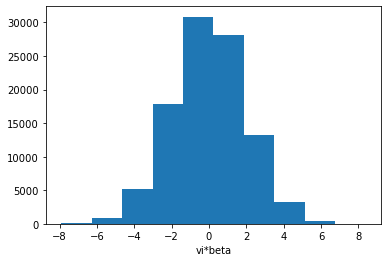

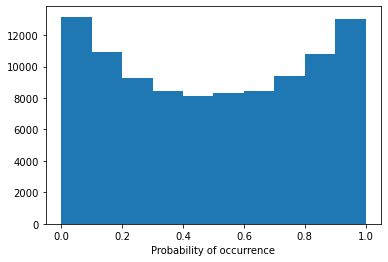

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:06,  2.28s/it]

Model 1/30, Test Accuracy: 0.7143

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:01,  2.21s/it]

Model 2/30, Test Accuracy: 0.7188

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:02,  2.32s/it]

Model 3/30, Test Accuracy: 0.7187

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:00,  2.34s/it]

Model 4/30, Test Accuracy: 0.7173

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:56,  2.26s/it]

Model 5/30, Test Accuracy: 0.7170

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:53,  2.23s/it]

Model 6/30, Test Accuracy: 0.7180

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:50,  2.21s/it]

Model 7/30, Test Accuracy: 0.7186

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:49,  2.25s/it]

Model 8/30, Test Accuracy: 0.7171

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:49,  2.34s/it]

Model 9/30, Test Accuracy: 0.7171

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:45,  2.27s/it]

Model 10/30, Test Accuracy: 0.7176

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:41,  2.21s/it]

Model 11/30, Test Accuracy: 0.7143

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:39,  2.18s/it]

Model 12/30, Test Accuracy: 0.7188

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:36,  2.16s/it]

Model 13/30, Test Accuracy: 0.7185

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:36,  2.28s/it]

Model 14/30, Test Accuracy: 0.7170

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:33,  2.23s/it]

Model 15/30, Test Accuracy: 0.7174

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:30,  2.19s/it]

Model 16/30, Test Accuracy: 0.7139

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:28,  2.17s/it]

Model 17/30, Test Accuracy: 0.7161

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:25,  2.13s/it]

Model 18/30, Test Accuracy: 0.7177

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:42<00:23,  2.12s/it]

Model 19/30, Test Accuracy: 0.7175

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:44<00:21,  2.12s/it]

Model 20/30, Test Accuracy: 0.7151

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:46<00:19,  2.15s/it]

Model 21/30, Test Accuracy: 0.7174

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:17,  2.18s/it]

Model 22/30, Test Accuracy: 0.7162

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:50<00:14,  2.13s/it]

Model 23/30, Test Accuracy: 0.7148

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:52<00:12,  2.12s/it]

Model 24/30, Test Accuracy: 0.7181

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:54<00:10,  2.12s/it]

Model 25/30, Test Accuracy: 0.7141

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:56<00:08,  2.12s/it]

Model 26/30, Test Accuracy: 0.7135

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:59<00:06,  2.10s/it]

Model 27/30, Test Accuracy: 0.7127

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:01<00:04,  2.10s/it]

Model 28/30, Test Accuracy: 0.7157

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:03<00:02,  2.10s/it]

Model 29/30, Test Accuracy: 0.7154

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:05<00:00,  2.18s/it]

Model 30/30, Test Accuracy: 0.7156
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq20_var3_beta_var0.4.pkl


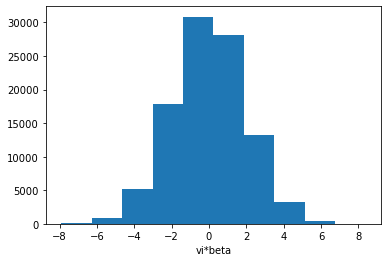

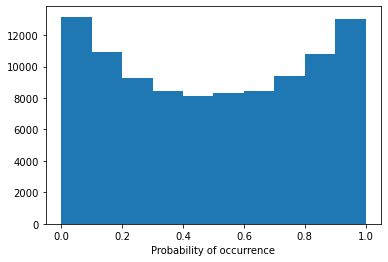

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:02,  2.17s/it]

Model 1/30, Test Accuracy: 0.5746

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:58,  2.10s/it]

Model 2/30, Test Accuracy: 0.5768

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:57,  2.11s/it]

Model 3/30, Test Accuracy: 0.5753

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:55,  2.13s/it]

Model 4/30, Test Accuracy: 0.5748

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:55,  2.22s/it]

Model 5/30, Test Accuracy: 0.5758

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:53,  2.25s/it]

Model 6/30, Test Accuracy: 0.5742

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:50,  2.20s/it]

Model 7/30, Test Accuracy: 0.5754

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:48,  2.23s/it]

Model 8/30, Test Accuracy: 0.5749

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:46,  2.20s/it]

Model 9/30, Test Accuracy: 0.5751

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:21<00:44,  2.20s/it]

Model 10/30, Test Accuracy: 0.5765

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:43,  2.28s/it]

Model 11/30, Test Accuracy: 0.5735

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:40,  2.23s/it]

Model 12/30, Test Accuracy: 0.5740

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:38,  2.25s/it]

Model 13/30, Test Accuracy: 0.5763

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:39,  2.49s/it]

Model 14/30, Test Accuracy: 0.5745

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:36,  2.41s/it]

Model 15/30, Test Accuracy: 0.5729

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:32,  2.32s/it]

Model 16/30, Test Accuracy: 0.5757

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:38<00:29,  2.28s/it]

Model 17/30, Test Accuracy: 0.5727

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:40<00:26,  2.23s/it]

Model 18/30, Test Accuracy: 0.5754

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:42<00:24,  2.26s/it]

Model 19/30, Test Accuracy: 0.5755

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:45<00:22,  2.24s/it]

Model 20/30, Test Accuracy: 0.5740

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:47<00:19,  2.22s/it]

Model 21/30, Test Accuracy: 0.5761

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:49<00:17,  2.22s/it]

Model 22/30, Test Accuracy: 0.5742

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:51<00:15,  2.21s/it]

Model 23/30, Test Accuracy: 0.5746

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:53<00:13,  2.21s/it]

Model 24/30, Test Accuracy: 0.5752

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:55<00:10,  2.19s/it]

Model 25/30, Test Accuracy: 0.5743

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:58<00:08,  2.19s/it]

Model 26/30, Test Accuracy: 0.5742

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:00<00:06,  2.15s/it]

Model 27/30, Test Accuracy: 0.5744

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:02<00:04,  2.14s/it]

Model 28/30, Test Accuracy: 0.5744

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:04<00:02,  2.14s/it]

Model 29/30, Test Accuracy: 0.5734

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.22s/it]

Model 30/30, Test Accuracy: 0.5724
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq1_var3_beta_var0.4.pkl


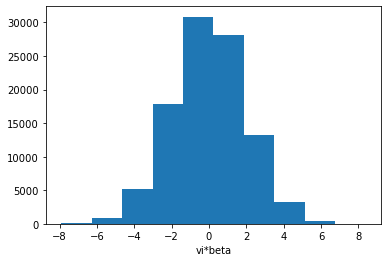

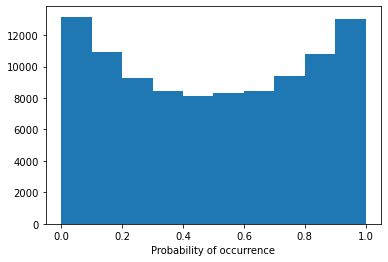

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:03,  2.17s/it]

Model 1/30, Test Accuracy: 0.6248

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:03,  2.27s/it]

Model 2/30, Test Accuracy: 0.6239

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:59,  2.22s/it]

Model 3/30, Test Accuracy: 0.6264

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:57,  2.21s/it]

Model 4/30, Test Accuracy: 0.6251

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:54,  2.20s/it]

Model 5/30, Test Accuracy: 0.6240

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:52,  2.19s/it]

Model 6/30, Test Accuracy: 0.6260

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:49,  2.17s/it]

Model 7/30, Test Accuracy: 0.6250

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:49,  2.26s/it]

Model 8/30, Test Accuracy: 0.6263

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:48,  2.29s/it]

Model 9/30, Test Accuracy: 0.6245

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:44,  2.25s/it]

Model 10/30, Test Accuracy: 0.6252

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:41,  2.20s/it]

Model 11/30, Test Accuracy: 0.6237

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:39,  2.17s/it]

Model 12/30, Test Accuracy: 0.6253

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:36,  2.17s/it]

Model 13/30, Test Accuracy: 0.6247

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:34,  2.16s/it]

Model 14/30, Test Accuracy: 0.6249

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:33,  2.22s/it]

Model 15/30, Test Accuracy: 0.6251

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:30,  2.20s/it]

Model 16/30, Test Accuracy: 0.6257

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:28,  2.19s/it]

Model 17/30, Test Accuracy: 0.6251

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:25,  2.17s/it]

Model 18/30, Test Accuracy: 0.6270

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:24,  2.19s/it]

Model 19/30, Test Accuracy: 0.6253

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:44<00:21,  2.19s/it]

Model 20/30, Test Accuracy: 0.6241

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:46<00:19,  2.17s/it]

Model 21/30, Test Accuracy: 0.6259

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:17,  2.19s/it]

Model 22/30, Test Accuracy: 0.6248

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:50<00:15,  2.18s/it]

Model 23/30, Test Accuracy: 0.6244

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:52<00:13,  2.18s/it]

Model 24/30, Test Accuracy: 0.6263

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:55<00:11,  2.20s/it]

Model 25/30, Test Accuracy: 0.6249

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:57<00:08,  2.21s/it]

Model 26/30, Test Accuracy: 0.6266

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:59<00:06,  2.20s/it]

Model 27/30, Test Accuracy: 0.6242

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:01<00:04,  2.22s/it]

Model 28/30, Test Accuracy: 0.6257

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:03<00:02,  2.21s/it]

Model 29/30, Test Accuracy: 0.6257

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.21s/it]

Model 30/30, Test Accuracy: 0.6257
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq3_var3_beta_var0.4.pkl


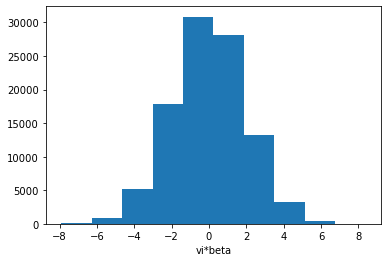

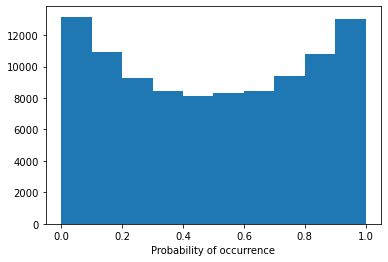

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:07,  2.34s/it]

Model 1/30, Test Accuracy: 0.6550

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:10,  2.50s/it]

Model 2/30, Test Accuracy: 0.6563

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:03,  2.34s/it]

Model 3/30, Test Accuracy: 0.6556

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:03,  2.45s/it]

Model 4/30, Test Accuracy: 0.6552

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:58,  2.35s/it]

Model 5/30, Test Accuracy: 0.6543

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:14<00:55,  2.32s/it]

Model 6/30, Test Accuracy: 0.6554

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:17<00:57,  2.50s/it]

Model 7/30, Test Accuracy: 0.6558

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:19<00:54,  2.46s/it]

Model 8/30, Test Accuracy: 0.6558

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:21<00:49,  2.37s/it]

Model 9/30, Test Accuracy: 0.6555

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:23<00:45,  2.30s/it]

Model 10/30, Test Accuracy: 0.6558

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:25<00:42,  2.26s/it]

Model 11/30, Test Accuracy: 0.6541

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:28<00:40,  2.25s/it]

Model 12/30, Test Accuracy: 0.6552

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:30<00:37,  2.23s/it]

Model 13/30, Test Accuracy: 0.6560

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:32<00:35,  2.25s/it]

Model 14/30, Test Accuracy: 0.6557

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:33,  2.22s/it]

Model 15/30, Test Accuracy: 0.6553

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:30,  2.19s/it]

Model 16/30, Test Accuracy: 0.6560

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:39<00:28,  2.21s/it]

Model 17/30, Test Accuracy: 0.6558

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:41<00:26,  2.19s/it]

Model 18/30, Test Accuracy: 0.6549

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:43<00:23,  2.18s/it]

Model 19/30, Test Accuracy: 0.6552

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:45<00:21,  2.17s/it]

Model 20/30, Test Accuracy: 0.6550

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:47<00:19,  2.16s/it]

Model 21/30, Test Accuracy: 0.6550

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:49<00:17,  2.16s/it]

Model 22/30, Test Accuracy: 0.6548

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:51<00:15,  2.15s/it]

Model 23/30, Test Accuracy: 0.6552

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:54<00:13,  2.22s/it]

Model 24/30, Test Accuracy: 0.6562

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:56<00:11,  2.21s/it]

Model 25/30, Test Accuracy: 0.6557

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:58<00:08,  2.21s/it]

Model 26/30, Test Accuracy: 0.6543

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:00<00:06,  2.18s/it]

Model 27/30, Test Accuracy: 0.6532

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:02<00:04,  2.16s/it]

Model 28/30, Test Accuracy: 0.6543

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:05<00:02,  2.31s/it]

Model 29/30, Test Accuracy: 0.6545

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:07<00:00,  2.26s/it]

Model 30/30, Test Accuracy: 0.6559
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq5_var3_beta_var0.4.pkl


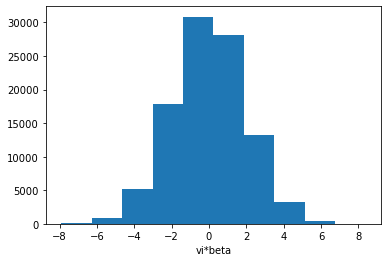

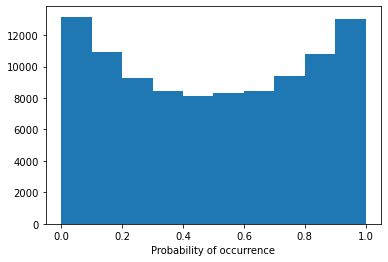

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:04,  2.23s/it]

Model 1/30, Test Accuracy: 0.6694

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:02,  2.23s/it]

Model 2/30, Test Accuracy: 0.6703

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:59,  2.21s/it]

Model 3/30, Test Accuracy: 0.6722

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:57,  2.22s/it]

Model 4/30, Test Accuracy: 0.6705

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:55,  2.21s/it]

Model 5/30, Test Accuracy: 0.6713

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:53,  2.23s/it]

Model 6/30, Test Accuracy: 0.6720

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:51,  2.22s/it]

Model 7/30, Test Accuracy: 0.6704

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:49,  2.23s/it]

Model 8/30, Test Accuracy: 0.6698

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:47,  2.25s/it]

Model 9/30, Test Accuracy: 0.6705

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:44,  2.22s/it]

Model 10/30, Test Accuracy: 0.6715

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:42,  2.22s/it]

Model 11/30, Test Accuracy: 0.6683

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:39,  2.22s/it]

Model 12/30, Test Accuracy: 0.6703

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:37,  2.23s/it]

Model 13/30, Test Accuracy: 0.6716

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:35,  2.25s/it]

Model 14/30, Test Accuracy: 0.6720

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:33,  2.24s/it]

Model 15/30, Test Accuracy: 0.6718

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:31,  2.22s/it]

Model 16/30, Test Accuracy: 0.6703

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:28,  2.21s/it]

Model 17/30, Test Accuracy: 0.6704

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:26,  2.19s/it]

Model 18/30, Test Accuracy: 0.6700

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:42<00:24,  2.21s/it]

Model 19/30, Test Accuracy: 0.6712

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:44<00:22,  2.23s/it]

Model 20/30, Test Accuracy: 0.6703

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:46<00:19,  2.21s/it]

Model 21/30, Test Accuracy: 0.6698

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:17,  2.22s/it]

Model 22/30, Test Accuracy: 0.6706

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:51<00:15,  2.20s/it]

Model 23/30, Test Accuracy: 0.6696

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:53<00:13,  2.22s/it]

Model 24/30, Test Accuracy: 0.6705

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:55<00:11,  2.23s/it]

Model 25/30, Test Accuracy: 0.6714

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:57<00:08,  2.24s/it]

Model 26/30, Test Accuracy: 0.6702

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:59<00:06,  2.20s/it]

Model 27/30, Test Accuracy: 0.6694

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:02<00:04,  2.21s/it]

Model 28/30, Test Accuracy: 0.6704

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:04<00:02,  2.24s/it]

Model 29/30, Test Accuracy: 0.6730

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.22s/it]

Model 30/30, Test Accuracy: 0.6705
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq7_var3_beta_var0.4.pkl


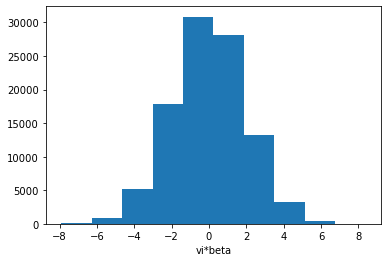

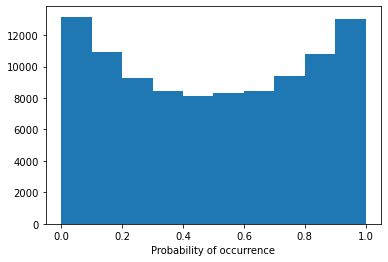

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:25,  2.93s/it]

Model 1/30, Test Accuracy: 0.6844

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:05<01:09,  2.49s/it]

Model 2/30, Test Accuracy: 0.6875

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:07<01:03,  2.35s/it]

Model 3/30, Test Accuracy: 0.6864

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<01:00,  2.32s/it]

Model 4/30, Test Accuracy: 0.6872

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:56,  2.27s/it]

Model 5/30, Test Accuracy: 0.6874

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.26s/it]

Model 6/30, Test Accuracy: 0.6876

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:16<00:51,  2.22s/it]

Model 7/30, Test Accuracy: 0.6869

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:48,  2.21s/it]

Model 8/30, Test Accuracy: 0.6874

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:46,  2.21s/it]

Model 9/30, Test Accuracy: 0.6870

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:43,  2.17s/it]

Model 10/30, Test Accuracy: 0.6874

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:41,  2.18s/it]

Model 11/30, Test Accuracy: 0.6839

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:38,  2.15s/it]

Model 12/30, Test Accuracy: 0.6877

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:36,  2.18s/it]

Model 13/30, Test Accuracy: 0.6876

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:34,  2.18s/it]

Model 14/30, Test Accuracy: 0.6862

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:32,  2.20s/it]

Model 15/30, Test Accuracy: 0.6877

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:30,  2.19s/it]

Model 16/30, Test Accuracy: 0.6873

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:28,  2.21s/it]

Model 17/30, Test Accuracy: 0.6875

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:40<00:26,  2.19s/it]

Model 18/30, Test Accuracy: 0.6854

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:42<00:24,  2.22s/it]

Model 19/30, Test Accuracy: 0.6864

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:44<00:22,  2.25s/it]

Model 20/30, Test Accuracy: 0.6882

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:47<00:20,  2.25s/it]

Model 21/30, Test Accuracy: 0.6865

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:49<00:17,  2.24s/it]

Model 22/30, Test Accuracy: 0.6878

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:51<00:15,  2.22s/it]

Model 23/30, Test Accuracy: 0.6869

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:53<00:13,  2.22s/it]

Model 24/30, Test Accuracy: 0.6864

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:55<00:11,  2.24s/it]

Model 25/30, Test Accuracy: 0.6878

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:58<00:08,  2.23s/it]

Model 26/30, Test Accuracy: 0.6865

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:00<00:06,  2.21s/it]

Model 27/30, Test Accuracy: 0.6854

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:02<00:04,  2.18s/it]

Model 28/30, Test Accuracy: 0.6877

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:04<00:02,  2.20s/it]

Model 29/30, Test Accuracy: 0.6872

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.23s/it]

Model 30/30, Test Accuracy: 0.6860
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq10_var3_beta_var0.4.pkl


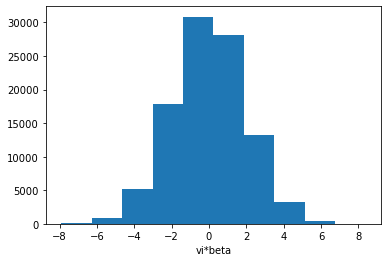

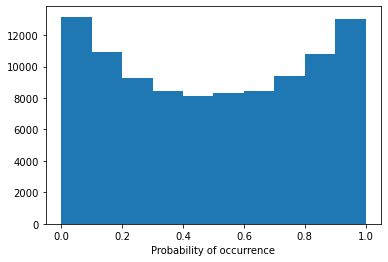

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:01,  2.12s/it]

Model 1/30, Test Accuracy: 0.7025

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:01,  2.19s/it]

Model 2/30, Test Accuracy: 0.7056

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:01,  2.27s/it]

Model 3/30, Test Accuracy: 0.7040

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:09<00:59,  2.29s/it]

Model 4/30, Test Accuracy: 0.7046

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:56,  2.26s/it]

Model 5/30, Test Accuracy: 0.7033

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:54,  2.25s/it]

Model 6/30, Test Accuracy: 0.7053

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:51,  2.23s/it]

Model 7/30, Test Accuracy: 0.7050

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:48,  2.22s/it]

Model 8/30, Test Accuracy: 0.7044

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:46,  2.24s/it]

Model 9/30, Test Accuracy: 0.7048

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:44,  2.22s/it]

Model 10/30, Test Accuracy: 0.7052

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:42,  2.25s/it]

Model 11/30, Test Accuracy: 0.7036

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:40,  2.26s/it]

Model 12/30, Test Accuracy: 0.7046

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:38,  2.28s/it]

Model 13/30, Test Accuracy: 0.7046

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:36,  2.27s/it]

Model 14/30, Test Accuracy: 0.7047

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:34,  2.27s/it]

Model 15/30, Test Accuracy: 0.7064

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:31,  2.27s/it]

Model 16/30, Test Accuracy: 0.7030

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:38<00:29,  2.29s/it]

Model 17/30, Test Accuracy: 0.7038

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:40<00:27,  2.28s/it]

Model 18/30, Test Accuracy: 0.7058

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:42<00:25,  2.28s/it]

Model 19/30, Test Accuracy: 0.7055

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:45<00:23,  2.30s/it]

Model 20/30, Test Accuracy: 0.7053

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:47<00:20,  2.28s/it]

Model 21/30, Test Accuracy: 0.7041

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:49<00:18,  2.30s/it]

Model 22/30, Test Accuracy: 0.7031

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:52<00:15,  2.28s/it]

Model 23/30, Test Accuracy: 0.7044

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:54<00:13,  2.31s/it]

Model 24/30, Test Accuracy: 0.7045

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:57<00:12,  2.51s/it]

Model 25/30, Test Accuracy: 0.7038

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:59<00:09,  2.45s/it]

Model 26/30, Test Accuracy: 0.7006

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:02<00:07,  2.39s/it]

Model 27/30, Test Accuracy: 0.7035

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:04<00:04,  2.34s/it]

Model 28/30, Test Accuracy: 0.7024

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:06<00:02,  2.35s/it]

Model 29/30, Test Accuracy: 0.7039

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:08<00:00,  2.29s/it]

Model 30/30, Test Accuracy: 0.7058
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq15_var3_beta_var0.4.pkl
Skipping training for epi_mean_ss100000_sq20_var3.pkl


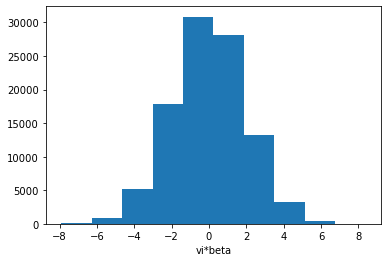

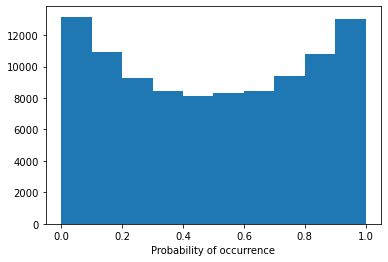

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 19.21it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4657

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4396

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4427

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:00<00:01, 19.35it/s]

Model 4/30, Test Accuracy: 0.5205

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5075

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.5728

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5029

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:00<00:01, 15.15it/s]

Model 8/30, Test Accuracy: 0.5157

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5075

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5496

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:00<00:01, 16.78it/s]

Model 11/30, Test Accuracy: 0.4811

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5384

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5242

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.4906

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:00<00:00, 17.92it/s]

Model 15/30, Test Accuracy: 0.5619

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4633

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4262

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4174

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:01<00:00, 18.08it/s]

Model 19/30, Test Accuracy: 0.5491

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4563

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5721

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4420

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:01<00:00, 18.64it/s]

Model 23/30, Test Accuracy: 0.4815

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5554

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4873

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:01<00:00, 16.22it/s]

Model 26/30, Test Accuracy: 0.4658

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4537

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4833

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4920

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:01<00:00, 17.15it/s]


Model 30/30, Test Accuracy: 0.4865
Predictions saved to epi_model_limitation/epi_mean_ss10_sq20_var4_beta_var0.4.pkl


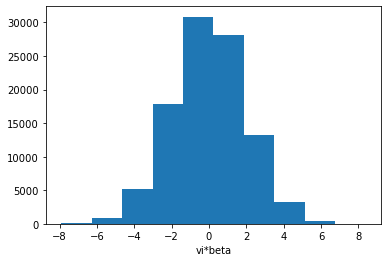

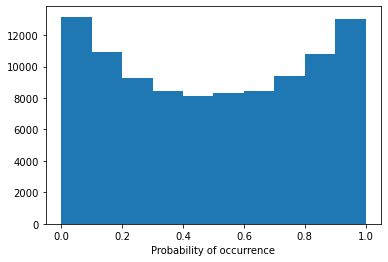

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 17.55it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4666

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4457

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4520

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:01, 16.62it/s]

Model 4/30, Test Accuracy: 0.5222

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5149

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.5843

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5020

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 16.93it/s]

Model 8/30, Test Accuracy: 0.5265

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5222

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5541

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4885

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:00<00:01, 14.19it/s]

Model 12/30, Test Accuracy: 0.5439

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5302

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.4975

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 15.44it/s]

Model 15/30, Test Accuracy: 0.5637

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4737

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4292

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4259

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 16.40it/s]

Model 19/30, Test Accuracy: 0.5607

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4652

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5816

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4424

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:01<00:00, 15.92it/s]

Model 23/30, Test Accuracy: 0.4827

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5691

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4899

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4749

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:01<00:00, 16.44it/s]

Model 27/30, Test Accuracy: 0.4563

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4973

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4949

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:01<00:00, 15.57it/s]


Model 30/30, Test Accuracy: 0.4914
Predictions saved to epi_model_limitation/epi_mean_ss100_sq20_var4_beta_var0.4.pkl


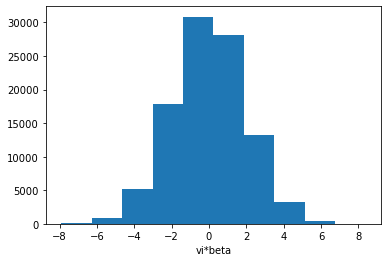

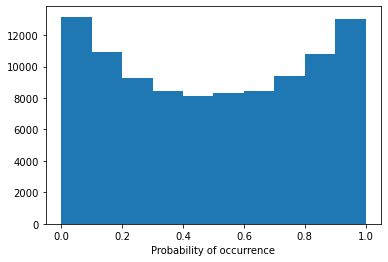

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:02, 13.48it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4689

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4510

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:00<00:01, 13.59it/s]

Model 3/30, Test Accuracy: 0.4459

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5193

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5154

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:00<00:01, 13.64it/s]

Model 6/30, Test Accuracy: 0.5814

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5071

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5321

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 13.59it/s]

Model 9/30, Test Accuracy: 0.5134

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5552

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4860

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:01<00:01, 13.53it/s]

Model 12/30, Test Accuracy: 0.5482

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5385

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.5068

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:01<00:01, 13.58it/s]

Model 15/30, Test Accuracy: 0.5656

Training Model 16/30 with dropout seed 0.
Model 16/30, Test Accuracy: 0.4764

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4376

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 13.58it/s]

Model 18/30, Test Accuracy: 0.4239

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5594

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 12.03it/s]

Model 20/30, Test Accuracy: 0.4703

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5900

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4383

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:01<00:00, 12.44it/s]

Model 23/30, Test Accuracy: 0.4749

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5736

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4878

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:02<00:00, 13.03it/s]

Model 26/30, Test Accuracy: 0.4813

Training Model 27/30 with dropout seed 0.
Model 27/30, Test Accuracy: 0.4573

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4934

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 13.06it/s]


Model 29/30, Test Accuracy: 0.4995

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4980
Predictions saved to epi_model_limitation/epi_mean_ss1000_sq20_var4_beta_var0.4.pkl


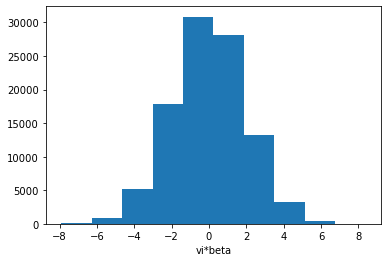

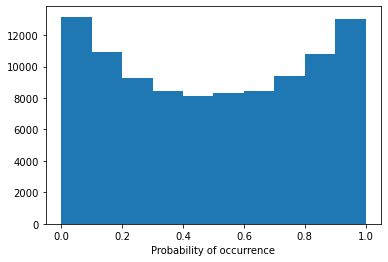

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:10,  2.81it/s]

Model 1/30, Test Accuracy: 0.5252

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:08,  3.30it/s]

Model 2/30, Test Accuracy: 0.5188

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:00<00:07,  3.43it/s]

Model 3/30, Test Accuracy: 0.5211

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:01<00:07,  3.54it/s]

Model 4/30, Test Accuracy: 0.5645

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:01<00:06,  3.59it/s]

Model 5/30, Test Accuracy: 0.5433

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:01<00:07,  3.26it/s]

Model 6/30, Test Accuracy: 0.6372

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:02<00:06,  3.32it/s]

Model 7/30, Test Accuracy: 0.5599

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:02<00:06,  3.43it/s]

Model 8/30, Test Accuracy: 0.5796

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:02<00:06,  3.24it/s]

Model 9/30, Test Accuracy: 0.5558

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:02<00:05,  3.35it/s]

Model 10/30, Test Accuracy: 0.5962

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:03<00:05,  3.45it/s]

Model 11/30, Test Accuracy: 0.5359

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:03<00:05,  3.52it/s]

Model 12/30, Test Accuracy: 0.5874

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:03<00:04,  3.56it/s]

Model 13/30, Test Accuracy: 0.6097

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:04<00:04,  3.29it/s]

Model 14/30, Test Accuracy: 0.5423

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:04<00:04,  3.37it/s]

Model 15/30, Test Accuracy: 0.5985

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:04<00:04,  3.43it/s]

Model 16/30, Test Accuracy: 0.5416

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:05<00:04,  3.23it/s]

Model 17/30, Test Accuracy: 0.5022

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:05<00:03,  3.33it/s]

Model 18/30, Test Accuracy: 0.4653

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:05<00:03,  3.42it/s]

Model 19/30, Test Accuracy: 0.6090

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:05<00:02,  3.45it/s]

Model 20/30, Test Accuracy: 0.4945

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:06<00:02,  3.49it/s]

Model 21/30, Test Accuracy: 0.6369

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:06<00:02,  3.56it/s]

Model 22/30, Test Accuracy: 0.4933

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:06<00:02,  3.31it/s]

Model 23/30, Test Accuracy: 0.4990

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:07<00:01,  3.39it/s]

Model 24/30, Test Accuracy: 0.6345

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:07<00:01,  3.07it/s]

Model 25/30, Test Accuracy: 0.5424

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:07<00:01,  3.04it/s]

Model 26/30, Test Accuracy: 0.5341

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:08<00:00,  3.15it/s]

Model 27/30, Test Accuracy: 0.4855

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:08<00:00,  3.27it/s]

Model 28/30, Test Accuracy: 0.5471

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:08<00:00,  3.37it/s]

Model 29/30, Test Accuracy: 0.5649

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:08<00:00,  3.35it/s]

Model 30/30, Test Accuracy: 0.5452
Predictions saved to epi_model_limitation/epi_mean_ss10000_sq20_var4_beta_var0.4.pkl


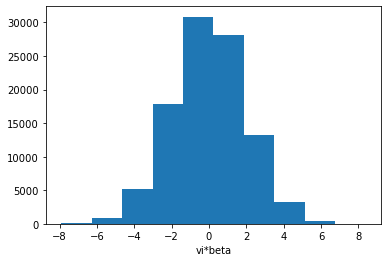

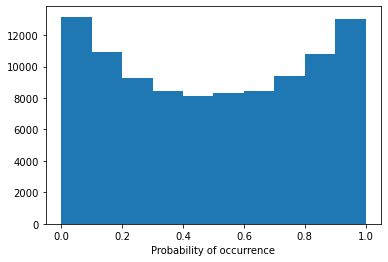

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:23,  1.23it/s]

Model 1/30, Test Accuracy: 0.6313

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:01<00:21,  1.32it/s]

Model 2/30, Test Accuracy: 0.6589

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:02<00:21,  1.28it/s]

Model 3/30, Test Accuracy: 0.6616

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:03<00:20,  1.26it/s]

Model 4/30, Test Accuracy: 0.6609

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:03<00:19,  1.29it/s]

Model 5/30, Test Accuracy: 0.6408

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:04<00:18,  1.27it/s]

Model 6/30, Test Accuracy: 0.6804

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:05<00:18,  1.25it/s]

Model 7/30, Test Accuracy: 0.6706

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:06<00:17,  1.28it/s]

Model 8/30, Test Accuracy: 0.6689

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:07<00:16,  1.26it/s]

Model 9/30, Test Accuracy: 0.6552

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:07<00:16,  1.24it/s]

Model 10/30, Test Accuracy: 0.6733

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:08<00:14,  1.27it/s]

Model 11/30, Test Accuracy: 0.6197

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:09<00:14,  1.24it/s]

Model 12/30, Test Accuracy: 0.6663

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:10<00:13,  1.23it/s]

Model 13/30, Test Accuracy: 0.6865

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:11<00:12,  1.26it/s]

Model 14/30, Test Accuracy: 0.6346

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:11<00:12,  1.24it/s]

Model 15/30, Test Accuracy: 0.6685

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:12<00:11,  1.23it/s]

Model 16/30, Test Accuracy: 0.6491

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:13<00:10,  1.26it/s]

Model 17/30, Test Accuracy: 0.6375

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:14<00:09,  1.24it/s]

Model 18/30, Test Accuracy: 0.6246

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:15<00:08,  1.23it/s]

Model 19/30, Test Accuracy: 0.6727

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:15<00:08,  1.25it/s]

Model 20/30, Test Accuracy: 0.6022

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:16<00:07,  1.24it/s]

Model 21/30, Test Accuracy: 0.6822

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:17<00:06,  1.21it/s]

Model 22/30, Test Accuracy: 0.6345

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

Model 23/30, Test Accuracy: 0.6155

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:19<00:04,  1.25it/s]

Model 24/30, Test Accuracy: 0.6828

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:20<00:04,  1.22it/s]

Model 25/30, Test Accuracy: 0.6254

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:20<00:03,  1.22it/s]

Model 26/30, Test Accuracy: 0.6350

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:21<00:02,  1.24it/s]

Model 27/30, Test Accuracy: 0.5812

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:22<00:01,  1.23it/s]

Model 28/30, Test Accuracy: 0.6547

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:23<00:00,  1.22it/s]

Model 29/30, Test Accuracy: 0.6562

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s]

Model 30/30, Test Accuracy: 0.6561
Predictions saved to epi_model_limitation/epi_mean_ss30000_sq20_var4_beta_var0.4.pkl


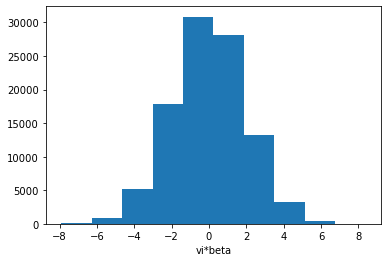

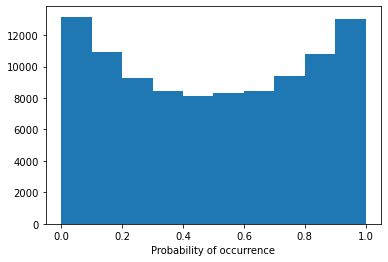

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:38,  1.33s/it]

Model 1/30, Test Accuracy: 0.6753

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:02<00:37,  1.35s/it]

Model 2/30, Test Accuracy: 0.6869

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:03<00:34,  1.29s/it]

Model 3/30, Test Accuracy: 0.6868

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:05<00:34,  1.31s/it]

Model 4/30, Test Accuracy: 0.6863

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:06<00:31,  1.28s/it]

Model 5/30, Test Accuracy: 0.6875

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:07<00:31,  1.31s/it]

Model 6/30, Test Accuracy: 0.6875

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:09<00:29,  1.29s/it]

Model 7/30, Test Accuracy: 0.6863

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:10<00:29,  1.32s/it]

Model 8/30, Test Accuracy: 0.6847

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:11<00:27,  1.29s/it]

Model 9/30, Test Accuracy: 0.6869

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:13<00:26,  1.33s/it]

Model 10/30, Test Accuracy: 0.6892

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:14<00:24,  1.30s/it]

Model 11/30, Test Accuracy: 0.6734

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:15<00:23,  1.33s/it]

Model 12/30, Test Accuracy: 0.6885

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:17<00:22,  1.32s/it]

Model 13/30, Test Accuracy: 0.6892

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:18<00:21,  1.32s/it]

Model 14/30, Test Accuracy: 0.6781

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:19<00:19,  1.32s/it]

Model 15/30, Test Accuracy: 0.6866

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:21<00:18,  1.33s/it]

Model 16/30, Test Accuracy: 0.6798

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:22<00:17,  1.33s/it]

Model 17/30, Test Accuracy: 0.6831

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:23<00:15,  1.33s/it]

Model 18/30, Test Accuracy: 0.6815

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:25<00:14,  1.33s/it]

Model 19/30, Test Accuracy: 0.6876

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:26<00:13,  1.32s/it]

Model 20/30, Test Accuracy: 0.6727

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:27<00:11,  1.32s/it]

Model 21/30, Test Accuracy: 0.6894

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:28<00:10,  1.31s/it]

Model 22/30, Test Accuracy: 0.6829

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:30<00:09,  1.32s/it]

Model 23/30, Test Accuracy: 0.6804

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:31<00:07,  1.32s/it]

Model 24/30, Test Accuracy: 0.6890

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:32<00:06,  1.34s/it]

Model 25/30, Test Accuracy: 0.6751

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:34<00:05,  1.34s/it]

Model 26/30, Test Accuracy: 0.6744

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:35<00:03,  1.33s/it]

Model 27/30, Test Accuracy: 0.6646

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:36<00:02,  1.33s/it]

Model 28/30, Test Accuracy: 0.6794

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:38<00:01,  1.33s/it]

Model 29/30, Test Accuracy: 0.6835

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]

Model 30/30, Test Accuracy: 0.6861
Predictions saved to epi_model_limitation/epi_mean_ss50000_sq20_var4_beta_var0.4.pkl


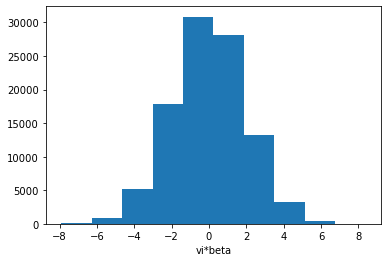

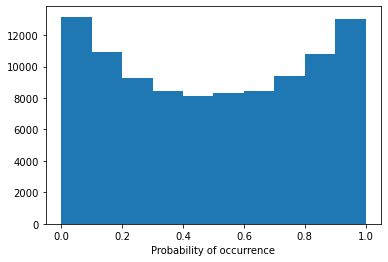

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:51,  1.78s/it]

Model 1/30, Test Accuracy: 0.6894

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:03<00:51,  1.82s/it]

Model 2/30, Test Accuracy: 0.6923

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:05<00:49,  1.84s/it]

Model 3/30, Test Accuracy: 0.6924

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:07<00:47,  1.83s/it]

Model 4/30, Test Accuracy: 0.6903

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:09<00:45,  1.82s/it]

Model 5/30, Test Accuracy: 0.6911

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:11<00:44,  1.85s/it]

Model 6/30, Test Accuracy: 0.6906

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:12<00:42,  1.83s/it]

Model 7/30, Test Accuracy: 0.6918

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:14<00:40,  1.85s/it]

Model 8/30, Test Accuracy: 0.6895

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:16<00:39,  1.87s/it]

Model 9/30, Test Accuracy: 0.6900

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:18<00:37,  1.87s/it]

Model 10/30, Test Accuracy: 0.6918

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:20<00:35,  1.84s/it]

Model 11/30, Test Accuracy: 0.6883

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:22<00:32,  1.83s/it]

Model 12/30, Test Accuracy: 0.6909

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:24<00:32,  1.94s/it]

Model 13/30, Test Accuracy: 0.6912

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:26<00:32,  2.03s/it]

Model 14/30, Test Accuracy: 0.6901

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:28<00:29,  1.99s/it]

Model 15/30, Test Accuracy: 0.6912

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:30<00:27,  1.96s/it]

Model 16/30, Test Accuracy: 0.6875

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:32<00:25,  1.96s/it]

Model 17/30, Test Accuracy: 0.6912

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:34<00:23,  1.92s/it]

Model 18/30, Test Accuracy: 0.6903

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:35<00:20,  1.88s/it]

Model 19/30, Test Accuracy: 0.6902

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:37<00:18,  1.89s/it]

Model 20/30, Test Accuracy: 0.6905

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:39<00:16,  1.87s/it]

Model 21/30, Test Accuracy: 0.6915

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:41<00:15,  1.88s/it]

Model 22/30, Test Accuracy: 0.6903

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:43<00:13,  1.87s/it]

Model 23/30, Test Accuracy: 0.6909

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:45<00:11,  1.88s/it]

Model 24/30, Test Accuracy: 0.6906

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:47<00:09,  1.87s/it]

Model 25/30, Test Accuracy: 0.6907

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:48<00:07,  1.87s/it]

Model 26/30, Test Accuracy: 0.6889

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:50<00:05,  1.89s/it]

Model 27/30, Test Accuracy: 0.6881

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:52<00:03,  1.87s/it]

Model 28/30, Test Accuracy: 0.6911

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:54<00:01,  1.88s/it]

Model 29/30, Test Accuracy: 0.6908

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]

Model 30/30, Test Accuracy: 0.6895
Predictions saved to epi_model_limitation/epi_mean_ss70000_sq20_var4_beta_var0.4.pkl


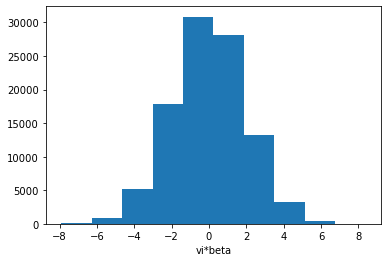

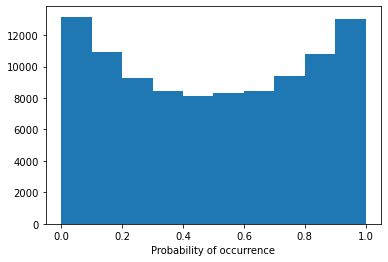

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:03,  2.18s/it]

Model 1/30, Test Accuracy: 0.6882

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:59,  2.14s/it]

Model 2/30, Test Accuracy: 0.6913

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:59,  2.20s/it]

Model 3/30, Test Accuracy: 0.6914

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:57,  2.21s/it]

Model 4/30, Test Accuracy: 0.6904

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:55,  2.20s/it]

Model 5/30, Test Accuracy: 0.6906

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:53,  2.21s/it]

Model 6/30, Test Accuracy: 0.6909

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:50,  2.18s/it]

Model 7/30, Test Accuracy: 0.6913

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:47,  2.18s/it]

Model 8/30, Test Accuracy: 0.6898

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:45,  2.19s/it]

Model 9/30, Test Accuracy: 0.6898

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:21<00:43,  2.18s/it]

Model 10/30, Test Accuracy: 0.6913

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:23<00:41,  2.16s/it]

Model 11/30, Test Accuracy: 0.6896

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:38,  2.16s/it]

Model 12/30, Test Accuracy: 0.6911

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:36,  2.15s/it]

Model 13/30, Test Accuracy: 0.6917

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:34,  2.14s/it]

Model 14/30, Test Accuracy: 0.6893

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:32<00:32,  2.17s/it]

Model 15/30, Test Accuracy: 0.6899

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:34<00:29,  2.13s/it]

Model 16/30, Test Accuracy: 0.6885

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:36<00:27,  2.13s/it]

Model 17/30, Test Accuracy: 0.6898

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:38<00:25,  2.11s/it]

Model 18/30, Test Accuracy: 0.6914

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:23,  2.13s/it]

Model 19/30, Test Accuracy: 0.6916

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:43<00:21,  2.13s/it]

Model 20/30, Test Accuracy: 0.6891

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:45<00:19,  2.13s/it]

Model 21/30, Test Accuracy: 0.6903

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:47<00:16,  2.10s/it]

Model 22/30, Test Accuracy: 0.6895

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:49<00:14,  2.10s/it]

Model 23/30, Test Accuracy: 0.6896

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:51<00:12,  2.11s/it]

Model 24/30, Test Accuracy: 0.6922

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:53<00:10,  2.15s/it]

Model 25/30, Test Accuracy: 0.6892

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:56<00:08,  2.17s/it]

Model 26/30, Test Accuracy: 0.6874

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:58<00:06,  2.14s/it]

Model 27/30, Test Accuracy: 0.6892

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:00<00:04,  2.14s/it]

Model 28/30, Test Accuracy: 0.6889

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:02<00:02,  2.14s/it]

Model 29/30, Test Accuracy: 0.6901

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:04<00:00,  2.15s/it]

Model 30/30, Test Accuracy: 0.6911
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq20_var4_beta_var0.4.pkl


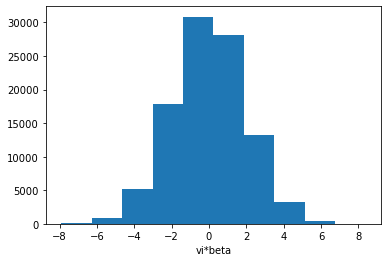

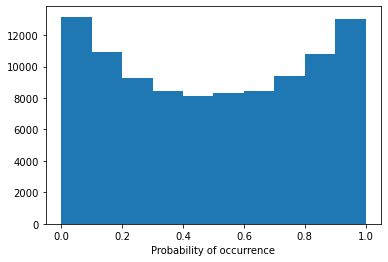

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:00,  2.09s/it]

Model 1/30, Test Accuracy: 0.5565

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:58,  2.07s/it]

Model 2/30, Test Accuracy: 0.5568

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:57,  2.14s/it]

Model 3/30, Test Accuracy: 0.5563

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:55,  2.13s/it]

Model 4/30, Test Accuracy: 0.5535

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:52,  2.12s/it]

Model 5/30, Test Accuracy: 0.5589

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:12<00:51,  2.13s/it]

Model 6/30, Test Accuracy: 0.5535

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:14<00:49,  2.13s/it]

Model 7/30, Test Accuracy: 0.5579

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:47,  2.14s/it]

Model 8/30, Test Accuracy: 0.5564

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:45,  2.14s/it]

Model 9/30, Test Accuracy: 0.5548

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:21<00:44,  2.23s/it]

Model 10/30, Test Accuracy: 0.5561

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:46,  2.44s/it]

Model 11/30, Test Accuracy: 0.5559

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:42,  2.36s/it]

Model 12/30, Test Accuracy: 0.5568

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:39,  2.31s/it]

Model 13/30, Test Accuracy: 0.5575

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:36,  2.27s/it]

Model 14/30, Test Accuracy: 0.5550

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:33,  2.25s/it]

Model 15/30, Test Accuracy: 0.5514

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:30,  2.21s/it]

Model 16/30, Test Accuracy: 0.5569

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:28,  2.20s/it]

Model 17/30, Test Accuracy: 0.5559

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:25,  2.16s/it]

Model 18/30, Test Accuracy: 0.5556

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:23,  2.17s/it]

Model 19/30, Test Accuracy: 0.5563

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:44<00:21,  2.18s/it]

Model 20/30, Test Accuracy: 0.5565

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:46<00:20,  2.33s/it]

Model 21/30, Test Accuracy: 0.5579

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:18,  2.28s/it]

Model 22/30, Test Accuracy: 0.5555

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:50<00:15,  2.23s/it]

Model 23/30, Test Accuracy: 0.5575

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:53<00:13,  2.20s/it]

Model 24/30, Test Accuracy: 0.5551

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:55<00:10,  2.17s/it]

Model 25/30, Test Accuracy: 0.5558

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:57<00:08,  2.16s/it]

Model 26/30, Test Accuracy: 0.5548

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:59<00:06,  2.16s/it]

Model 27/30, Test Accuracy: 0.5571

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:01<00:04,  2.17s/it]

Model 28/30, Test Accuracy: 0.5561

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:03<00:02,  2.17s/it]

Model 29/30, Test Accuracy: 0.5557

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.20s/it]

Model 30/30, Test Accuracy: 0.5528
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq1_var4_beta_var0.4.pkl


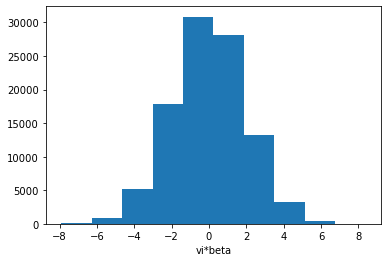

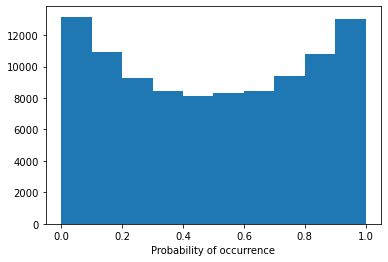

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:02,  2.14s/it]

Model 1/30, Test Accuracy: 0.5976

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:00,  2.16s/it]

Model 2/30, Test Accuracy: 0.5972

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:59,  2.19s/it]

Model 3/30, Test Accuracy: 0.5988

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:57,  2.22s/it]

Model 4/30, Test Accuracy: 0.5984

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:54,  2.19s/it]

Model 5/30, Test Accuracy: 0.5976

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:52,  2.18s/it]

Model 6/30, Test Accuracy: 0.5979

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:50,  2.18s/it]

Model 7/30, Test Accuracy: 0.5978

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:47,  2.18s/it]

Model 8/30, Test Accuracy: 0.5981

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:45,  2.19s/it]

Model 9/30, Test Accuracy: 0.5990

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:21<00:43,  2.17s/it]

Model 10/30, Test Accuracy: 0.5977

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:23<00:41,  2.17s/it]

Model 11/30, Test Accuracy: 0.5966

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:38,  2.15s/it]

Model 12/30, Test Accuracy: 0.5981

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:36,  2.17s/it]

Model 13/30, Test Accuracy: 0.5969

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:34,  2.17s/it]

Model 14/30, Test Accuracy: 0.5982

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:32<00:32,  2.18s/it]

Model 15/30, Test Accuracy: 0.5983

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:34<00:30,  2.16s/it]

Model 16/30, Test Accuracy: 0.5984

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:36<00:28,  2.16s/it]

Model 17/30, Test Accuracy: 0.5977

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:25,  2.15s/it]

Model 18/30, Test Accuracy: 0.5983

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:24,  2.22s/it]

Model 19/30, Test Accuracy: 0.5992

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:43<00:22,  2.22s/it]

Model 20/30, Test Accuracy: 0.5977

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:45<00:19,  2.19s/it]

Model 21/30, Test Accuracy: 0.5970

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:47<00:17,  2.17s/it]

Model 22/30, Test Accuracy: 0.5966

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:49<00:14,  2.14s/it]

Model 23/30, Test Accuracy: 0.5977

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:52<00:12,  2.14s/it]

Model 24/30, Test Accuracy: 0.5988

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:54<00:10,  2.15s/it]

Model 25/30, Test Accuracy: 0.5975

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:56<00:08,  2.15s/it]

Model 26/30, Test Accuracy: 0.5966

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:58<00:06,  2.15s/it]

Model 27/30, Test Accuracy: 0.5985

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:00<00:04,  2.15s/it]

Model 28/30, Test Accuracy: 0.5997

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:02<00:02,  2.15s/it]

Model 29/30, Test Accuracy: 0.5985

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:05<00:00,  2.17s/it]

Model 30/30, Test Accuracy: 0.5982
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq3_var4_beta_var0.4.pkl


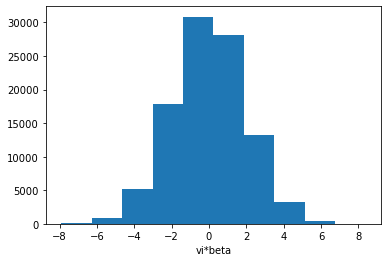

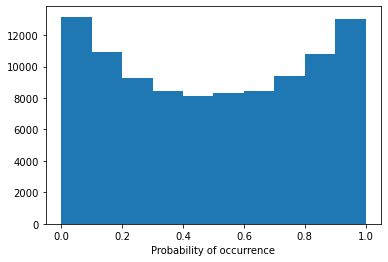

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<00:59,  2.05s/it]

Model 1/30, Test Accuracy: 0.6246

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:58,  2.09s/it]

Model 2/30, Test Accuracy: 0.6273

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:56,  2.10s/it]

Model 3/30, Test Accuracy: 0.6264

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:54,  2.11s/it]

Model 4/30, Test Accuracy: 0.6263

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<01:01,  2.45s/it]

Model 5/30, Test Accuracy: 0.6258

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:57,  2.41s/it]

Model 6/30, Test Accuracy: 0.6270

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:53,  2.32s/it]

Model 7/30, Test Accuracy: 0.6259

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:18<00:50,  2.29s/it]

Model 8/30, Test Accuracy: 0.6270

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:47,  2.26s/it]

Model 9/30, Test Accuracy: 0.6272

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:44,  2.22s/it]

Model 10/30, Test Accuracy: 0.6269

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:42,  2.22s/it]

Model 11/30, Test Accuracy: 0.6248

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:39,  2.20s/it]

Model 12/30, Test Accuracy: 0.6258

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:37,  2.21s/it]

Model 13/30, Test Accuracy: 0.6266

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:36,  2.31s/it]

Model 14/30, Test Accuracy: 0.6287

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:34<00:35,  2.37s/it]

Model 15/30, Test Accuracy: 0.6251

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:32,  2.29s/it]

Model 16/30, Test Accuracy: 0.6277

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:38<00:29,  2.26s/it]

Model 17/30, Test Accuracy: 0.6266

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:40<00:26,  2.23s/it]

Model 18/30, Test Accuracy: 0.6273

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:42<00:24,  2.23s/it]

Model 19/30, Test Accuracy: 0.6268

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:45<00:22,  2.22s/it]

Model 20/30, Test Accuracy: 0.6271

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:47<00:19,  2.19s/it]

Model 21/30, Test Accuracy: 0.6269

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:49<00:17,  2.21s/it]

Model 22/30, Test Accuracy: 0.6268

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:51<00:15,  2.19s/it]

Model 23/30, Test Accuracy: 0.6264

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:53<00:13,  2.19s/it]

Model 24/30, Test Accuracy: 0.6269

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:55<00:10,  2.19s/it]

Model 25/30, Test Accuracy: 0.6267

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:58<00:08,  2.20s/it]

Model 26/30, Test Accuracy: 0.6256

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:00<00:06,  2.17s/it]

Model 27/30, Test Accuracy: 0.6264

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:02<00:04,  2.17s/it]

Model 28/30, Test Accuracy: 0.6251

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:04<00:02,  2.18s/it]

Model 29/30, Test Accuracy: 0.6265

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.23s/it]

Model 30/30, Test Accuracy: 0.6270
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq5_var4_beta_var0.4.pkl


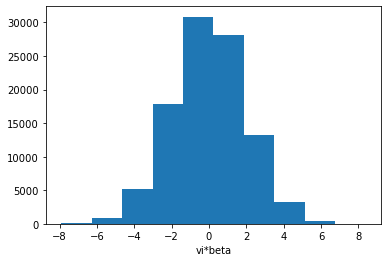

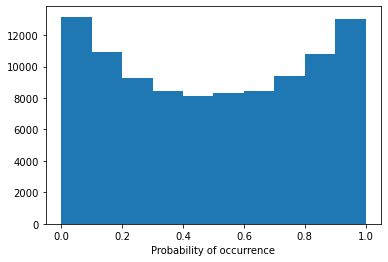

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<00:58,  2.02s/it]

Model 1/30, Test Accuracy: 0.6405

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:00,  2.16s/it]

Model 2/30, Test Accuracy: 0.6417

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:58,  2.17s/it]

Model 3/30, Test Accuracy: 0.6422

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:56,  2.18s/it]

Model 4/30, Test Accuracy: 0.6425

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:53,  2.16s/it]

Model 5/30, Test Accuracy: 0.6413

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:12<00:51,  2.17s/it]

Model 6/30, Test Accuracy: 0.6414

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:49,  2.15s/it]

Model 7/30, Test Accuracy: 0.6414

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:47,  2.17s/it]

Model 8/30, Test Accuracy: 0.6400

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:45,  2.18s/it]

Model 9/30, Test Accuracy: 0.6409

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:21<00:43,  2.16s/it]

Model 10/30, Test Accuracy: 0.6404

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:23<00:41,  2.19s/it]

Model 11/30, Test Accuracy: 0.6393

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:25<00:39,  2.17s/it]

Model 12/30, Test Accuracy: 0.6415

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:37,  2.19s/it]

Model 13/30, Test Accuracy: 0.6414

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:35,  2.20s/it]

Model 14/30, Test Accuracy: 0.6431

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:32<00:32,  2.20s/it]

Model 15/30, Test Accuracy: 0.6421

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:34<00:30,  2.18s/it]

Model 16/30, Test Accuracy: 0.6409

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:36<00:28,  2.19s/it]

Model 17/30, Test Accuracy: 0.6425

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:26,  2.19s/it]

Model 18/30, Test Accuracy: 0.6419

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:24,  2.22s/it]

Model 19/30, Test Accuracy: 0.6419

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:43<00:22,  2.24s/it]

Model 20/30, Test Accuracy: 0.6420

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:45<00:20,  2.23s/it]

Model 21/30, Test Accuracy: 0.6408

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:17,  2.24s/it]

Model 22/30, Test Accuracy: 0.6404

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:50<00:15,  2.22s/it]

Model 23/30, Test Accuracy: 0.6415

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:52<00:13,  2.23s/it]

Model 24/30, Test Accuracy: 0.6401

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:54<00:11,  2.26s/it]

Model 25/30, Test Accuracy: 0.6413

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:57<00:09,  2.26s/it]

Model 26/30, Test Accuracy: 0.6383

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:59<00:06,  2.22s/it]

Model 27/30, Test Accuracy: 0.6398

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:01<00:04,  2.20s/it]

Model 28/30, Test Accuracy: 0.6405

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:03<00:02,  2.21s/it]

Model 29/30, Test Accuracy: 0.6424

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.22s/it]

Model 30/30, Test Accuracy: 0.6404
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq7_var4_beta_var0.4.pkl


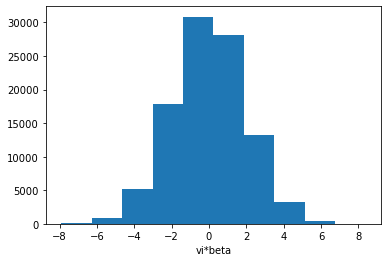

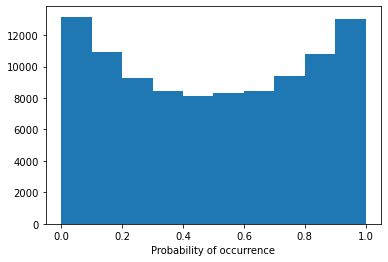

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<00:59,  2.05s/it]

Model 1/30, Test Accuracy: 0.6602

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:00,  2.17s/it]

Model 2/30, Test Accuracy: 0.6593

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:58,  2.17s/it]

Model 3/30, Test Accuracy: 0.6595

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:56,  2.18s/it]

Model 4/30, Test Accuracy: 0.6590

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:53,  2.15s/it]

Model 5/30, Test Accuracy: 0.6589

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:12<00:51,  2.16s/it]

Model 6/30, Test Accuracy: 0.6590

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:49,  2.15s/it]

Model 7/30, Test Accuracy: 0.6595

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:50,  2.31s/it]

Model 8/30, Test Accuracy: 0.6590

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:47,  2.28s/it]

Model 9/30, Test Accuracy: 0.6592

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:44,  2.24s/it]

Model 10/30, Test Accuracy: 0.6595

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:42,  2.24s/it]

Model 11/30, Test Accuracy: 0.6593

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:39,  2.21s/it]

Model 12/30, Test Accuracy: 0.6591

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:37,  2.21s/it]

Model 13/30, Test Accuracy: 0.6584

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:35,  2.20s/it]

Model 14/30, Test Accuracy: 0.6597

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:33,  2.20s/it]

Model 15/30, Test Accuracy: 0.6583

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:30,  2.19s/it]

Model 16/30, Test Accuracy: 0.6594

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:28,  2.19s/it]

Model 17/30, Test Accuracy: 0.6589

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:26,  2.17s/it]

Model 18/30, Test Accuracy: 0.6576

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:23,  2.18s/it]

Model 19/30, Test Accuracy: 0.6589

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:43<00:21,  2.19s/it]

Model 20/30, Test Accuracy: 0.6588

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:46<00:19,  2.17s/it]

Model 21/30, Test Accuracy: 0.6579

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:17,  2.19s/it]

Model 22/30, Test Accuracy: 0.6581

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:50<00:15,  2.18s/it]

Model 23/30, Test Accuracy: 0.6576

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:52<00:13,  2.19s/it]

Model 24/30, Test Accuracy: 0.6593

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:54<00:11,  2.22s/it]

Model 25/30, Test Accuracy: 0.6595

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:57<00:08,  2.24s/it]

Model 26/30, Test Accuracy: 0.6577

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:59<00:06,  2.23s/it]

Model 27/30, Test Accuracy: 0.6585

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:01<00:04,  2.20s/it]

Model 28/30, Test Accuracy: 0.6576

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:03<00:02,  2.20s/it]

Model 29/30, Test Accuracy: 0.6593

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.20s/it]

Model 30/30, Test Accuracy: 0.6591
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq10_var4_beta_var0.4.pkl


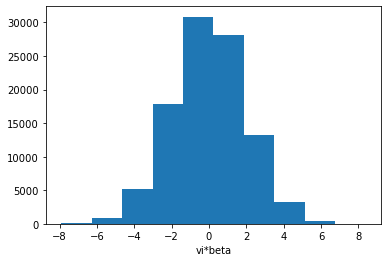

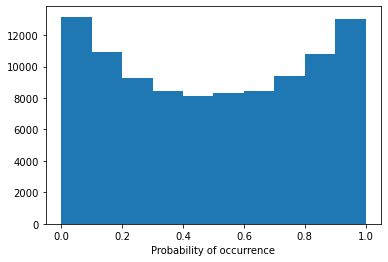

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:00,  2.08s/it]

Model 1/30, Test Accuracy: 0.6768

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:00,  2.16s/it]

Model 2/30, Test Accuracy: 0.6763

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:59,  2.20s/it]

Model 3/30, Test Accuracy: 0.6777

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:58,  2.24s/it]

Model 4/30, Test Accuracy: 0.6763

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:55,  2.24s/it]

Model 5/30, Test Accuracy: 0.6776

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:53,  2.25s/it]

Model 6/30, Test Accuracy: 0.6780

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:50,  2.21s/it]

Model 7/30, Test Accuracy: 0.6778

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:49,  2.24s/it]

Model 8/30, Test Accuracy: 0.6784

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:47,  2.27s/it]

Model 9/30, Test Accuracy: 0.6777

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:45,  2.26s/it]

Model 10/30, Test Accuracy: 0.6790

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:43,  2.27s/it]

Model 11/30, Test Accuracy: 0.6748

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:40,  2.26s/it]

Model 12/30, Test Accuracy: 0.6783

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:29<00:38,  2.27s/it]

Model 13/30, Test Accuracy: 0.6774

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:31<00:36,  2.29s/it]

Model 14/30, Test Accuracy: 0.6757

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:34,  2.28s/it]

Model 15/30, Test Accuracy: 0.6785

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:36<00:31,  2.27s/it]

Model 16/30, Test Accuracy: 0.6769

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:38<00:29,  2.29s/it]

Model 17/30, Test Accuracy: 0.6775

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:40<00:27,  2.27s/it]

Model 18/30, Test Accuracy: 0.6771

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:42<00:24,  2.27s/it]

Model 19/30, Test Accuracy: 0.6782

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:45<00:22,  2.27s/it]

Model 20/30, Test Accuracy: 0.6776

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:47<00:20,  2.23s/it]

Model 21/30, Test Accuracy: 0.6776

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:49<00:17,  2.23s/it]

Model 22/30, Test Accuracy: 0.6765

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:52<00:17,  2.51s/it]

Model 23/30, Test Accuracy: 0.6767

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:55<00:14,  2.46s/it]

Model 24/30, Test Accuracy: 0.6780

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:57<00:12,  2.40s/it]

Model 25/30, Test Accuracy: 0.6765

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:59<00:09,  2.36s/it]

Model 26/30, Test Accuracy: 0.6755

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [01:01<00:06,  2.31s/it]

Model 27/30, Test Accuracy: 0.6760

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:03<00:04,  2.28s/it]

Model 28/30, Test Accuracy: 0.6776

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:06<00:02,  2.28s/it]

Model 29/30, Test Accuracy: 0.6773

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:08<00:00,  2.29s/it]

Model 30/30, Test Accuracy: 0.6764
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq15_var4_beta_var0.4.pkl
Skipping training for epi_mean_ss100000_sq20_var4.pkl


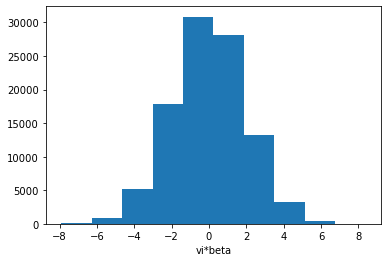

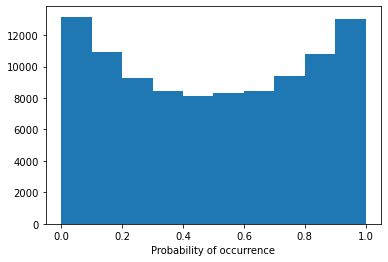

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 15.90it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4729

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4551

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4616

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:01, 17.62it/s]

Model 4/30, Test Accuracy: 0.5140

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5022

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.5524

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5054

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:00<00:01, 17.05it/s]

Model 8/30, Test Accuracy: 0.5125

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5051

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 10.55it/s]

Model 10/30, Test Accuracy: 0.5371

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4831

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:01<00:01, 10.03it/s]

Model 12/30, Test Accuracy: 0.5300

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5155

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:01<00:01,  9.27it/s]

Model 14/30, Test Accuracy: 0.4899

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5453

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:01,  9.71it/s]

Model 16/30, Test Accuracy: 0.4750

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4450

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4415

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 12.87it/s]

Model 19/30, Test Accuracy: 0.5387

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4674

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5541

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4543

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:02<00:00, 15.51it/s]

Model 23/30, Test Accuracy: 0.4883

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5410

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4906

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4734

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 13.08it/s]

Model 27/30, Test Accuracy: 0.4652

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4890

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4951

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4919
Predictions saved to epi_model_limitation/epi_mean_ss10_sq20_var7_beta_var0.4.pkl


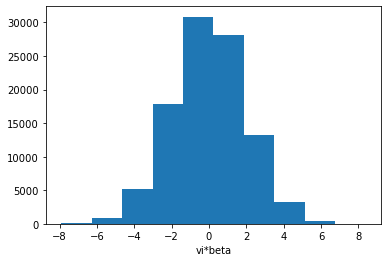

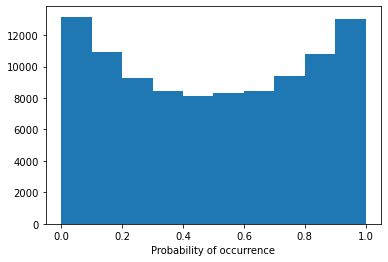

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 19.28it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4734

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4657

Training Model 3/30 with dropout seed 0.
Model 3/30, Test Accuracy: 0.4669

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:00<00:01, 15.27it/s]

Model 4/30, Test Accuracy: 0.5138

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5065

Training Model 6/30 with dropout seed 0.
Model 6/30, Test Accuracy: 0.5593

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.4984

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:00<00:01, 16.89it/s]

Model 8/30, Test Accuracy: 0.5151

Training Model 9/30 with dropout seed 0.
Model 9/30, Test Accuracy: 0.5143

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5345

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4900

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:00<00:00, 17.56it/s]

Model 12/30, Test Accuracy: 0.5331

Training Model 13/30 with dropout seed 0.
Model 13/30, Test Accuracy: 0.5212

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.4970

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5462

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 17.98it/s]

Model 16/30, Test Accuracy: 0.4780

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4447

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4428

Training Model 19/30 with dropout seed 0.
Model 19/30, Test Accuracy: 0.5426

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:01<00:00, 15.06it/s]

Model 20/30, Test Accuracy: 0.4739

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5565

Training Model 22/30 with dropout seed 0.
Model 22/30, Test Accuracy: 0.4578

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:01<00:00, 16.36it/s]

Model 23/30, Test Accuracy: 0.4889

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5459

Training Model 25/30 with dropout seed 0.
Model 25/30, Test Accuracy: 0.4898

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4779

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:01<00:00, 16.70it/s]

Model 27/30, Test Accuracy: 0.4678

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4929

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4954

Training Model 30/30 with dropout seed 0.
Model 30/30, Test Accuracy: 0.4915
Predictions saved to epi_model_limitation/epi_mean_ss100_sq20_var7_beta_var0.4.pkl


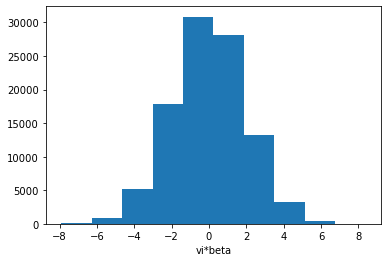

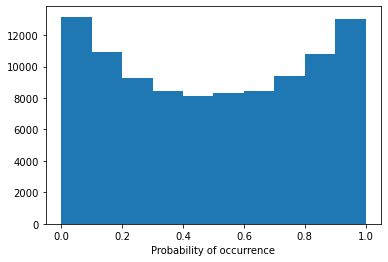

Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:01, 14.81it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.
Model 1/30, Test Accuracy: 0.4738

Training Model 2/30 with dropout seed 0.
Model 2/30, Test Accuracy: 0.4642

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:00<00:01, 14.71it/s]

Model 3/30, Test Accuracy: 0.4582

Training Model 4/30 with dropout seed 0.
Model 4/30, Test Accuracy: 0.5128

Training Model 5/30 with dropout seed 0.
Model 5/30, Test Accuracy: 0.5094

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:00<00:01, 14.27it/s]

Model 6/30, Test Accuracy: 0.5566

Training Model 7/30 with dropout seed 0.
Model 7/30, Test Accuracy: 0.5055

Training Model 8/30 with dropout seed 0.
Model 8/30, Test Accuracy: 0.5209

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:00<00:01, 14.67it/s]

Model 9/30, Test Accuracy: 0.5075

Training Model 10/30 with dropout seed 0.
Model 10/30, Test Accuracy: 0.5383

Training Model 11/30 with dropout seed 0.
Model 11/30, Test Accuracy: 0.4863

Training Model 12/30 with dropout seed 0.
Model 12/30, Test Accuracy: 0.5352

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:01<00:01, 12.24it/s]

Model 13/30, Test Accuracy: 0.5256

Training Model 14/30 with dropout seed 0.
Model 14/30, Test Accuracy: 0.5033

Training Model 15/30 with dropout seed 0.
Model 15/30, Test Accuracy: 0.5496

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:01<00:00, 12.95it/s]

Model 16/30, Test Accuracy: 0.4799

Training Model 17/30 with dropout seed 0.
Model 17/30, Test Accuracy: 0.4453

Training Model 18/30 with dropout seed 0.
Model 18/30, Test Accuracy: 0.4451

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:01<00:00, 13.13it/s]

Model 19/30, Test Accuracy: 0.5378

Training Model 20/30 with dropout seed 0.
Model 20/30, Test Accuracy: 0.4794

Training Model 21/30 with dropout seed 0.
Model 21/30, Test Accuracy: 0.5644

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:01<00:00, 13.38it/s]

Model 22/30, Test Accuracy: 0.4566

Training Model 23/30 with dropout seed 0.
Model 23/30, Test Accuracy: 0.4778

Training Model 24/30 with dropout seed 0.
Model 24/30, Test Accuracy: 0.5513

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:01<00:00, 11.89it/s]

Model 25/30, Test Accuracy: 0.4859

Training Model 26/30 with dropout seed 0.
Model 26/30, Test Accuracy: 0.4892

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:02<00:00, 12.42it/s]

Model 27/30, Test Accuracy: 0.4677

Training Model 28/30 with dropout seed 0.
Model 28/30, Test Accuracy: 0.4913

Training Model 29/30 with dropout seed 0.
Model 29/30, Test Accuracy: 0.4985

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:02<00:00, 13.21it/s]


Model 30/30, Test Accuracy: 0.4981
Predictions saved to epi_model_limitation/epi_mean_ss1000_sq20_var7_beta_var0.4.pkl


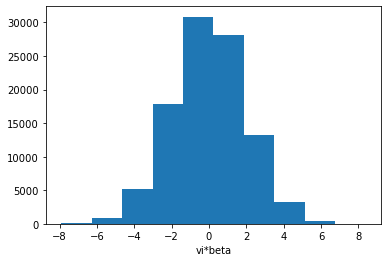

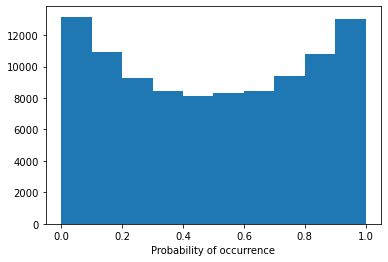

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:07,  3.72it/s]

Model 1/30, Test Accuracy: 0.5010

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:00<00:08,  3.16it/s]

Model 2/30, Test Accuracy: 0.4907

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:00<00:08,  3.34it/s]

Model 3/30, Test Accuracy: 0.5045

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:01<00:07,  3.47it/s]

Model 4/30, Test Accuracy: 0.5448

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:01<00:07,  3.53it/s]

Model 5/30, Test Accuracy: 0.5220

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:01<00:06,  3.57it/s]

Model 6/30, Test Accuracy: 0.5880

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:01<00:06,  3.62it/s]

Model 7/30, Test Accuracy: 0.5308

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:02<00:06,  3.31it/s]

Model 8/30, Test Accuracy: 0.5444

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:02<00:06,  3.36it/s]

Model 9/30, Test Accuracy: 0.5215

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:02<00:05,  3.41it/s]

Model 10/30, Test Accuracy: 0.5596

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:03<00:05,  3.22it/s]

Model 11/30, Test Accuracy: 0.5083

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:03<00:05,  3.28it/s]

Model 12/30, Test Accuracy: 0.5511

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:03<00:04,  3.41it/s]

Model 13/30, Test Accuracy: 0.5698

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:04<00:04,  3.48it/s]

Model 14/30, Test Accuracy: 0.5204

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:04<00:04,  3.48it/s]

Model 15/30, Test Accuracy: 0.5524

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:04<00:04,  3.26it/s]

Model 16/30, Test Accuracy: 0.5149

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:05<00:03,  3.36it/s]

Model 17/30, Test Accuracy: 0.4840

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:05<00:03,  3.33it/s]

Model 18/30, Test Accuracy: 0.4703

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:05<00:03,  3.11it/s]

Model 19/30, Test Accuracy: 0.5594

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:05<00:03,  3.23it/s]

Model 20/30, Test Accuracy: 0.4804

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:06<00:02,  3.30it/s]

Model 21/30, Test Accuracy: 0.5866

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:06<00:02,  3.36it/s]

Model 22/30, Test Accuracy: 0.4839

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:06<00:02,  3.43it/s]

Model 23/30, Test Accuracy: 0.4905

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:07<00:01,  3.46it/s]

Model 24/30, Test Accuracy: 0.5818

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:07<00:01,  3.20it/s]

Model 25/30, Test Accuracy: 0.5078

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:07<00:01,  3.33it/s]

Model 26/30, Test Accuracy: 0.5170

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:08<00:00,  3.20it/s]

Model 27/30, Test Accuracy: 0.4855

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:08<00:00,  3.29it/s]

Model 28/30, Test Accuracy: 0.5208

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:08<00:00,  3.35it/s]

Model 29/30, Test Accuracy: 0.5332

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:08<00:00,  3.35it/s]

Model 30/30, Test Accuracy: 0.5240
Predictions saved to epi_model_limitation/epi_mean_ss10000_sq20_var7_beta_var0.4.pkl


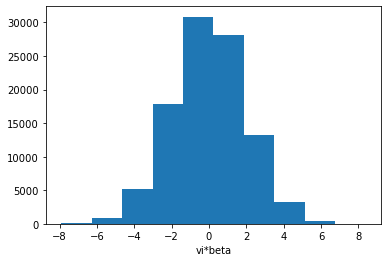

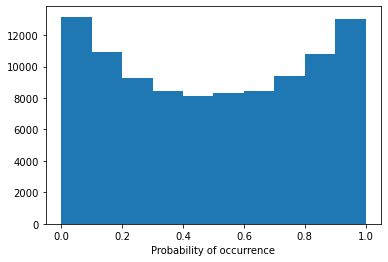

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

Model 1/30, Test Accuracy: 0.5757

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:01<00:22,  1.24it/s]

Model 2/30, Test Accuracy: 0.6126

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:02<00:22,  1.20it/s]

Model 3/30, Test Accuracy: 0.6069

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:03<00:21,  1.20it/s]

Model 4/30, Test Accuracy: 0.6075

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:04<00:20,  1.24it/s]

Model 5/30, Test Accuracy: 0.5867

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:04<00:19,  1.23it/s]

Model 6/30, Test Accuracy: 0.6198

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:05<00:18,  1.22it/s]

Model 7/30, Test Accuracy: 0.6173

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

Model 8/30, Test Accuracy: 0.6142

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:07<00:17,  1.23it/s]

Model 9/30, Test Accuracy: 0.5998

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:08<00:16,  1.22it/s]

Model 10/30, Test Accuracy: 0.6145

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:08<00:15,  1.25it/s]

Model 11/30, Test Accuracy: 0.5664

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:09<00:14,  1.24it/s]

Model 12/30, Test Accuracy: 0.6087

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:10<00:13,  1.22it/s]

Model 13/30, Test Accuracy: 0.6318

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:11<00:12,  1.26it/s]

Model 14/30, Test Accuracy: 0.5774

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:12<00:11,  1.28it/s]

Model 15/30, Test Accuracy: 0.6060

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:12<00:11,  1.26it/s]

Model 16/30, Test Accuracy: 0.5941

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:13<00:10,  1.24it/s]

Model 17/30, Test Accuracy: 0.5924

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:14<00:09,  1.28it/s]

Model 18/30, Test Accuracy: 0.5775

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:15<00:08,  1.26it/s]

Model 19/30, Test Accuracy: 0.6169

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:16<00:08,  1.24it/s]

Model 20/30, Test Accuracy: 0.5510

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:16<00:07,  1.28it/s]

Model 21/30, Test Accuracy: 0.6275

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:17<00:06,  1.25it/s]

Model 22/30, Test Accuracy: 0.5835

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:18<00:05,  1.24it/s]

Model 23/30, Test Accuracy: 0.5676

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:19<00:04,  1.26it/s]

Model 24/30, Test Accuracy: 0.6288

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:20<00:03,  1.25it/s]

Model 25/30, Test Accuracy: 0.5708

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:20<00:03,  1.24it/s]

Model 26/30, Test Accuracy: 0.5748

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:21<00:02,  1.27it/s]

Model 27/30, Test Accuracy: 0.5292

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:22<00:01,  1.25it/s]

Model 28/30, Test Accuracy: 0.5945

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:23<00:00,  1.24it/s]

Model 29/30, Test Accuracy: 0.5999

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s]

Model 30/30, Test Accuracy: 0.6049
Predictions saved to epi_model_limitation/epi_mean_ss30000_sq20_var7_beta_var0.4.pkl


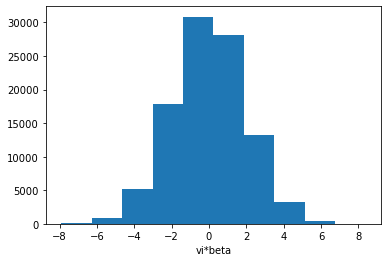

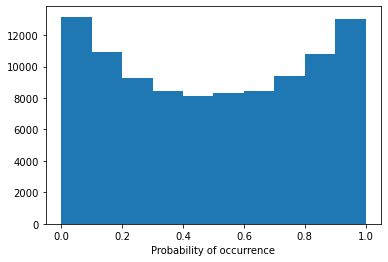

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:36,  1.27s/it]

Model 1/30, Test Accuracy: 0.6221

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:02<00:35,  1.27s/it]

Model 2/30, Test Accuracy: 0.6298

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:03<00:34,  1.28s/it]

Model 3/30, Test Accuracy: 0.6293

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:05<00:32,  1.27s/it]

Model 4/30, Test Accuracy: 0.6306

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:06<00:31,  1.26s/it]

Model 5/30, Test Accuracy: 0.6297

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:07<00:31,  1.29s/it]

Model 6/30, Test Accuracy: 0.6296

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:08<00:29,  1.27s/it]

Model 7/30, Test Accuracy: 0.6305

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:10<00:28,  1.30s/it]

Model 8/30, Test Accuracy: 0.6296

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:11<00:26,  1.26s/it]

Model 9/30, Test Accuracy: 0.6309

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:12<00:25,  1.28s/it]

Model 10/30, Test Accuracy: 0.6296

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:13<00:23,  1.26s/it]

Model 11/30, Test Accuracy: 0.6220

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:15<00:23,  1.29s/it]

Model 12/30, Test Accuracy: 0.6313

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:16<00:21,  1.25s/it]

Model 13/30, Test Accuracy: 0.6321

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:17<00:20,  1.29s/it]

Model 14/30, Test Accuracy: 0.6230

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:19<00:19,  1.28s/it]

Model 15/30, Test Accuracy: 0.6271

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:20<00:17,  1.28s/it]

Model 16/30, Test Accuracy: 0.6272

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:21<00:16,  1.28s/it]

Model 17/30, Test Accuracy: 0.6301

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:23<00:15,  1.29s/it]

Model 18/30, Test Accuracy: 0.6273

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:24<00:14,  1.29s/it]

Model 19/30, Test Accuracy: 0.6298

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:25<00:12,  1.29s/it]

Model 20/30, Test Accuracy: 0.6231

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:26<00:11,  1.30s/it]

Model 21/30, Test Accuracy: 0.6310

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:28<00:10,  1.30s/it]

Model 22/30, Test Accuracy: 0.6271

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:29<00:09,  1.30s/it]

Model 23/30, Test Accuracy: 0.6284

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:30<00:07,  1.30s/it]

Model 24/30, Test Accuracy: 0.6321

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:32<00:06,  1.30s/it]

Model 25/30, Test Accuracy: 0.6243

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:33<00:05,  1.30s/it]

Model 26/30, Test Accuracy: 0.6218

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:34<00:03,  1.30s/it]

Model 27/30, Test Accuracy: 0.6200

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:36<00:02,  1.31s/it]

Model 28/30, Test Accuracy: 0.6229

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:37<00:01,  1.31s/it]

Model 29/30, Test Accuracy: 0.6307

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:38<00:00,  1.29s/it]

Model 30/30, Test Accuracy: 0.6304
Predictions saved to epi_model_limitation/epi_mean_ss50000_sq20_var7_beta_var0.4.pkl


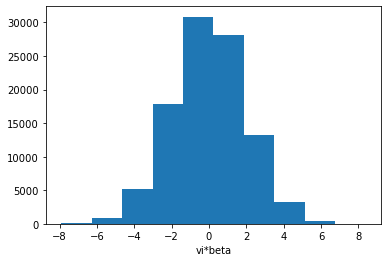

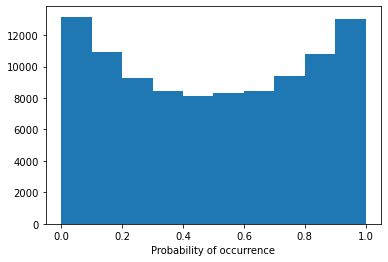

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:50,  1.76s/it]

Model 1/30, Test Accuracy: 0.6355

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:03<00:50,  1.80s/it]

Model 2/30, Test Accuracy: 0.6332

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:05<00:49,  1.82s/it]

Model 3/30, Test Accuracy: 0.6365

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:07<00:46,  1.78s/it]

Model 4/30, Test Accuracy: 0.6357

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:08<00:44,  1.80s/it]

Model 5/30, Test Accuracy: 0.6342

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:10<00:43,  1.80s/it]

Model 6/30, Test Accuracy: 0.6348

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:12<00:41,  1.80s/it]

Model 7/30, Test Accuracy: 0.6360

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:14<00:39,  1.80s/it]

Model 8/30, Test Accuracy: 0.6348

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:16<00:38,  1.83s/it]

Model 9/30, Test Accuracy: 0.6347

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:18<00:36,  1.85s/it]

Model 10/30, Test Accuracy: 0.6327

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:20<00:35,  1.85s/it]

Model 11/30, Test Accuracy: 0.6360

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:23<00:39,  2.21s/it]

Model 12/30, Test Accuracy: 0.6355

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:24<00:36,  2.12s/it]

Model 13/30, Test Accuracy: 0.6352

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:26<00:32,  2.02s/it]

Model 14/30, Test Accuracy: 0.6360

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:28<00:29,  1.96s/it]

Model 15/30, Test Accuracy: 0.6342

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:30<00:26,  1.93s/it]

Model 16/30, Test Accuracy: 0.6345

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:32<00:24,  1.90s/it]

Model 17/30, Test Accuracy: 0.6352

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:34<00:22,  1.87s/it]

Model 18/30, Test Accuracy: 0.6340

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:35<00:20,  1.84s/it]

Model 19/30, Test Accuracy: 0.6360

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:37<00:18,  1.85s/it]

Model 20/30, Test Accuracy: 0.6323

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:39<00:16,  1.83s/it]

Model 21/30, Test Accuracy: 0.6351

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:41<00:14,  1.80s/it]

Model 22/30, Test Accuracy: 0.6327

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:43<00:12,  1.82s/it]

Model 23/30, Test Accuracy: 0.6343

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:44<00:10,  1.82s/it]

Model 24/30, Test Accuracy: 0.6350

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:46<00:08,  1.79s/it]

Model 25/30, Test Accuracy: 0.6358

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:48<00:07,  1.78s/it]

Model 26/30, Test Accuracy: 0.6345

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:50<00:05,  1.81s/it]

Model 27/30, Test Accuracy: 0.6362

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:52<00:03,  1.80s/it]

Model 28/30, Test Accuracy: 0.6386

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [00:53<00:01,  1.82s/it]

Model 29/30, Test Accuracy: 0.6354

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [00:55<00:00,  1.86s/it]

Model 30/30, Test Accuracy: 0.6339
Predictions saved to epi_model_limitation/epi_mean_ss70000_sq20_var7_beta_var0.4.pkl


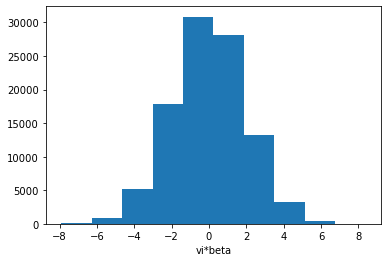

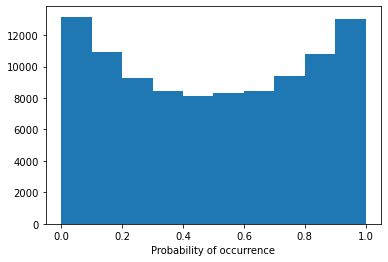

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:00,  2.09s/it]

Model 1/30, Test Accuracy: 0.6338

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:58,  2.09s/it]

Model 2/30, Test Accuracy: 0.6355

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:57,  2.12s/it]

Model 3/30, Test Accuracy: 0.6349

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:55,  2.13s/it]

Model 4/30, Test Accuracy: 0.6344

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:52,  2.10s/it]

Model 5/30, Test Accuracy: 0.6352

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:12<00:50,  2.11s/it]

Model 6/30, Test Accuracy: 0.6346

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:14<00:47,  2.07s/it]

Model 7/30, Test Accuracy: 0.6351

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:16<00:45,  2.08s/it]

Model 8/30, Test Accuracy: 0.6350

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:18<00:43,  2.07s/it]

Model 9/30, Test Accuracy: 0.6352

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:20<00:41,  2.06s/it]

Model 10/30, Test Accuracy: 0.6339

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:22<00:38,  2.03s/it]

Model 11/30, Test Accuracy: 0.6352

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:24<00:36,  2.05s/it]

Model 12/30, Test Accuracy: 0.6351

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:26<00:34,  2.05s/it]

Model 13/30, Test Accuracy: 0.6343

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:29<00:33,  2.07s/it]

Model 14/30, Test Accuracy: 0.6327

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:31<00:31,  2.10s/it]

Model 15/30, Test Accuracy: 0.6339

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:33<00:28,  2.07s/it]

Model 16/30, Test Accuracy: 0.6350

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:35<00:27,  2.08s/it]

Model 17/30, Test Accuracy: 0.6342

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:37<00:24,  2.07s/it]

Model 18/30, Test Accuracy: 0.6359

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:39<00:22,  2.08s/it]

Model 19/30, Test Accuracy: 0.6352

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:41<00:20,  2.09s/it]

Model 20/30, Test Accuracy: 0.6341

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:43<00:18,  2.09s/it]

Model 21/30, Test Accuracy: 0.6350

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:45<00:16,  2.07s/it]

Model 22/30, Test Accuracy: 0.6347

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:47<00:14,  2.06s/it]

Model 23/30, Test Accuracy: 0.6356

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:49<00:12,  2.07s/it]

Model 24/30, Test Accuracy: 0.6353

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:51<00:10,  2.08s/it]

Model 25/30, Test Accuracy: 0.6331

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:54<00:08,  2.08s/it]

Model 26/30, Test Accuracy: 0.6348

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:56<00:06,  2.08s/it]

Model 27/30, Test Accuracy: 0.6346

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:58<00:04,  2.07s/it]

Model 28/30, Test Accuracy: 0.6333

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:00<00:02,  2.06s/it]

Model 29/30, Test Accuracy: 0.6349

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:02<00:00,  2.08s/it]

Model 30/30, Test Accuracy: 0.6352
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq20_var7_beta_var0.4.pkl


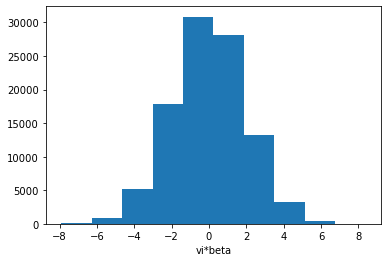

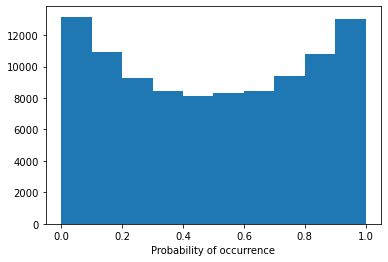

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:00,  2.08s/it]

Model 1/30, Test Accuracy: 0.5326

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:56,  2.03s/it]

Model 2/30, Test Accuracy: 0.5314

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:55,  2.05s/it]

Model 3/30, Test Accuracy: 0.5305

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:53,  2.07s/it]

Model 4/30, Test Accuracy: 0.5289

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:51,  2.08s/it]

Model 5/30, Test Accuracy: 0.5338

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:12<00:50,  2.10s/it]

Model 6/30, Test Accuracy: 0.5243

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:14<00:47,  2.07s/it]

Model 7/30, Test Accuracy: 0.5310

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:16<00:45,  2.08s/it]

Model 8/30, Test Accuracy: 0.5300

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:18<00:43,  2.09s/it]

Model 9/30, Test Accuracy: 0.5329

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:20<00:41,  2.08s/it]

Model 10/30, Test Accuracy: 0.5283

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:23<00:42,  2.25s/it]

Model 11/30, Test Accuracy: 0.5282

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:25<00:41,  2.30s/it]

Model 12/30, Test Accuracy: 0.5281

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:27<00:38,  2.24s/it]

Model 13/30, Test Accuracy: 0.5328

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:35,  2.21s/it]

Model 14/30, Test Accuracy: 0.5284

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:32<00:32,  2.18s/it]

Model 15/30, Test Accuracy: 0.5262

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:34<00:30,  2.16s/it]

Model 16/30, Test Accuracy: 0.5298

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:36<00:28,  2.16s/it]

Model 17/30, Test Accuracy: 0.5284

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:38<00:25,  2.14s/it]

Model 18/30, Test Accuracy: 0.5252

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:40<00:23,  2.12s/it]

Model 19/30, Test Accuracy: 0.5331

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:42<00:21,  2.12s/it]

Model 20/30, Test Accuracy: 0.5316

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:44<00:18,  2.10s/it]

Model 21/30, Test Accuracy: 0.5322

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:46<00:16,  2.11s/it]

Model 22/30, Test Accuracy: 0.5300

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:48<00:14,  2.09s/it]

Model 23/30, Test Accuracy: 0.5316

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:51<00:12,  2.09s/it]

Model 24/30, Test Accuracy: 0.5306

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:53<00:10,  2.11s/it]

Model 25/30, Test Accuracy: 0.5317

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:55<00:08,  2.12s/it]

Model 26/30, Test Accuracy: 0.5287

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:57<00:06,  2.12s/it]

Model 27/30, Test Accuracy: 0.5328

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:59<00:04,  2.11s/it]

Model 28/30, Test Accuracy: 0.5292

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:01<00:02,  2.09s/it]

Model 29/30, Test Accuracy: 0.5323

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:03<00:00,  2.12s/it]

Model 30/30, Test Accuracy: 0.5284
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq1_var7_beta_var0.4.pkl


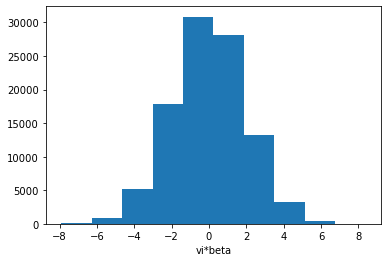

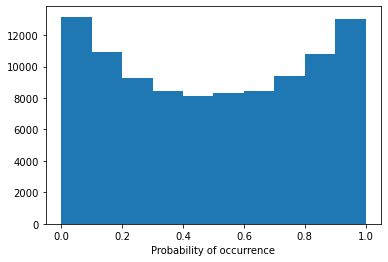

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<01:00,  2.09s/it]

Model 1/30, Test Accuracy: 0.5588

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:57,  2.06s/it]

Model 2/30, Test Accuracy: 0.5574

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:57,  2.12s/it]

Model 3/30, Test Accuracy: 0.5614

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:54,  2.11s/it]

Model 4/30, Test Accuracy: 0.5569

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:51,  2.07s/it]

Model 5/30, Test Accuracy: 0.5588

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:12<00:49,  2.06s/it]

Model 6/30, Test Accuracy: 0.5574

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:14<00:46,  2.03s/it]

Model 7/30, Test Accuracy: 0.5586

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:16<00:44,  2.04s/it]

Model 8/30, Test Accuracy: 0.5587

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:18<00:43,  2.05s/it]

Model 9/30, Test Accuracy: 0.5578

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:20<00:40,  2.03s/it]

Model 10/30, Test Accuracy: 0.5584

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:22<00:38,  2.05s/it]

Model 11/30, Test Accuracy: 0.5566

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:24<00:36,  2.02s/it]

Model 12/30, Test Accuracy: 0.5556

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:26<00:35,  2.07s/it]

Model 13/30, Test Accuracy: 0.5588

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:28<00:33,  2.07s/it]

Model 14/30, Test Accuracy: 0.5609

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:30<00:31,  2.09s/it]

Model 15/30, Test Accuracy: 0.5585

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:33<00:29,  2.08s/it]

Model 16/30, Test Accuracy: 0.5587

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:35<00:27,  2.11s/it]

Model 17/30, Test Accuracy: 0.5580

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:37<00:25,  2.09s/it]

Model 18/30, Test Accuracy: 0.5594

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:39<00:23,  2.10s/it]

Model 19/30, Test Accuracy: 0.5565

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:41<00:21,  2.11s/it]

Model 20/30, Test Accuracy: 0.5581

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:43<00:18,  2.09s/it]

Model 21/30, Test Accuracy: 0.5576

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:45<00:16,  2.09s/it]

Model 22/30, Test Accuracy: 0.5575

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:47<00:14,  2.08s/it]

Model 23/30, Test Accuracy: 0.5591

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:49<00:12,  2.09s/it]

Model 24/30, Test Accuracy: 0.5573

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:51<00:10,  2.11s/it]

Model 25/30, Test Accuracy: 0.5585

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:54<00:08,  2.10s/it]

Model 26/30, Test Accuracy: 0.5581

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:56<00:06,  2.08s/it]

Model 27/30, Test Accuracy: 0.5585

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:58<00:04,  2.08s/it]

Model 28/30, Test Accuracy: 0.5593

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:00<00:02,  2.05s/it]

Model 29/30, Test Accuracy: 0.5569

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:02<00:00,  2.07s/it]

Model 30/30, Test Accuracy: 0.5595
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq3_var7_beta_var0.4.pkl


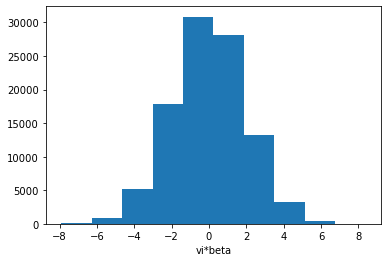

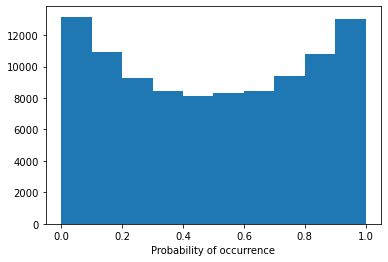

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:57,  1.99s/it]

Model 1/30, Test Accuracy: 0.5790

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:57,  2.06s/it]

Model 2/30, Test Accuracy: 0.5790

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:55,  2.07s/it]

Model 3/30, Test Accuracy: 0.5794

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:53,  2.07s/it]

Model 4/30, Test Accuracy: 0.5794

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:51,  2.05s/it]

Model 5/30, Test Accuracy: 0.5791

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:12<00:49,  2.07s/it]

Model 6/30, Test Accuracy: 0.5795

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:14<00:46,  2.04s/it]

Model 7/30, Test Accuracy: 0.5793

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:16<00:47,  2.15s/it]

Model 8/30, Test Accuracy: 0.5786

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:48,  2.31s/it]

Model 9/30, Test Accuracy: 0.5783

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:21<00:44,  2.22s/it]

Model 10/30, Test Accuracy: 0.5803

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:23<00:41,  2.19s/it]

Model 11/30, Test Accuracy: 0.5785

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:25<00:38,  2.15s/it]

Model 12/30, Test Accuracy: 0.5805

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:27<00:36,  2.14s/it]

Model 13/30, Test Accuracy: 0.5803

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:29<00:34,  2.14s/it]

Model 14/30, Test Accuracy: 0.5779

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:31<00:31,  2.12s/it]

Model 15/30, Test Accuracy: 0.5789

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:33<00:29,  2.09s/it]

Model 16/30, Test Accuracy: 0.5768

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:36<00:27,  2.09s/it]

Model 17/30, Test Accuracy: 0.5821

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:38<00:24,  2.06s/it]

Model 18/30, Test Accuracy: 0.5788

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:40<00:22,  2.07s/it]

Model 19/30, Test Accuracy: 0.5789

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:42<00:20,  2.09s/it]

Model 20/30, Test Accuracy: 0.5789

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:44<00:18,  2.08s/it]

Model 21/30, Test Accuracy: 0.5806

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:46<00:16,  2.09s/it]

Model 22/30, Test Accuracy: 0.5815

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:48<00:14,  2.08s/it]

Model 23/30, Test Accuracy: 0.5816

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:50<00:12,  2.08s/it]

Model 24/30, Test Accuracy: 0.5805

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:52<00:10,  2.09s/it]

Model 25/30, Test Accuracy: 0.5790

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:54<00:08,  2.09s/it]

Model 26/30, Test Accuracy: 0.5771

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:56<00:06,  2.06s/it]

Model 27/30, Test Accuracy: 0.5793

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:58<00:04,  2.05s/it]

Model 28/30, Test Accuracy: 0.5794

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:00<00:02,  2.07s/it]

Model 29/30, Test Accuracy: 0.5795

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:03<00:00,  2.10s/it]

Model 30/30, Test Accuracy: 0.5786
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq5_var7_beta_var0.4.pkl


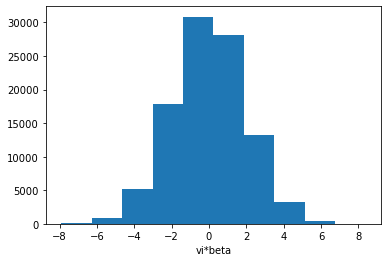

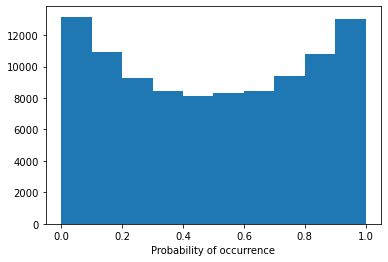

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:01<00:57,  1.99s/it]

Model 1/30, Test Accuracy: 0.5897

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:58,  2.09s/it]

Model 2/30, Test Accuracy: 0.5903

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:56,  2.10s/it]

Model 3/30, Test Accuracy: 0.5890

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:54,  2.11s/it]

Model 4/30, Test Accuracy: 0.5902

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:10<00:52,  2.10s/it]

Model 5/30, Test Accuracy: 0.5907

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:12<00:50,  2.11s/it]

Model 6/30, Test Accuracy: 0.5900

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:14<00:48,  2.11s/it]

Model 7/30, Test Accuracy: 0.5897

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:16<00:46,  2.12s/it]

Model 8/30, Test Accuracy: 0.5897

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:44,  2.14s/it]

Model 9/30, Test Accuracy: 0.5903

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:21<00:42,  2.10s/it]

Model 10/30, Test Accuracy: 0.5908

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:23<00:40,  2.13s/it]

Model 11/30, Test Accuracy: 0.5903

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:25<00:37,  2.10s/it]

Model 12/30, Test Accuracy: 0.5891

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:27<00:36,  2.12s/it]

Model 13/30, Test Accuracy: 0.5911

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:29<00:33,  2.12s/it]

Model 14/30, Test Accuracy: 0.5899

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:31<00:32,  2.14s/it]

Model 15/30, Test Accuracy: 0.5896

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:33<00:29,  2.13s/it]

Model 16/30, Test Accuracy: 0.5889

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:36<00:27,  2.15s/it]

Model 17/30, Test Accuracy: 0.5916

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:38<00:25,  2.12s/it]

Model 18/30, Test Accuracy: 0.5907

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:40<00:23,  2.14s/it]

Model 19/30, Test Accuracy: 0.5909

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:42<00:21,  2.15s/it]

Model 20/30, Test Accuracy: 0.5895

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:44<00:19,  2.14s/it]

Model 21/30, Test Accuracy: 0.5901

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:46<00:17,  2.14s/it]

Model 22/30, Test Accuracy: 0.5905

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:48<00:14,  2.14s/it]

Model 23/30, Test Accuracy: 0.5900

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:51<00:12,  2.15s/it]

Model 24/30, Test Accuracy: 0.5895

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:53<00:10,  2.16s/it]

Model 25/30, Test Accuracy: 0.5896

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:55<00:08,  2.15s/it]

Model 26/30, Test Accuracy: 0.5890

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:57<00:06,  2.14s/it]

Model 27/30, Test Accuracy: 0.5900

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [00:59<00:04,  2.11s/it]

Model 28/30, Test Accuracy: 0.5895

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:01<00:02,  2.11s/it]

Model 29/30, Test Accuracy: 0.5898

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:03<00:00,  2.13s/it]

Model 30/30, Test Accuracy: 0.5907
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq7_var7_beta_var0.4.pkl


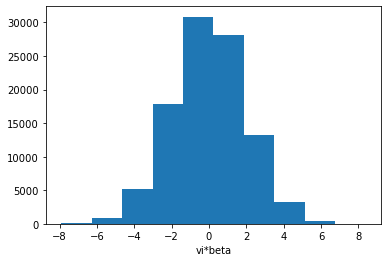

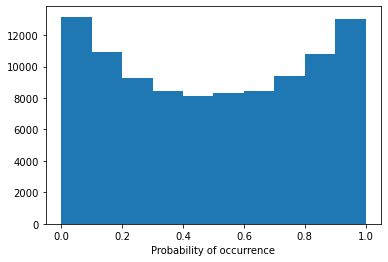

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<00:58,  2.02s/it]

Model 1/30, Test Accuracy: 0.6055

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<00:58,  2.10s/it]

Model 2/30, Test Accuracy: 0.6069

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<00:57,  2.12s/it]

Model 3/30, Test Accuracy: 0.6063

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:55,  2.15s/it]

Model 4/30, Test Accuracy: 0.6056

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<01:02,  2.49s/it]

Model 5/30, Test Accuracy: 0.6056

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:56,  2.37s/it]

Model 6/30, Test Accuracy: 0.6043

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:51,  2.26s/it]

Model 7/30, Test Accuracy: 0.6049

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:48,  2.22s/it]

Model 8/30, Test Accuracy: 0.6052

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:20<00:45,  2.19s/it]

Model 9/30, Test Accuracy: 0.6063

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:43,  2.15s/it]

Model 10/30, Test Accuracy: 0.6065

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:40,  2.14s/it]

Model 11/30, Test Accuracy: 0.6054

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:37,  2.11s/it]

Model 12/30, Test Accuracy: 0.6056

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:36,  2.12s/it]

Model 13/30, Test Accuracy: 0.6070

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:33,  2.12s/it]

Model 14/30, Test Accuracy: 0.6065

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:32<00:32,  2.14s/it]

Model 15/30, Test Accuracy: 0.6051

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:34<00:29,  2.12s/it]

Model 16/30, Test Accuracy: 0.6069

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:36<00:27,  2.14s/it]

Model 17/30, Test Accuracy: 0.6065

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:25,  2.12s/it]

Model 18/30, Test Accuracy: 0.6040

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:23,  2.14s/it]

Model 19/30, Test Accuracy: 0.6067

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:43<00:21,  2.15s/it]

Model 20/30, Test Accuracy: 0.6071

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:45<00:19,  2.13s/it]

Model 21/30, Test Accuracy: 0.6049

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:47<00:17,  2.13s/it]

Model 22/30, Test Accuracy: 0.6055

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:49<00:14,  2.10s/it]

Model 23/30, Test Accuracy: 0.6054

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:51<00:12,  2.14s/it]

Model 24/30, Test Accuracy: 0.6044

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:54<00:10,  2.16s/it]

Model 25/30, Test Accuracy: 0.6067

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:56<00:08,  2.17s/it]

Model 26/30, Test Accuracy: 0.6043

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:58<00:06,  2.16s/it]

Model 27/30, Test Accuracy: 0.6056

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:00<00:04,  2.13s/it]

Model 28/30, Test Accuracy: 0.6036

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:02<00:02,  2.14s/it]

Model 29/30, Test Accuracy: 0.6056

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:04<00:00,  2.16s/it]

Model 30/30, Test Accuracy: 0.6066
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq10_var7_beta_var0.4.pkl


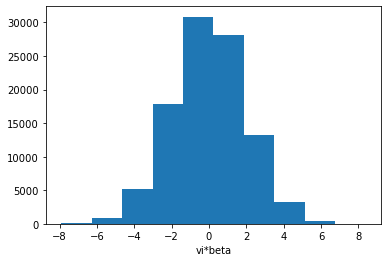

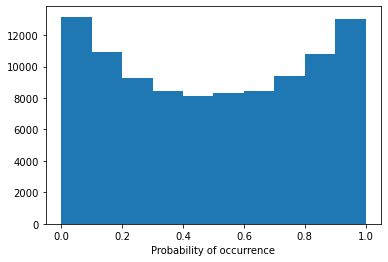

Ensemble Seed 0:   0%|          | 0/30 [00:00<?, ?it/s]


Training Deep Ensemble model with dropout seed 0.

Training Model 1/30 with dropout seed 0.


Ensemble Seed 0:   3%|▎         | 1/30 [00:02<00:59,  2.05s/it]

Model 1/30, Test Accuracy: 0.6201

Training Model 2/30 with dropout seed 0.


Ensemble Seed 0:   7%|▋         | 2/30 [00:04<01:01,  2.18s/it]

Model 2/30, Test Accuracy: 0.6207

Training Model 3/30 with dropout seed 0.


Ensemble Seed 0:  10%|█         | 3/30 [00:06<01:00,  2.25s/it]

Model 3/30, Test Accuracy: 0.6203

Training Model 4/30 with dropout seed 0.


Ensemble Seed 0:  13%|█▎        | 4/30 [00:08<00:58,  2.26s/it]

Model 4/30, Test Accuracy: 0.6212

Training Model 5/30 with dropout seed 0.


Ensemble Seed 0:  17%|█▋        | 5/30 [00:11<00:55,  2.24s/it]

Model 5/30, Test Accuracy: 0.6209

Training Model 6/30 with dropout seed 0.


Ensemble Seed 0:  20%|██        | 6/30 [00:13<00:53,  2.22s/it]

Model 6/30, Test Accuracy: 0.6194

Training Model 7/30 with dropout seed 0.


Ensemble Seed 0:  23%|██▎       | 7/30 [00:15<00:50,  2.19s/it]

Model 7/30, Test Accuracy: 0.6208

Training Model 8/30 with dropout seed 0.


Ensemble Seed 0:  27%|██▋       | 8/30 [00:17<00:48,  2.20s/it]

Model 8/30, Test Accuracy: 0.6202

Training Model 9/30 with dropout seed 0.


Ensemble Seed 0:  30%|███       | 9/30 [00:19<00:46,  2.21s/it]

Model 9/30, Test Accuracy: 0.6202

Training Model 10/30 with dropout seed 0.


Ensemble Seed 0:  33%|███▎      | 10/30 [00:22<00:43,  2.18s/it]

Model 10/30, Test Accuracy: 0.6210

Training Model 11/30 with dropout seed 0.


Ensemble Seed 0:  37%|███▋      | 11/30 [00:24<00:41,  2.19s/it]

Model 11/30, Test Accuracy: 0.6197

Training Model 12/30 with dropout seed 0.


Ensemble Seed 0:  40%|████      | 12/30 [00:26<00:39,  2.18s/it]

Model 12/30, Test Accuracy: 0.6213

Training Model 13/30 with dropout seed 0.


Ensemble Seed 0:  43%|████▎     | 13/30 [00:28<00:37,  2.19s/it]

Model 13/30, Test Accuracy: 0.6201

Training Model 14/30 with dropout seed 0.


Ensemble Seed 0:  47%|████▋     | 14/30 [00:30<00:35,  2.21s/it]

Model 14/30, Test Accuracy: 0.6211

Training Model 15/30 with dropout seed 0.


Ensemble Seed 0:  50%|█████     | 15/30 [00:33<00:33,  2.21s/it]

Model 15/30, Test Accuracy: 0.6222

Training Model 16/30 with dropout seed 0.


Ensemble Seed 0:  53%|█████▎    | 16/30 [00:35<00:30,  2.19s/it]

Model 16/30, Test Accuracy: 0.6203

Training Model 17/30 with dropout seed 0.


Ensemble Seed 0:  57%|█████▋    | 17/30 [00:37<00:28,  2.21s/it]

Model 17/30, Test Accuracy: 0.6211

Training Model 18/30 with dropout seed 0.


Ensemble Seed 0:  60%|██████    | 18/30 [00:39<00:26,  2.18s/it]

Model 18/30, Test Accuracy: 0.6204

Training Model 19/30 with dropout seed 0.


Ensemble Seed 0:  63%|██████▎   | 19/30 [00:41<00:24,  2.19s/it]

Model 19/30, Test Accuracy: 0.6214

Training Model 20/30 with dropout seed 0.


Ensemble Seed 0:  67%|██████▋   | 20/30 [00:43<00:21,  2.20s/it]

Model 20/30, Test Accuracy: 0.6209

Training Model 21/30 with dropout seed 0.


Ensemble Seed 0:  70%|███████   | 21/30 [00:46<00:19,  2.19s/it]

Model 21/30, Test Accuracy: 0.6222

Training Model 22/30 with dropout seed 0.


Ensemble Seed 0:  73%|███████▎  | 22/30 [00:48<00:17,  2.18s/it]

Model 22/30, Test Accuracy: 0.6210

Training Model 23/30 with dropout seed 0.


Ensemble Seed 0:  77%|███████▋  | 23/30 [00:50<00:15,  2.16s/it]

Model 23/30, Test Accuracy: 0.6213

Training Model 24/30 with dropout seed 0.


Ensemble Seed 0:  80%|████████  | 24/30 [00:52<00:13,  2.18s/it]

Model 24/30, Test Accuracy: 0.6215

Training Model 25/30 with dropout seed 0.


Ensemble Seed 0:  83%|████████▎ | 25/30 [00:54<00:10,  2.19s/it]

Model 25/30, Test Accuracy: 0.6198

Training Model 26/30 with dropout seed 0.


Ensemble Seed 0:  87%|████████▋ | 26/30 [00:57<00:08,  2.20s/it]

Model 26/30, Test Accuracy: 0.6189

Training Model 27/30 with dropout seed 0.


Ensemble Seed 0:  90%|█████████ | 27/30 [00:59<00:06,  2.20s/it]

Model 27/30, Test Accuracy: 0.6206

Training Model 28/30 with dropout seed 0.


Ensemble Seed 0:  93%|█████████▎| 28/30 [01:01<00:04,  2.19s/it]

Model 28/30, Test Accuracy: 0.6198

Training Model 29/30 with dropout seed 0.


Ensemble Seed 0:  97%|█████████▋| 29/30 [01:03<00:02,  2.21s/it]

Model 29/30, Test Accuracy: 0.6212

Training Model 30/30 with dropout seed 0.


Ensemble Seed 0: 100%|██████████| 30/30 [01:06<00:00,  2.20s/it]

Model 30/30, Test Accuracy: 0.6202
Predictions saved to epi_model_limitation/epi_mean_ss100000_sq15_var7_beta_var0.4.pkl
Skipping training for epi_mean_ss100000_sq20_var7.pkl


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import pickle
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, padding_masks=None):
        self.data = data
        self.labels = labels
        self.padding_masks = padding_masks if padding_masks is not None else np.zeros_like(data)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class LogisticRegressionWithDropout(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(LogisticRegressionWithDropout, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, 2)  
    
    def forward(self, x):
        x = self.dropout(x)
        return self.linear(x)

def deep_ensemble(
        num_data,
        vi_dim,
        max_seq_length,
        v,
        seed,
        pooling,
        deep_ensemble_learning_rate,
        epochs,
        n_training,
        var_e,
        beta_var,
        dropout_rate=0.5,
        deep_ensemble_configs=[1, 2, 3, 4, 5]  
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_inf_len = generate_data(
        vi_dim=vi_dim, num_data=100000, max_num_emb=20, v=v, seed=seed, length_vary=False, sample_cut=num_data, var_e=var_e,beta_var=beta_var, len_cut=max_seq_length
    )
    X_train, X_test, y_train, y_test, _, _, _, _, _, _, _, _ = data_inf_len
    
    def mean_pooling(data):
        return np.mean(data, axis=1)  # Mean across sequence length dimension
    
    X_train_pooled = mean_pooling(X_train)
    X_test_pooled = mean_pooling(X_test)
    
    train_dataset = MyDataset(X_train_pooled, y_train)
    val_dataset = MyDataset(X_test_pooled, y_test)
    
    batch_size = 2000
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    deep_ensemble_result = []
    
    for ensemble_seed in deep_ensemble_configs:
        print(f"\nTraining Deep Ensemble model with dropout seed {ensemble_seed}.")
        n_samples = len(y_test)
        predictions_df = pd.DataFrame(index=range(n_samples), columns=range(n_training))

        for i in tqdm(range(n_training), desc=f"Ensemble Seed {ensemble_seed}"):
            print(f"\nTraining Model {i+1}/{n_training} with dropout seed {ensemble_seed}.")

            torch.manual_seed(ensemble_seed + i)
            model = LogisticRegressionWithDropout(input_dim=vi_dim, dropout_rate=dropout_rate).to(device)
            optimizer = optim.Adam(model.parameters(), lr=deep_ensemble_learning_rate)
            criterion = nn.CrossEntropyLoss()

            # Training loop
            model.train()
            for epoch in range(epochs):
                for batch in train_loader:
                    inputs, labels = batch
                    inputs, labels = inputs.float().to(device), labels.to(device)
                    
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            # Evaluation
            model.eval()
            all_probs = []
            with torch.no_grad():
                for batch in val_loader:
                    test_inputs, _ = batch
                    test_inputs = test_inputs.float().to(device)
                    outputs = model(test_inputs)
                    probs = F.softmax(outputs, dim=1)
                    all_probs.append(probs.cpu().numpy())

            probabilities = np.concatenate(all_probs)
            predictions_df[i] = probabilities[:, 1]
            predicted_classes = (probabilities[:, 1] >= 0.5).astype(int)
            accuracy = accuracy_score(y_test, predicted_classes)
            print(f"Model {i+1}/{n_training}, Test Accuracy: {accuracy:.4f}")

            del model
            torch.cuda.empty_cache()
        
        deep_ensemble_result.append(predictions_df)

    model_dir = f'epi_model_limitation'
    os.makedirs(model_dir, exist_ok=True)
    predictions_path = os.path.join(model_dir, f'epi_{pooling}_ss{num_data}_sq{max_seq_length}_var{var_e}_beta_var{beta_var}.pkl')
    with open(predictions_path, 'wb') as f:
        pickle.dump(deep_ensemble_result, f)
    print(f"Predictions saved to {predictions_path}")
    return deep_ensemble_result
sample_sizes1=[10, 100, 1000, 10000,20000,50000,70000,100000,110000,120000,130000,140000,150000]
sample_sizes2=[10, 100, 1000,10000]

seq_lengths=[1, 2, 3, 4, 5, 10, 20]
combo_seql_ss=[([20],[10,100,1000,10000,30000,50000,70000,100000]),
              ([1,3,5,7,10,15,20],[100000])]
#for num_data,max_seq_length in [(10000,1),(10,100),(10,1000),(10000,100)]: # sample_size, seq_l

#for max_seq_length in seq_lengths:
#    if max_seq_length==1:
#        sample_sizes=sample_sizes1
#    else:
#        sample_sizes=sample_sizes2
pooling="mean"
for var_e in [0.25,0.5,1,2,3,4,7]:
    for seqls,sample_sizes in combo_seql_ss:
        for max_seq_length in seqls:
            for num_data in sample_sizes:
                file_path = f"epi_model_limitation/epi_{pooling}_ss{num_data}_sq{max_seq_length}_var{var_e}_beta_var0.4.pkl"
                if os.path.exists(file_path):
                    print(f"Skipping training for epi_{pooling}_ss{num_data}_sq{max_seq_length}_var{var_e}.pkl")
                    continue
                result = deep_ensemble(
                        num_data=num_data,
                        vi_dim=20,
                        max_seq_length=max_seq_length,
                        v=0,
                        seed=42,
                        pooling="mean",
                        var_e=var_e,
                        deep_ensemble_learning_rate=0.001,
                        epochs=10,
                        n_training=30,
                        dropout_rate=0.2,
                        beta_var=0.4,
                        deep_ensemble_configs=range(1)
                    )

In [5]:
OOD

# MC dropout

NameError: name 'OOD' is not defined

In [6]:
# MC Dropout parameters
mc_dropout_seed = 1
mc_dropout_pooling = 'cls'  # Options: 'cls', 'mean', 'mean_no_pad', 'mask_np_mp'
mc_dropout_learning_rate = 1e-3
mc_dropout_epochs = 50
mc_dropout_n_trainings = 5  # Number of models
mc_dropout_mc_samples = 10  # Number of Monte Carlo samples
mc_dropout_dropout_rate = 0.5

# Transformer configurations for MC Dropout
mc_dropout_configs = [
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (4, 1)
]

mc_dropout_result = []

for heads, layers in mc_dropout_configs:
    print(f"\nTraining MC Dropout models with {heads} heads and {layers} layers.")
    n_samples = len(y_test)
    predictions_df = pd.DataFrame(index=range(n_samples), columns=range(mc_dropout_n_trainings))
    subres = []

    for i in tqdm(range(mc_dropout_n_trainings), desc=f"Config {heads}h{layers}l"):
        print(f"\nTraining Model {i+1}/{mc_dropout_n_trainings} for config {heads}h{layers}l.")

        # Initialize model
        model = TransformerWithMCDropout(
            embedding_size=embedding_size,
            nhead=heads,
            dim_feedforward=512,
            num_layers=layers,
            num_classes=2,
            pooling=mc_dropout_pooling,
            dropout=mc_dropout_dropout_rate
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=mc_dropout_learning_rate)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
        early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path=f'best_model_mc_dropout_{heads}h{layers}l_model{i}.pt')

        # Train the model
        trained_model = train_predict(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            epochs=mc_dropout_epochs,
            scheduler=scheduler,
            early_stopping=early_stopping,
            device=device
        )

        # Perform MC Dropout predictions
        predictions = []
        trained_model.eval()
        trained_model.enable_dropout()  # Enable dropout during inference

        for _ in range(mc_dropout_mc_samples):
            all_probs = []
            with torch.no_grad():
                for batch in val_loader:
                    test_inputs, val_padding_mask, _ = batch
                    test_inputs = test_inputs.float().to(device)
                    val_padding_mask = val_padding_mask.to(device)

                    outputs = trained_model(test_inputs, src_key_padding_mask=val_padding_mask)
                    probs = F.softmax(outputs, dim=1)
                    all_probs.append(probs.cpu().numpy()[:, 1])

            probs_mc = np.concatenate(all_probs)
            predictions.append(probs_mc)

        predictions = np.array(predictions)
        predictions_df[i] = predictions.mean(axis=0)
        predicted_classes = (predictions.mean(axis=0) >= 0.5).astype(int)
        accuracy = np.mean(predicted_classes == y_test)
        print(f"Model {i+1}/{mc_dropout_n_trainings}, Test Accuracy: {accuracy:.4f}")

        # Clean up
        del model
        torch.cuda.empty_cache()

    mc_dropout_result.append(predictions_df)



Training MC Dropout models with 1 heads and 1 layers.


Config 1h1l:   0%|          | 0/5 [00:00<?, ?it/s]


Training Model 1/5 for config 1h1l.
Early stopping triggered.


Config 1h1l:  20%|██        | 1/5 [00:05<00:20,  5.16s/it]

Model 1/5, Test Accuracy: 0.7187

Training Model 2/5 for config 1h1l.


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fa5e34647c0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Early stopping triggered.


Config 1h1l:  40%|████      | 2/5 [00:11<00:17,  5.81s/it]

Model 2/5, Test Accuracy: 0.7290

Training Model 3/5 for config 1h1l.
Early stopping triggered.


Config 1h1l:  60%|██████    | 3/5 [00:16<00:10,  5.44s/it]

Model 3/5, Test Accuracy: 0.7137

Training Model 4/5 for config 1h1l.
Early stopping triggered.


Config 1h1l:  80%|████████  | 4/5 [00:24<00:06,  6.39s/it]

Model 4/5, Test Accuracy: 0.7240

Training Model 5/5 for config 1h1l.
Early stopping triggered.


Config 1h1l: 100%|██████████| 5/5 [00:29<00:00,  5.92s/it]


Model 5/5, Test Accuracy: 0.7187

Training MC Dropout models with 1 heads and 2 layers.


Config 1h2l:   0%|          | 0/5 [00:00<?, ?it/s]


Training Model 1/5 for config 1h2l.
Early stopping triggered.


Config 1h2l:  20%|██        | 1/5 [00:05<00:22,  5.67s/it]

Model 1/5, Test Accuracy: 0.7087

Training Model 2/5 for config 1h2l.
Early stopping triggered.


Config 1h2l:  40%|████      | 2/5 [00:11<00:17,  5.75s/it]

Model 2/5, Test Accuracy: 0.7093

Training Model 3/5 for config 1h2l.
Early stopping triggered.


Config 1h2l:  60%|██████    | 3/5 [00:20<00:14,  7.47s/it]

Model 3/5, Test Accuracy: 0.7320

Training Model 4/5 for config 1h2l.
Early stopping triggered.


Config 1h2l:  80%|████████  | 4/5 [00:26<00:06,  6.63s/it]

Model 4/5, Test Accuracy: 0.6997

Training Model 5/5 for config 1h2l.
Early stopping triggered.


Config 1h2l: 100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


Model 5/5, Test Accuracy: 0.7300

Training MC Dropout models with 1 heads and 3 layers.


Config 1h3l:   0%|          | 0/5 [00:00<?, ?it/s]


Training Model 1/5 for config 1h3l.
Early stopping triggered.


Config 1h3l:  20%|██        | 1/5 [00:08<00:32,  8.19s/it]

Model 1/5, Test Accuracy: 0.7313

Training Model 2/5 for config 1h3l.
Early stopping triggered.


Config 1h3l:  40%|████      | 2/5 [00:15<00:23,  7.89s/it]

Model 2/5, Test Accuracy: 0.7180

Training Model 3/5 for config 1h3l.
Early stopping triggered.


Config 1h3l:  60%|██████    | 3/5 [00:25<00:17,  8.67s/it]

Model 3/5, Test Accuracy: 0.7270

Training Model 4/5 for config 1h3l.


Config 1h3l:  60%|██████    | 3/5 [00:33<00:22, 11.27s/it]

Early stopping triggered.


KeyboardInterrupt: 

# Evidential Deep Learning (EDL) Training

In [5]:
# EDL Training parameters
edl_seed = 1
edl_pooling = 'cls'  # Options: 'cls', 'mean', 'mean_no_pad', 'mask_np_mp'
edl_learning_rate = 1e-3
edl_epochs = 50
edl_n_trainings = 5  # Number of models
annealing_step = 10  # For loss function

# Transformer configurations for EDL
edl_configs = [
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (4, 1)
]

edl_result = []

for heads, layers in edl_configs:
    print(f"\nTraining EDL models with {heads} heads and {layers} layers.")
    n_samples = len(y_test)
    predictions_df = pd.DataFrame(index=range(n_samples), columns=range(edl_n_trainings))
    uncertainty_df = pd.DataFrame(index=range(n_samples), columns=range(edl_n_trainings))
    evidence_df = pd.DataFrame(index=range(n_samples), columns=range(edl_n_trainings))

    for i in tqdm(range(edl_n_trainings), desc=f"Config {heads}h{layers}l"):
        print(f"\nTraining Model {i+1}/{edl_n_trainings} for config {heads}h{layers}l.")

        # Initialize model
        model = TransformerWithPoolingEDL(
            embedding_size=embedding_size,
            nhead=heads,
            dim_feedforward=512,
            num_layers=layers,
            num_classes=2,
            pooling=edl_pooling,
            dropout=0.1
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=edl_learning_rate)
        criterion = mse_loss  # Custom loss function for EDL
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
        early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path=f'best_model_edl_{heads}h{layers}l_model{i}.pt')
        l2e=exp_evidence
        trained_model = train_predict_edl(
                model=model,
                train_loader=train_loader, 
                l2e=l2e,  
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=edl_epochs,
                scheduler=scheduler,
                early_stopping=early_stopping,
                device=device
            )


        # Evaluate the model
        all_probs = []
        all_uncertainties = []
        all_evidences = []
        trained_model.eval()

        with torch.no_grad():
            for batch in val_loader:
                test_inputs, val_padding_mask, _ = batch
                test_inputs = test_inputs.float().to(device)
                val_padding_mask = val_padding_mask.to(device)

                outputs = trained_model(test_inputs, src_key_padding_mask=val_padding_mask)

                # Convert logits to evidence and calculate alpha
                evidence = F.relu(outputs)  # logits2evidence function
                alpha = evidence + 1

                # Calculate uncertainty and probabilities
                uncertainty, prob = uncertainty_and_probabilities(alpha)

                # Aggregate results
                all_probs.append(prob.cpu().numpy()[:, 1])
                all_uncertainties.append(uncertainty.cpu().numpy().squeeze())
                all_evidences.append(np.sum(evidence.cpu().numpy(), axis=1))

        probabilities = np.concatenate(all_probs)
        uncertainties = np.concatenate(all_uncertainties)
        evidences = np.concatenate(all_evidences, axis=0)

        predictions_df[i] = probabilities
        uncertainty_df[i] = uncertainties
        evidence_df[i] = evidences
        predicted_classes = (probabilities >= 0.5).astype(int)
        accuracy = np.mean(predicted_classes == y_test)
        print(f"Model {i+1}/{edl_n_trainings}, Test Accuracy: {accuracy:.4f}")

        # Clean up
        del model
        torch.cuda.empty_cache()

    edl_result.append([predictions_df, uncertainty_df, evidence_df])



Training EDL models with 1 heads and 1 layers.


Config 1h1l:   0%|          | 0/5 [00:00<?, ?it/s]


Training Model 1/5 for config 1h1l.
Epoch 1/50, Training Loss: 0.5871, Validation Loss: 1.0528
Epoch 2/50, Training Loss: 0.5626, Validation Loss: 1.2590
Epoch 3/50, Training Loss: 0.5779, Validation Loss: 0.8369
Epoch 4/50, Training Loss: 0.5310, Validation Loss: 0.6188
Epoch 5/50, Training Loss: 0.5037, Validation Loss: 0.5675
Epoch 6/50, Training Loss: 0.4968, Validation Loss: 0.5617
Epoch 7/50, Training Loss: 0.4964, Validation Loss: 0.5544
Epoch 8/50, Training Loss: 0.5025, Validation Loss: 0.5432
Epoch 9/50, Training Loss: 0.5049, Validation Loss: 0.5367
Epoch 10/50, Training Loss: 0.5096, Validation Loss: 0.5334
Epoch 11/50, Training Loss: 0.5133, Validation Loss: 0.5329
Epoch 12/50, Training Loss: 0.5117, Validation Loss: 0.5310
Epoch 13/50, Training Loss: 0.5109, Validation Loss: 0.5313
Epoch 14/50, Training Loss: 0.5098, Validation Loss: 0.5319
Epoch 15/50, Training Loss: 0.5082, Validation Loss: 0.5303
Epoch 16/50, Training Loss: 0.5069, Validation Loss: 0.5301
Epoch 17/50,

Config 1h1l:  20%|██        | 1/5 [00:07<00:28,  7.08s/it]

Model 1/5, Test Accuracy: 0.6873

Training Model 2/5 for config 1h1l.
Epoch 1/50, Training Loss: 0.6054, Validation Loss: 0.9739
Epoch 2/50, Training Loss: 0.5853, Validation Loss: 1.1476
Epoch 3/50, Training Loss: 0.6001, Validation Loss: 0.8129
Epoch 4/50, Training Loss: 0.5605, Validation Loss: 0.6233
Epoch 5/50, Training Loss: 0.5269, Validation Loss: 0.5746
Epoch 6/50, Training Loss: 0.5093, Validation Loss: 0.5731
Epoch 7/50, Training Loss: 0.5061, Validation Loss: 0.5594
Epoch 8/50, Training Loss: 0.5066, Validation Loss: 0.5421
Epoch 9/50, Training Loss: 0.5096, Validation Loss: 0.5392
Epoch 10/50, Training Loss: 0.5105, Validation Loss: 0.5389
Epoch 11/50, Training Loss: 0.5141, Validation Loss: 0.5334
Epoch 12/50, Training Loss: 0.5123, Validation Loss: 0.5318
Epoch 13/50, Training Loss: 0.5096, Validation Loss: 0.5327
Epoch 14/50, Training Loss: 0.5090, Validation Loss: 0.5317
Epoch 15/50, Training Loss: 0.5067, Validation Loss: 0.5306
Epoch 16/50, Training Loss: 0.5052, Val

Config 1h1l:  40%|████      | 2/5 [00:19<00:30, 10.23s/it]

Epoch 28/50, Training Loss: 0.4777, Validation Loss: 0.5271
Early stopping triggered.
Model 2/5, Test Accuracy: 0.6883

Training Model 3/5 for config 1h1l.
Epoch 1/50, Training Loss: 0.5829, Validation Loss: 1.3014
Epoch 2/50, Training Loss: 0.5807, Validation Loss: 1.3857
Epoch 3/50, Training Loss: 0.5999, Validation Loss: 0.8336
Epoch 4/50, Training Loss: 0.5423, Validation Loss: 0.6137
Epoch 5/50, Training Loss: 0.5133, Validation Loss: 0.5702
Epoch 6/50, Training Loss: 0.5021, Validation Loss: 0.5659


Config 1h1l:  40%|████      | 2/5 [00:22<00:33, 11.17s/it]


KeyboardInterrupt: 

# Result loading

In [ ]:
# Create model directory if it doesn't exist
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

# Save Deep Ensemble results
deep_ensemble_path = os.path.join(model_dir, f'deep_ensemble_seed{deep_ensemble_seed}.pkl')
with open(deep_ensemble_path, 'wb') as f:
    pickle.dump(deep_ensemble_result, f)
print(f"Deep Ensemble results saved to {deep_ensemble_path}")

# Save MC Dropout results
mc_dropout_path = os.path.join(model_dir, f'mc_dropout_seed{mc_dropout_seed}.pkl')
with open(mc_dropout_path, 'wb') as f:
    pickle.dump(mc_dropout_result, f)
print(f"MC Dropout results saved to {mc_dropout_path}")

# Save EDL results
edl_path = os.path.join(model_dir, f'edl_seed{edl_seed}.pkl')
with open(edl_path, 'wb') as f:
    pickle.dump(edl_result, f)
print(f"EDL results saved to {edl_path}")


In [ ]:
# Function to load results
def load_results(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Load Deep Ensemble results
deep_ensemble_loaded = load_results(deep_ensemble_path)

# Load MC Dropout results
mc_dropout_loaded = load_results(mc_dropout_path)

# Load EDL results
edl_loaded = load_results(edl_path)